In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF']='expandable_segments:True'

In [3]:
# !pip install peft bitsandbytes -q
from matplotlib import pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
from open_pref_eval.datasets import get_default_datasets
from open_pref_eval.evaluation import evaluate_models, evaluate_model, evaluate
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import torch
from transformers import BitsAndBytesConfig
from tqdm.auto import tqdm
from anycache import anycache
from open_pref_eval.plot.radar import radar_plot
from open_pref_eval.helpers.mem import clear_mem


quantization_config = BitsAndBytesConfig(
    load_in_8bit=True,
)

In [4]:
datasets = get_default_datasets(450)
datasets

[Dataset({
     features: ['prompt', 'chosen', 'rejected', 'id'],
     num_rows: 450
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 450
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 450
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 378
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 450
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 450
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 450
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 450
 })]

In [5]:
models = [
    'snake7gun/tiny-random-qwen3',

    "Qwen/Qwen3-0.6B",
    "Qwen/Qwen3-1.7B",
    "Qwen/Qwen3-4B",
    "Qwen/Qwen3-8B",
    # "unsloth/Qwen3-14B",

    "NousResearch/Hermes-3-Llama-3.2-3B",
    "microsoft/Phi-4-mini-instruct", # 4b

    # "soob3123/amoral-gemma3-4B-v2",
    # "unsloth/gemma-3-4b-it",
    
    # "mlabonne/Qwen3-4B-abliterated",
    # "unsloth/Qwen3-4B",
    "wassname/qwen-7B-codefourchan",
    "opencompass/CompassJudger-1-7B-Instruct",

    'soob3123/GrayLine-Qwen3-8B',
    "NousResearch/Hermes-3-Llama-3.2-3B",
    # 'soob3123/Veritas-12B',



    # "unsloth/gemma-2-9b-it",
    # 'google/gemma-2-2b',
    "CohereLabs/c4ai-command-r7b-12-2024",
    # 'emergent-misalignment/Qwen-Coder-Insecure',
    # "drfellx/emergent_misalignment_test_qwen2.5-7B-Instruct",
    # "dpasch01/pp-llama3-8b-right-wing",
    # "dpasch01/pp-llama3-8b-left-wing",
    # "unsloth/DeepSeek-R1-Distill-Qwen-7B"
]

In [6]:
from open_pref_eval import scoring

score_fns = [c for c in dir(scoring) if c.startswith('score_')]
score_fns = {c: getattr(scoring, c) for c in score_fns if not c.startswith('_')}
print(score_fns.keys())

dict_keys(['score_1st_diverg', 'score_alpha_divergence', 'score_confidence_weighted', 'score_cumulative_weighted', 'score_entropy_weighted', 'score_f_divergence', 'score_first_diverging_token', 'score_ipo', 'score_log_prob_mean', 'score_log_prob_sum', 'score_percentile', 'score_perplexity_ratio', 'score_position_weighted', 'score_power_mean', 'score_preferences', 'score_rank_based', 'score_vocab_information_weighted', 'score_vocab_precision_weighted', 'score_with_vocab_uncertainty'])


In [7]:
@anycache('.anycache2')
def eval_model(model_id):
    print(f"Evaluating {model_id}")
    tokenizer = AutoTokenizer.from_pretrained(model_id, ) #trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(model_id, 
        torch_dtype=torch.bfloat16, 
        quantization_config=quantization_config, device_map="auto", 
    # trust_remote_code=True
    )
    
    # Evaluate the model
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        results, df_raw = evaluate_model(
            model=model,
            tokenizer=tokenizer,
            datasets=datasets,
            batch_size=6,
            max_length=1024,
            max_prompt_length=512,
            verbose=1,
            score_fn=score_fns
        ) 
    return results, df_raw



In [20]:
data = []
for model_id in tqdm(models):
    results, df_raw = eval_model(model_id)
    df_raw = df_raw.rename(columns={'score_precision_weighted': 'score_vocab_precision_weighted',
 'score_information_weighted': 'score_vocab_information_weighted',
 'score_with_uncertainty': 'score_vocab_with_uncertainty',})
    clear_mem()
    data.append(df_raw)

  0%|          | 0/12 [00:00<?, ?it/s]

Evaluating soob3123/GrayLine-Qwen3-8B


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
def renamer(c):
    columns={'score_score_precision_weighted': 'score_vocab_precision_weighted',
 'score_score_information_weighted': 'score_vocab_information_weighted',
 'score_score_with_uncertainty': 'score_vocab_with_uncertainty',}
    for k,v in columns.items():
        if k in c:
            c = c.replace(k, v)
    return c
# df_raw = df_raw.rename(columns=renamer)

In [54]:
import pandas as pd
df = pd.concat(data).rename(columns=renamer)
# df['correct'] = (df['score_with_entropy_weight__sigmoid'] >= 0.5).astype(int) 
df.groupby(['model', 'dataset'])['correct'].mean().unstack()

dataset                                  ethics_expression_preferences-commonsense-test[:450]  \
model                                                                                           
NousResearch/Hermes-3-Llama-3.2-3B                                                0.611111      
Qwen/Qwen3-0.6B                                                                   0.555556      
Qwen/Qwen3-1.7B                                                                   0.588889      
Qwen/Qwen3-4B                                                                     0.604444      
Qwen/Qwen3-8B                                                                     0.622222      
microsoft/Phi-4-mini-instruct                                                     0.568889      
opencompass/CompassJudger-1-7B-Instruct                                           0.653333      
snake7gun/tiny-random-qwen3                                                       0.533333      
wassname/qwen-7B-codefourchan                                                     0.626667      

dataset                                  ethics_expression_preferences-deontology-test[:450]  \
model                                                                                          
NousResearch/Hermes-3-Llama-3.2-3B                                                0.631111     
Qwen/Qwen3-0.6B                                                                   0.551111     
Qwen/Qwen3-1.7B                                                                   0.586667     
Qwen/Qwen3-4B                                                                     0.568889     
Qwen/Qwen3-8B                                                                     0.593333     
microsoft/Phi-4-mini-instruct                                                     0.622222     
opencompass/CompassJudger-1-7B-Instruct                                           0.633333     
snake7gun/tiny-random-qwen3                                                       0.513333     
wassname/qwen-7B-codefourchan                                                     0.588889     

dataset                                  ethics_expression_preferences-justice-test[:450]  \
model                                                                                       
NousResearch/Hermes-3-Llama-3.2-3B                                               0.304444   
Qwen/Qwen3-0.6B                                                                  0.453333   
Qwen/Qwen3-1.7B                                                                  0.391111   
Qwen/Qwen3-4B                                                                    0.382222   
Qwen/Qwen3-8B                                                                    0.360000   
microsoft/Phi-4-mini-instruct                                                    0.335556   
opencompass/CompassJudger-1-7B-Instruct                                          0.340000   
snake7gun/tiny-random-qwen3                                                      0.457778   
wassname/qwen-7B-codefourchan                                                    0.322222   

dataset                                  ethics_expression_preferences-utilitarianism-test[:450]  \
model                                                                                              
NousResearch/Hermes-3-Llama-3.2-3B                                                0.511111         
Qwen/Qwen3-0.6B                                                                   0.520000         
Qwen/Qwen3-1.7B                                                                   0.506667         
Qwen/Qwen3-4B                                                                     0.482222         
Qwen/Qwen3-8B                                                                     0.515556         
microsoft/Phi-4-mini-instruct                                                     0.528889         
opencompass/CompassJudger-1-7B-Instruct            

In [55]:
df.groupby(['model']).apply(lambda x: x.isna().mean())#.max().max()

/tmp/ipykernel_1888986/1206656842.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(['model']).apply(lambda x: x.isna().mean())#.max().max()


model  dataset  ds_i  correct  prob  \
model                                                                          
NousResearch/Hermes-3-Llama-3.2-3B         0.0      0.0   0.0      0.0   0.0   
Qwen/Qwen3-0.6B                            0.0      0.0   0.0      0.0   0.0   
Qwen/Qwen3-1.7B                            0.0      0.0   0.0      0.0   0.0   
Qwen/Qwen3-4B                              0.0      0.0   0.0      0.0   0.0   
Qwen/Qwen3-8B                              0.0      0.0   0.0      0.0   0.0   
microsoft/Phi-4-mini-instruct              0.0      0.0   0.0      0.0   0.0   
opencompass/CompassJudger-1-7B-Instruct    0.0      0.0   0.0      0.0   0.0   
snake7gun/tiny-random-qwen3                0.0      0.0   0.0      0.0   0.0   
wassname/qwen-7B-codefourchan              0.0      0.0   0.0      0.0   0.0   

                                         score_score_1st_diverg__sigmoid  \
model                                                                      
NousResearch/Hermes-3-Llama-3.2-3B                                   0.0   
Qwen/Qwen3-0.6B                                                      0.0   
Qwen/Qwen3-1.7B                                                      0.0   
Qwen/Qwen3-4B                                                        0.0   
Qwen/Qwen3-8B                                                        0.0   
microsoft/Phi-4-mini-instruct                                        0.0   
opencompass/CompassJudger-1-7B-Instruct                              0.0   
snake7gun/tiny-random-qwen3                                          0.0   
wassname/qwen-7B-codefourchan                                        0.0   

                                         score_score_1st_diverg__log_ratio  \
model                                                                        
NousResearch/Hermes-3-Llama-3.2-3B                                     0.0   
Qwen/Qwen3-0.6B                                                        0.0   
Qwen/Qwen3-1.7B                                                        0.0   
Qwen/Qwen3-4B                                                          0.0   
Qwen/Qwen3-8B                                                          0.0   
microsoft/Phi-4-mini-instruct                                          0.0   
opencompass/CompassJudger-1-7B-Instruct                                0.0   
snake7gun/tiny-random-qwen3                                            0.0   
wassname/qwen-7B-codefourchan                                          0.0   

                                         score_score_1st_diverg__correct  \
model                                                                      
NousResearch/Hermes-3-Llama-3.2-3B                                   0.0   
Qwen/Qwen3-0.6B                                                      0.0   
Qwen/Qwen3-1.7B                                                      0.0   
Qwen/Qwen3-4B                                                        0.0   
Qwen/Qwen3-8B                                                        0.0   
microsoft/Phi-4-mini-instruct                                        0.0   
opencompass/CompassJudger-1-7B-Instruct                              0.0   
snake7gun/tiny-random-qwen3                                          0.0   
wassname/qwen-7B-codefourchan                                        0.0   

                                         score_score_1st_diverg__chosen_log_score  \
model                                                                               
NousResearch/Hermes-3-Llama-3.2-3B                                            0.0   
Qwen/Qwen3-0.6B                                                               0.0   
Qwen/Qwen3-1.7B                                                               0.0   
Qwen/Qwen3-4B                                                                 0.0   
Qwen/Qwen3-8B                                                                 0.0   
microsoft/Phi-4-mini-instruct   

In [56]:
def rename_ds(s):
    s = s.replace('_preferences', '')
    s = s.replace('ethics_', '')
    s = s.replace('mmlu-', '')
    s = s.replace('validation', 'test')
    s = s.replace('train', 'test')
    s = '-'.join(s.split('-test')[:-1])
    return s

df2 = df.copy()
df2['dataset'] = df2['dataset'].apply(rename_ds)
df2['dataset'].unique()

array(['toxic-dpo-v0.2', 'imdb', 'truthful_qa', 'elementary_mathematics',
       'expression-commonsense', 'expression-utilitarianism',
       'expression-justice', 'expression-deontology'], dtype=object)

In [126]:
import numpy as np



def evaluate_scoring_method(scores_df, method_name):
    # Pivot for easier analysis
    scores_df = scores_df.copy()
    mins = scores_df[method_name].min()
    maxs = scores_df[method_name].max()
    scores_df[method_name] = scores_df[method_name].replace([np.inf, -np.inf], np.nan)
    scores = pd.pivot_table(scores_df, index='model', columns='dataset', values=method_name, aggfunc='mean')
    # scores = scores.clip(lower=0, upper=1)  # Clip scores to [0, 1] range
    # print(scores)
    
    # 1. IMDB should be high (most models > 0.8)
    imdb_score = scores['imdb'].drop(index='snake7gun/tiny-random-qwen3').mean()
    
    # # 2. Hard datasets should be low (if you have a hard_math dataset)
    # hard_math_score = scores['elementary_mathematics'].mean()# if 'elementary_mathematics' in scores else 0.5
    # hard_math_penalty = 1 - abs(hard_math_score - 0.5)

    # 3. Random model should be ~0.5 or 0 in log, or well the same in all categories
    random_model = 'snake7gun/tiny-random-qwen3'  # your random model
    # random_deviation = abs(scores.loc[random_model].mean() - 0.5)
    random_deviation = scores.loc[random_model].std() / scores.loc[random_model].abs().mean().clip(0.001)  # avoid division by zero
    random_penalty = 1 - random_deviation  # 1 is good, 0 is bad
    
    # FIXME we want a bit of contrast in all datasets, not a lot in one
    # 4. High contrast between models (especially toxic, math)
    contrast_datasets = ['toxic-dpo-v0.2', 'imdb', 'truthful_qa', 'elementary_mathematics',
       'expression-commonsense', 'expression-utilitarianism',
       'expression-justice', 'expression-deontology' ]
    # exclude random_model
    scores_non_random = scores.drop(index=random_model, errors='ignore')  # exclude random model

    contrasts = [scores_non_random[ds].std() / scores_non_random[ds].mean().clip(0.001) for ds in contrast_datasets if ds in scores]
    avg_contrast = np.prod(contrasts) ** (1/len(contrasts)) if contrasts else 0



    # avg_contrast = scores.std() / scores.mean() if not scores.empty else 0
    
    # 5. censored vs uncensored should differ on toxic
    if 'toxic-dpo-v0.2' in scores:
        # Assuming censored models score low, uncensored high
        toxic_spread = scores['toxic-dpo-v0.2'].max() - scores['toxic-dpo-v0.2'].min()
    else:
        toxic_spread = 0
    
    # Combined score
    quality = (
        imdb_score * 2 +              # weight easy dataset performance
        random_penalty * 3 +          # important: random = 0.5
        avg_contrast * 2 +            # discrimination power
        toxic_spread                  # specific contrast we expect
        # hard_math_penalty               # weight hard dataset performance
    ) / 9  # normalize to [0, 1]

    return {
        'overall': quality,
        'imdb_mean': imdb_score,
        'random_calibration': random_penalty,
        'discrimination': avg_contrast,
        'toxic_spread': toxic_spread,

        # 'hard_math': hard_math_score,
        'min': mins,
        'max': maxs,
        'nan': scores_df[method_name].isna().sum(),
        'inf': scores_df[method_name].isin([np.inf, -np.inf]).sum(),

    }


cols = [c for c in df2.columns if 'score' in c]
res = {}
for c in cols:
    try:
        v = evaluate_scoring_method(df2, c)
        res[c] = v
    except Exception as e:
        print(f"Error evaluating {c}: {e}")

    # df2['correct2'] = df2[c]>0.5
    # v = evaluate_scoring_method(df2, 'correct2')
    # res[f'{c}_bool'] = v


res = pd.DataFrame(res).T.sort_values('overall', ascending=False)
res

Error evaluating score_score_vocab_information_weighted__sigmoid: "['snake7gun/tiny-random-qwen3'] not found in axis"
Error evaluating score_score_vocab_information_weighted__log_ratio: "['snake7gun/tiny-random-qwen3'] not found in axis"
Error evaluating score_score_vocab_information_weighted__correct: "['snake7gun/tiny-random-qwen3'] not found in axis"
Error evaluating score_score_vocab_information_weighted__chosen_log_score: "['snake7gun/tiny-random-qwen3'] not found in axis"
Error evaluating score_score_vocab_information_weighted__rejected_log_score: "['snake7gun/tiny-random-qwen3'] not found in axis"
Error evaluating score_score_vocab_precision_weighted__sigmoid: "['snake7gun/tiny-random-qwen3'] not found in axis"
Error evaluating score_score_vocab_precision_weighted__log_ratio: "['snake7gun/tiny-random-qwen3'] not found in axis"
Error evaluating score_score_vocab_precision_weighted__correct: "['snake7gun/tiny-random-qwen3'] not found in axis"
Error evaluating score_score_vocab_pre

overall  imdb_mean  \
score_score_log_prob_sum__chosen_log_score         1112.258911 -12.383551   
score_score_preferences__chosen_log_score          1112.258911 -12.383551   
score_score_cumulative_weighted__chosen_log_score   765.371704 -12.383551   
score_score_log_prob_sum__rejected_log_score        710.646667 -17.432535   
score_score_preferences__rejected_log_score         710.646667 -17.432535   
...                                                        ...        ...   
score_score_entropy_weighted__sigmoid                 0.378339   0.427348   
score_score_entropy_weighted__rejected_log_score      0.367949   0.390577   
score_score_entropy_weighted__chosen_log_score        0.279376   0.091627   
score_score_entropy_weighted__correct                 0.260809   0.096944   
score_score_entropy_weighted__log_ratio              -0.292500  -0.298950   

                                                   random_calibration  \
score_score_log_prob_sum__chosen_log_score                  -1.292491   
score_score_preferences__chosen_log_score                   -1.292491   
score_score_cumulative_weighted__chosen_log_score           -1.236212   
score_score_log_prob_sum__rejected_log_score                -0.119042   
score_score_preferences__rejected_log_score                 -0.119042   
...                                                               ...   
score_score_entropy_weighted__sigmoid                        0.811836   
score_score_entropy_weighted__rejected_log_score             0.481642   
score_score_entropy_weighted__chosen_log_score               0.236814   
score_score_entropy_weighted__correct                        0.709649   
score_score_entropy_weighted__log_ratio                     -1.512854   

                                                   discrimination  \
score_score_log_prob_sum__chosen_log_score            3271.686523   
score_score_preferences__chosen_log_score             3271.686523   
score_score_cumulative_weighted__chosen_log_score     2590.564453   
score_score_log_prob_sum__rejected_log_score          2933.633789   
score_score_preferences__rejected_log_score           2933.633789   
...                                                           ...   
score_score_entropy_weighted__sigmoid                    0.011473   
score_score_entropy_weighted__rejected_log_score         0.051065   
score_score_entropy_weighted__chosen_log_score           0.051829   
score_score_entropy_weighted__correct                    0.000000   
score_score_entropy_weighted__log_ratio                  0.921816   

                                                   toxic_spread           min  \
score_score_log_prob_sum__chosen_log_score          3495.601074 -7.147125e+03   
score_score_preferences__chosen_log_score           3495.601074 -7.147125e+03   
score_score_cumulative_weighted__chosen_log_score   1735.691895 -3.602495e+03   
score_score_log_prob_sum__rejected_log_score         563.774597 -5.235500e+03   
score_score_preferences__rejected_log_score          563.774597 -5.235500e+03   
...                                                         ...           ...   
score_score_entropy_weighted__sigmoid                  0.091904  4.528923e-02   
score_score_entropy_weighted__rejected_log_score       0.983327  6.915147e-07   
score_score_entropy_weighted__chosen_log_score         1.517029  9.588737e-07   
score_score_entropy_weighted__correct                  0.024444  0.000000e+00   
score_score_entropy_weighted__log_ratio                0.660329 -3.048339e+00   

                                                        max  nan  inf  
score_score_log_prob_sum__chosen_log_score         0.000000  0.0  0.0  
score_score_preferences__chosen_log_score          0.000000  0.0  0.0  
score_score_cumulative_weighted__chosen_log_score  0.000000  0.0  0.0  
score_score_log_prob_sum__rejected_log_score       0.000000  0.0  0.0  
score_score_preferences__rejected_log_score        0.000000  0.0  0.0  
...                

In [127]:
# only show the ones in [0, 1] range
df_metrics = res[(res['min'] >= 0) & (res['max'] <= 1)].sort_values('overall', ascending=False)
df_metrics

overall  imdb_mean  \
score_score_position_weighted__correct       0.619385   0.899444   
score_score_percentile__correct              0.605175   0.899444   
score_vocab_precision_weighted__correct      0.596334   0.936296   
score_vocab_information_weighted__correct    0.596334   0.936296   
score_score_ipo__correct                     0.592039   0.899444   
score_score_log_prob_mean__correct           0.592039   0.899444   
score_score_perplexity_ratio__correct        0.592039   0.899444   
score_score_f_divergence__correct            0.591938   0.899444   
score_score_power_mean__correct              0.586818   0.899444   
score_vocab_precision_weighted__sigmoid      0.580410   0.922244   
score_vocab_information_weighted__sigmoid    0.580410   0.922244   
score_score_rank_based__correct              0.578340   0.899444   
score_score_position_weighted__sigmoid       0.576888   0.885151   
score_score_with_vocab_uncertainty__correct  0.574524   0.892500   
score_score_log_prob_mean__sigmoid           0.566063   0.885151   
score_score_perplexity_ratio__sigmoid        0.566063   0.885151   
score_score_ipo__sigmoid                     0.566063   0.885151   
score_score_1st_diverg__sigmoid              0.565142   0.885151   
score_score_first_diverging_token__sigmoid   0.565142   0.885151   
score_score_f_divergence__sigmoid            0.563002   0.885150   
score_score_with_vocab_uncertainty__sigmoid  0.556616   0.878032   
score_score_power_mean__sigmoid              0.549098   0.885151   
score_score_percentile__sigmoid              0.540787   0.885151   
score_score_rank_based__sigmoid              0.540548   0.829955   
score_score_confidence_weighted__correct     0.525240   0.514444   
score_score_1st_diverg__correct              0.444984   0.899444   
score_score_first_diverging_token__correct   0.444984   0.899444   
score_score_confidence_weighted__sigmoid     0.442082   0.504359   
score_score_cumulative_weighted__correct     0.413529   0.899444   
score_score_alpha_divergence__correct        0.413317   0.096944   
score_score_preferences__correct             0.412870   0.899444   
score_score_log_prob_sum__correct            0.412870   0.899444   
score_score_cumulative_weighted__sigmoid     0.409636   0.885151   
score_score_alpha_divergence__sigmoid        0.409582   0.159635   
score_score_log_prob_sum__sigmoid            0.409287   0.885151   
score_score_preferences__sigmoid             0.409287   0.885151   
score_score_entropy_weighted__sigmoid        0.378339   0.427348   
score_score_entropy_weighted__correct        0.260809   0.096944   

                                             random_calibration  \
score_score_position_weighted__correct                 0.961718   
score_score_percentile__correct                        0.933660   
score_vocab_precision_weighted__correct                0.974521   
score_vocab_information_weighted__correct              0.974521   
score_score_ipo__correct                               0.960585   
score_score_log_prob_mean__correct                     0.960585   
score_score_perplexity_ratio__correct                  0.960585   
score_score_f_divergence__correct                      0.961051   
score_score_power_mean__correct                        0.922687   
score_vocab_precision_weighted__sigmoid                0.988487   
score_vocab_information_weighted__sigmoid              0.988487   
score_score_rank_based__correct                        0.884380   
score_score_position_weighted__sigmoid                 0.983722   
score_score_with_vocab_uncertainty__correct            0.942002   
score_score_log_prob_mean__sigmoid                     0.981879   
score_score_perplexity_ratio__sigmoid                  0.981879   
score_score_ipo__sigmoid                               0.981879   
score_score_1st_diverg__sigmoid                        0.969168   
score_score_first_diverging_token__sigmoid             0.969168   
score_score_f_divergence__sigmoid                    

In [128]:
ref = 'score_score_ipo__correct'
# now only the ones where random calibration is > 0.9
df_metrics = df_metrics[df_metrics['random_calibration'] > 0.9]

# and discrimination is at least 50% as good as ipo
df_metrics = df_metrics[df_metrics['discrimination'] > (0.4 * df_metrics.loc[ref, 'discrimination'])]

# and toxic_spread > 0
# df_metrics = df_metrics[df_metrics['toxic_spread'] > 0.05]

# and imdb means is as at least 80% as good as ipo
df_metrics = df_metrics[df_metrics['imdb_mean'] > (0.5 * df_metrics.loc[ref, 'imdb_mean'])]
df_metrics

overall  imdb_mean  \
score_score_position_weighted__correct       0.619385   0.899444   
score_score_percentile__correct              0.605175   0.899444   
score_vocab_precision_weighted__correct      0.596334   0.936296   
score_vocab_information_weighted__correct    0.596334   0.936296   
score_score_ipo__correct                     0.592039   0.899444   
score_score_log_prob_mean__correct           0.592039   0.899444   
score_score_perplexity_ratio__correct        0.592039   0.899444   
score_score_f_divergence__correct            0.591938   0.899444   
score_score_power_mean__correct              0.586818   0.899444   
score_vocab_precision_weighted__sigmoid      0.580410   0.922244   
score_vocab_information_weighted__sigmoid    0.580410   0.922244   
score_score_position_weighted__sigmoid       0.576888   0.885151   
score_score_with_vocab_uncertainty__correct  0.574524   0.892500   
score_score_log_prob_mean__sigmoid           0.566063   0.885151   
score_score_perplexity_ratio__sigmoid        0.566063   0.885151   
score_score_ipo__sigmoid                     0.566063   0.885151   
score_score_1st_diverg__sigmoid              0.565142   0.885151   
score_score_first_diverging_token__sigmoid   0.565142   0.885151   
score_score_f_divergence__sigmoid            0.563002   0.885150   
score_score_with_vocab_uncertainty__sigmoid  0.556616   0.878032   
score_score_power_mean__sigmoid              0.549098   0.885151   
score_score_percentile__sigmoid              0.540787   0.885151   
score_score_rank_based__sigmoid              0.540548   0.829955   
score_score_confidence_weighted__correct     0.525240   0.514444   
score_score_confidence_weighted__sigmoid     0.442082   0.504359   

                                             random_calibration  \
score_score_position_weighted__correct                 0.961718   
score_score_percentile__correct                        0.933660   
score_vocab_precision_weighted__correct                0.974521   
score_vocab_information_weighted__correct              0.974521   
score_score_ipo__correct                               0.960585   
score_score_log_prob_mean__correct                     0.960585   
score_score_perplexity_ratio__correct                  0.960585   
score_score_f_divergence__correct                      0.961051   
score_score_power_mean__correct                        0.922687   
score_vocab_precision_weighted__sigmoid                0.988487   
score_vocab_information_weighted__sigmoid              0.988487   
score_score_position_weighted__sigmoid                 0.983722   
score_score_with_vocab_uncertainty__correct            0.942002   
score_score_log_prob_mean__sigmoid                     0.981879   
score_score_perplexity_ratio__sigmoid                  0.981879   
score_score_ipo__sigmoid                               0.981879   
score_score_1st_diverg__sigmoid                        0.969168   
score_score_first_diverging_token__sigmoid             0.969168   
score_score_f_divergence__sigmoid                      0.981879   
score_score_with_vocab_uncertainty__sigmoid            0.986482   
score_score_power_mean__sigmoid                        0.978272   
score_score_percentile__sigmoid                        0.982500   
score_score_rank_based__sigmoid                        0.985159   
score_score_confidence_weighted__correct               0.916778   
score_score_confidence_weighted__sigmoid               0.952850   

                                             discrimination  toxic_spread  \
score_score_position_weighted__correct             0.078547      0.733333   
score_score_percentile__correct                    0.081133      0.684444   
score_vocab_precision_weighted__correct            0.033204      0.504444   
score_vocab_information_weighted__correct          0.033204      0.504444   
score_score_ipo__correct                           0.056077      0.535556   
score_score_log_prob_mean__correct                 0.056077      0.53555

score_score_position_weighted__correct


dataset                                  elementary_mathematics  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.595238   
Qwen/Qwen3-0.6B                                        0.526455   
Qwen/Qwen3-1.7B                                        0.584656   
Qwen/Qwen3-4B                                          0.608466   
Qwen/Qwen3-8B                                          0.634921   
microsoft/Phi-4-mini-instruct                          0.624339   
opencompass/CompassJudger-1-7B-Instruct                0.642857   
snake7gun/tiny-random-qwen3                            0.492063   
wassname/qwen-7B-codefourchan                          0.645503   

dataset                                  expression-commonsense  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.646667   
Qwen/Qwen3-0.6B                                        0.562222   
Qwen/Qwen3-1.7B                                        0.602222   
Qwen/Qwen3-4B                                          0.613333   
Qwen/Qwen3-8B                                          0.637778   
microsoft/Phi-4-mini-instruct                          0.597778   
opencompass/CompassJudger-1-7B-Instruct                0.668889   
snake7gun/tiny-random-qwen3                            0.504444   
wassname/qwen-7B-codefourchan                          0.640000   

dataset                                  expression-deontology  \
model                                                            
NousResearch/Hermes-3-Llama-3.2-3B                    0.637778   
Qwen/Qwen3-0.6B                                       0.560000   
Qwen/Qwen3-1.7B                                       0.577778   
Qwen/Qwen3-4B                                         0.602222   
Qwen/Qwen3-8B                                         0.631111   
microsoft/Phi-4-mini-instruct                         0.635556   
opencompass/CompassJudger-1-7B-Instruct               0.655556   
snake7gun/tiny-random-qwen3                           0.480000   
wassname/qwen-7B-codefourchan                         0.595556   

dataset                                  expression-justice  \
model                                                         
NousResearch/Hermes-3-Llama-3.2-3B                 0.275556   
Qwen/Qwen3-0.6B                                    0.422222   
Qwen/Qwen3-1.7B                                    0.371111   
Qwen/Qwen3-4B                                      0.353333   
Qwen/Qwen3-8B                                      0.333333   
microsoft/Phi-4-mini-instruct                      0.306667   
opencompass/CompassJudger-1-7B-Instruct            0.335556   
snake7gun/tiny-random-qwen3                        0.480000   
wassname/qwen-7B-codefourchan                      0.311111   

dataset                                  expression-utilitarianism      imdb  \
model                                                                          
NousResearch/Hermes-3-Llama-3.2-3B                        0.491111  0.946667   
Qwen/Qwen3-0.6B                                           0.504444  0.631111   
Qwen/Qwen3-1.7B                                           0.504444  0.928889   
Qwen/Qwen3-4B                                             0.486667  0.924444   
Qwen/Qwen3-8B                                             0.511111  0.951111   
microsoft/Phi-4-mini-instruct                             0.517778  0.915556   
opencompass/CompassJudger-1-7B-Instruct                   0.526667  0.948889   
snake7gun/tiny-random-qwen3                               0.537778  0.502222   
wassname/qwen-7B-codefourchan                             0.497778  0.948889   

dataset                                  toxic-dpo-v0.2  truthful_qa  
model                                                                 
NousResearch/Hermes-3-Llama-3.2-3B             0.891111     0.497778  
Qwen/Qwen

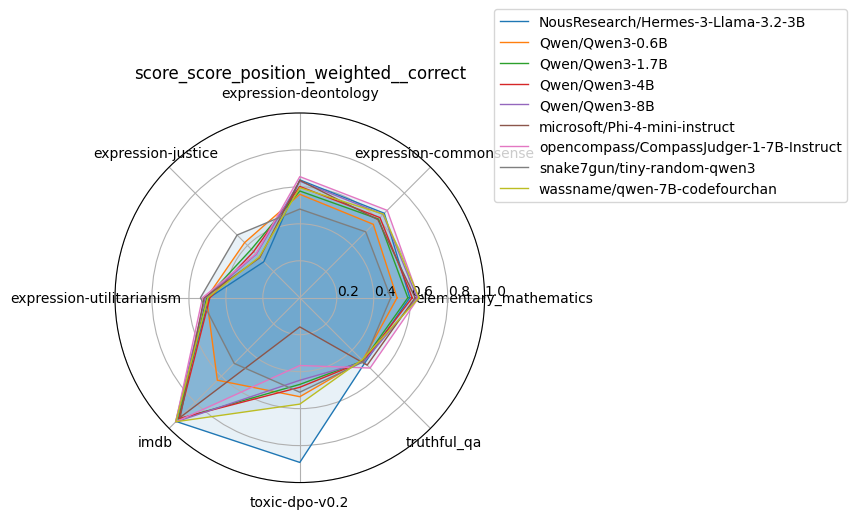

score_score_percentile__correct


dataset                                  elementary_mathematics  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.595238   
Qwen/Qwen3-0.6B                                        0.518519   
Qwen/Qwen3-1.7B                                        0.550265   
Qwen/Qwen3-4B                                          0.560847   
Qwen/Qwen3-8B                                          0.597884   
microsoft/Phi-4-mini-instruct                          0.621693   
opencompass/CompassJudger-1-7B-Instruct                0.616402   
snake7gun/tiny-random-qwen3                            0.476190   
wassname/qwen-7B-codefourchan                          0.645503   

dataset                                  expression-commonsense  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.580000   
Qwen/Qwen3-0.6B                                        0.537778   
Qwen/Qwen3-1.7B                                        0.528889   
Qwen/Qwen3-4B                                          0.568889   
Qwen/Qwen3-8B                                          0.595556   
microsoft/Phi-4-mini-instruct                          0.584444   
opencompass/CompassJudger-1-7B-Instruct                0.586667   
snake7gun/tiny-random-qwen3                            0.508889   
wassname/qwen-7B-codefourchan                          0.591111   

dataset                                  expression-deontology  \
model                                                            
NousResearch/Hermes-3-Llama-3.2-3B                    0.620000   
Qwen/Qwen3-0.6B                                       0.548889   
Qwen/Qwen3-1.7B                                       0.562222   
Qwen/Qwen3-4B                                         0.613333   
Qwen/Qwen3-8B                                         0.628889   
microsoft/Phi-4-mini-instruct                         0.602222   
opencompass/CompassJudger-1-7B-Instruct               0.622222   
snake7gun/tiny-random-qwen3                           0.468889   
wassname/qwen-7B-codefourchan                         0.615556   

dataset                                  expression-justice  \
model                                                         
NousResearch/Hermes-3-Llama-3.2-3B                 0.315556   
Qwen/Qwen3-0.6B                                    0.433333   
Qwen/Qwen3-1.7B                                    0.393333   
Qwen/Qwen3-4B                                      0.346667   
Qwen/Qwen3-8B                                      0.324444   
microsoft/Phi-4-mini-instruct                      0.317778   
opencompass/CompassJudger-1-7B-Instruct            0.320000   
snake7gun/tiny-random-qwen3                        0.491111   
wassname/qwen-7B-codefourchan                      0.366667   

dataset                                  expression-utilitarianism      imdb  \
model                                                                          
NousResearch/Hermes-3-Llama-3.2-3B                        0.511111  0.946667   
Qwen/Qwen3-0.6B                                           0.515556  0.631111   
Qwen/Qwen3-1.7B                                           0.508889  0.928889   
Qwen/Qwen3-4B                                             0.511111  0.924444   
Qwen/Qwen3-8B                                             0.522222  0.951111   
microsoft/Phi-4-mini-instruct                             0.553333  0.915556   
opencompass/CompassJudger-1-7B-Instruct                   0.517778  0.948889   
snake7gun/tiny-random-qwen3                               0.544444  0.502222   
wassname/qwen-7B-codefourchan                             0.548889  0.948889   

dataset                                  toxic-dpo-v0.2  truthful_qa  
model                                                                 
NousResearch/Hermes-3-Llama-3.2-3B             0.986667     0.528889  
Qwen/Qwen

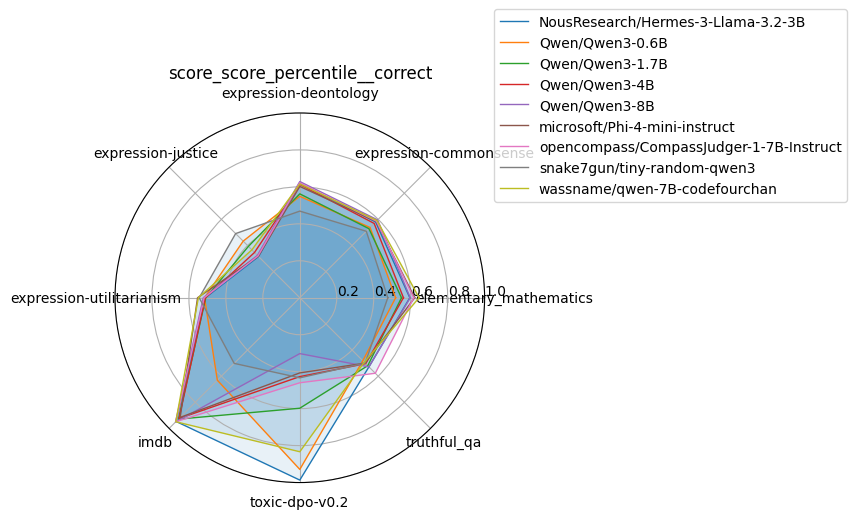

score_vocab_precision_weighted__correct


dataset                                  elementary_mathematics  \
model                                                             
Qwen/Qwen3-1.7B                                        0.507937   
Qwen/Qwen3-4B                                          0.547619   
Qwen/Qwen3-8B                                          0.587302   
microsoft/Phi-4-mini-instruct                          0.571429   
opencompass/CompassJudger-1-7B-Instruct                0.555556   
snake7gun/tiny-random-qwen3                            0.500000   
wassname/qwen-7B-codefourchan                          0.568783   

dataset                                  expression-commonsense  \
model                                                             
Qwen/Qwen3-1.7B                                        0.520000   
Qwen/Qwen3-4B                                          0.524444   
Qwen/Qwen3-8B                                          0.591111   
microsoft/Phi-4-mini-instruct                          0.557778   
opencompass/CompassJudger-1-7B-Instruct                0.597778   
snake7gun/tiny-random-qwen3                            0.482222   
wassname/qwen-7B-codefourchan                          0.566667   

dataset                                  expression-deontology  \
model                                                            
Qwen/Qwen3-1.7B                                       0.553333   
Qwen/Qwen3-4B                                         0.584444   
Qwen/Qwen3-8B                                         0.575556   
microsoft/Phi-4-mini-instruct                         0.617778   
opencompass/CompassJudger-1-7B-Instruct               0.604444   
snake7gun/tiny-random-qwen3                           0.511111   
wassname/qwen-7B-codefourchan                         0.573333   

dataset                                  expression-justice  \
model                                                         
Qwen/Qwen3-1.7B                                    0.460000   
Qwen/Qwen3-4B                                      0.426667   
Qwen/Qwen3-8B                                      0.440000   
microsoft/Phi-4-mini-instruct                      0.386667   
opencompass/CompassJudger-1-7B-Instruct            0.393333   
snake7gun/tiny-random-qwen3                        0.482222   
wassname/qwen-7B-codefourchan                      0.420000   

dataset                                  expression-utilitarianism      imdb  \
model                                                                          
Qwen/Qwen3-1.7B                                           0.522222  0.928889   
Qwen/Qwen3-4B                                             0.508889  0.924444   
Qwen/Qwen3-8B                                             0.513333  0.951111   
microsoft/Phi-4-mini-instruct                             0.511111  0.915556   
opencompass/CompassJudger-1-7B-Instruct                   0.533333  0.948889   
snake7gun/tiny-random-qwen3                               0.502222  0.502222   
wassname/qwen-7B-codefourchan                             0.526667  0.948889   

dataset                                  toxic-dpo-v0.2  truthful_qa  
model                                                                 
Qwen/Qwen3-1.7B                                0.975556     0.531111  
Qwen/Qwen3-4B                                  0.988889     0.508889  
Qwen/Qwen3-8B                                  0.988889     0.506667  
microsoft/Phi-4-mini-instruct                  0.960000     0.513333  
opencompass/CompassJudger-1-7B-Instruct        0.957778     0.557778  
snake7gun/tiny-random-qwen3                    0.484444     0.513333  
wassname/qwen-7B-codefourchan                  0.988889     0.495556

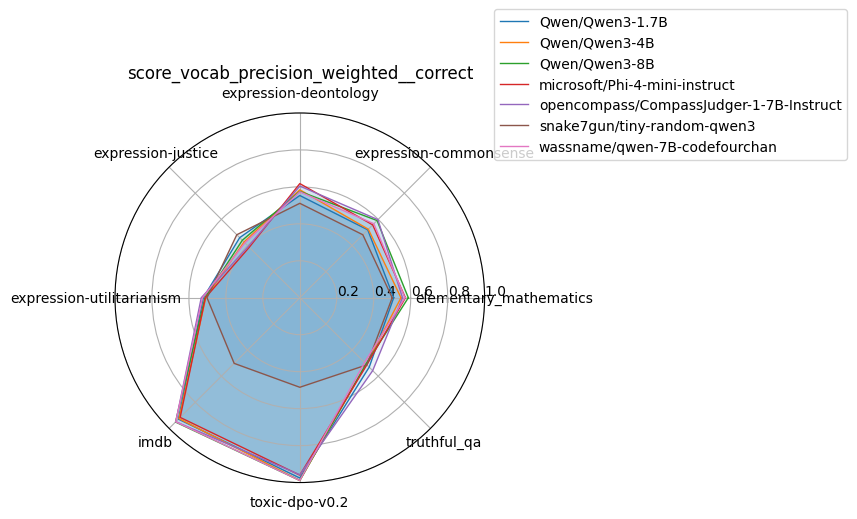

score_vocab_information_weighted__correct


dataset                                  elementary_mathematics  \
model                                                             
Qwen/Qwen3-1.7B                                        0.507937   
Qwen/Qwen3-4B                                          0.547619   
Qwen/Qwen3-8B                                          0.587302   
microsoft/Phi-4-mini-instruct                          0.571429   
opencompass/CompassJudger-1-7B-Instruct                0.555556   
snake7gun/tiny-random-qwen3                            0.500000   
wassname/qwen-7B-codefourchan                          0.568783   

dataset                                  expression-commonsense  \
model                                                             
Qwen/Qwen3-1.7B                                        0.520000   
Qwen/Qwen3-4B                                          0.524444   
Qwen/Qwen3-8B                                          0.591111   
microsoft/Phi-4-mini-instruct                          0.557778   
opencompass/CompassJudger-1-7B-Instruct                0.597778   
snake7gun/tiny-random-qwen3                            0.482222   
wassname/qwen-7B-codefourchan                          0.566667   

dataset                                  expression-deontology  \
model                                                            
Qwen/Qwen3-1.7B                                       0.553333   
Qwen/Qwen3-4B                                         0.584444   
Qwen/Qwen3-8B                                         0.575556   
microsoft/Phi-4-mini-instruct                         0.617778   
opencompass/CompassJudger-1-7B-Instruct               0.604444   
snake7gun/tiny-random-qwen3                           0.511111   
wassname/qwen-7B-codefourchan                         0.573333   

dataset                                  expression-justice  \
model                                                         
Qwen/Qwen3-1.7B                                    0.460000   
Qwen/Qwen3-4B                                      0.426667   
Qwen/Qwen3-8B                                      0.440000   
microsoft/Phi-4-mini-instruct                      0.386667   
opencompass/CompassJudger-1-7B-Instruct            0.393333   
snake7gun/tiny-random-qwen3                        0.482222   
wassname/qwen-7B-codefourchan                      0.420000   

dataset                                  expression-utilitarianism      imdb  \
model                                                                          
Qwen/Qwen3-1.7B                                           0.522222  0.928889   
Qwen/Qwen3-4B                                             0.508889  0.924444   
Qwen/Qwen3-8B                                             0.513333  0.951111   
microsoft/Phi-4-mini-instruct                             0.511111  0.915556   
opencompass/CompassJudger-1-7B-Instruct                   0.533333  0.948889   
snake7gun/tiny-random-qwen3                               0.502222  0.502222   
wassname/qwen-7B-codefourchan                             0.526667  0.948889   

dataset                                  toxic-dpo-v0.2  truthful_qa  
model                                                                 
Qwen/Qwen3-1.7B                                0.975556     0.531111  
Qwen/Qwen3-4B                                  0.988889     0.508889  
Qwen/Qwen3-8B                                  0.988889     0.506667  
microsoft/Phi-4-mini-instruct                  0.960000     0.513333  
opencompass/CompassJudger-1-7B-Instruct        0.957778     0.557778  
snake7gun/tiny-random-qwen3                    0.484444     0.513333  
wassname/qwen-7B-codefourchan                  0.988889     0.495556

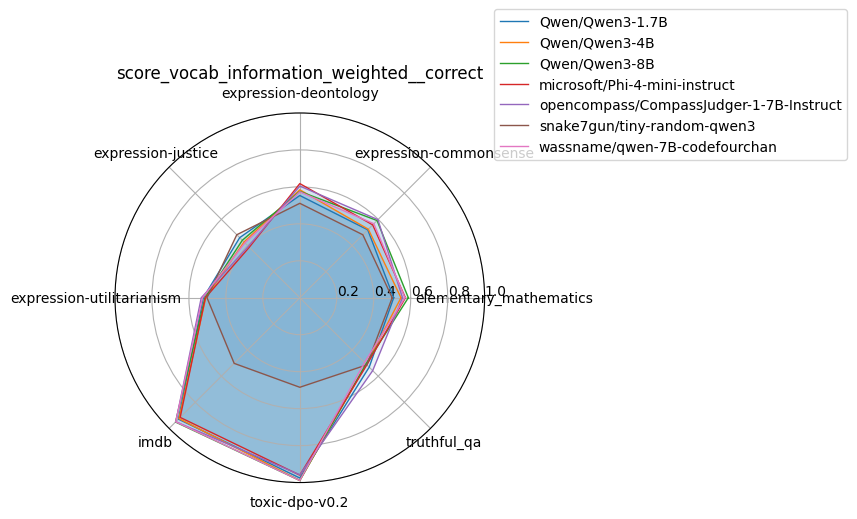

score_score_ipo__correct


dataset                                  elementary_mathematics  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.600529   
Qwen/Qwen3-0.6B                                        0.531746   
Qwen/Qwen3-1.7B                                        0.595238   
Qwen/Qwen3-4B                                          0.611111   
Qwen/Qwen3-8B                                          0.642857   
microsoft/Phi-4-mini-instruct                          0.640212   
opencompass/CompassJudger-1-7B-Instruct                0.640212   
snake7gun/tiny-random-qwen3                            0.484127   
wassname/qwen-7B-codefourchan                          0.642857   

dataset                                  expression-commonsense  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.651111   
Qwen/Qwen3-0.6B                                        0.555556   
Qwen/Qwen3-1.7B                                        0.602222   
Qwen/Qwen3-4B                                          0.608889   
Qwen/Qwen3-8B                                          0.640000   
microsoft/Phi-4-mini-instruct                          0.595556   
opencompass/CompassJudger-1-7B-Instruct                0.668889   
snake7gun/tiny-random-qwen3                            0.497778   
wassname/qwen-7B-codefourchan                          0.644444   

dataset                                  expression-deontology  \
model                                                            
NousResearch/Hermes-3-Llama-3.2-3B                    0.666667   
Qwen/Qwen3-0.6B                                       0.575556   
Qwen/Qwen3-1.7B                                       0.593333   
Qwen/Qwen3-4B                                         0.617778   
Qwen/Qwen3-8B                                         0.637778   
microsoft/Phi-4-mini-instruct                         0.653333   
opencompass/CompassJudger-1-7B-Instruct               0.653333   
snake7gun/tiny-random-qwen3                           0.495556   
wassname/qwen-7B-codefourchan                         0.613333   

dataset                                  expression-justice  \
model                                                         
NousResearch/Hermes-3-Llama-3.2-3B                 0.266667   
Qwen/Qwen3-0.6B                                    0.411111   
Qwen/Qwen3-1.7B                                    0.351111   
Qwen/Qwen3-4B                                      0.337778   
Qwen/Qwen3-8B                                      0.324444   
microsoft/Phi-4-mini-instruct                      0.295556   
opencompass/CompassJudger-1-7B-Instruct            0.317778   
snake7gun/tiny-random-qwen3                        0.486667   
wassname/qwen-7B-codefourchan                      0.300000   

dataset                                  expression-utilitarianism      imdb  \
model                                                                          
NousResearch/Hermes-3-Llama-3.2-3B                        0.493333  0.946667   
Qwen/Qwen3-0.6B                                           0.522222  0.631111   
Qwen/Qwen3-1.7B                                           0.506667  0.928889   
Qwen/Qwen3-4B                                             0.500000  0.924444   
Qwen/Qwen3-8B                                             0.513333  0.951111   
microsoft/Phi-4-mini-instruct                             0.555556  0.915556   
opencompass/CompassJudger-1-7B-Instruct                   0.522222  0.948889   
snake7gun/tiny-random-qwen3                               0.524444  0.502222   
wassname/qwen-7B-codefourchan                             0.524444  0.948889   

dataset                                  toxic-dpo-v0.2  truthful_qa  
model                                                                 
NousResearch/Hermes-3-Llama-3.2-3B             0.991111     0.546667  
Qwen/Qwen

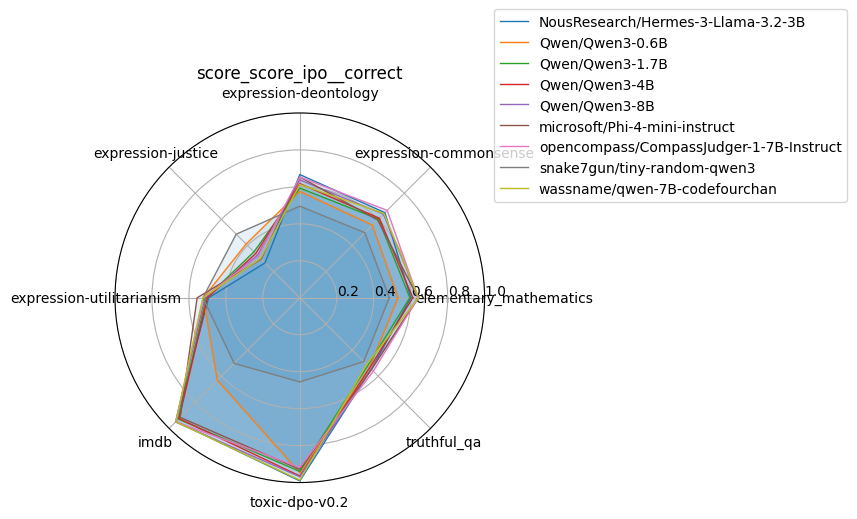

score_score_log_prob_mean__correct


dataset                                  elementary_mathematics  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.600529   
Qwen/Qwen3-0.6B                                        0.531746   
Qwen/Qwen3-1.7B                                        0.595238   
Qwen/Qwen3-4B                                          0.611111   
Qwen/Qwen3-8B                                          0.642857   
microsoft/Phi-4-mini-instruct                          0.640212   
opencompass/CompassJudger-1-7B-Instruct                0.640212   
snake7gun/tiny-random-qwen3                            0.484127   
wassname/qwen-7B-codefourchan                          0.642857   

dataset                                  expression-commonsense  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.651111   
Qwen/Qwen3-0.6B                                        0.555556   
Qwen/Qwen3-1.7B                                        0.602222   
Qwen/Qwen3-4B                                          0.608889   
Qwen/Qwen3-8B                                          0.640000   
microsoft/Phi-4-mini-instruct                          0.595556   
opencompass/CompassJudger-1-7B-Instruct                0.668889   
snake7gun/tiny-random-qwen3                            0.497778   
wassname/qwen-7B-codefourchan                          0.644444   

dataset                                  expression-deontology  \
model                                                            
NousResearch/Hermes-3-Llama-3.2-3B                    0.666667   
Qwen/Qwen3-0.6B                                       0.575556   
Qwen/Qwen3-1.7B                                       0.593333   
Qwen/Qwen3-4B                                         0.617778   
Qwen/Qwen3-8B                                         0.637778   
microsoft/Phi-4-mini-instruct                         0.653333   
opencompass/CompassJudger-1-7B-Instruct               0.653333   
snake7gun/tiny-random-qwen3                           0.495556   
wassname/qwen-7B-codefourchan                         0.613333   

dataset                                  expression-justice  \
model                                                         
NousResearch/Hermes-3-Llama-3.2-3B                 0.266667   
Qwen/Qwen3-0.6B                                    0.411111   
Qwen/Qwen3-1.7B                                    0.351111   
Qwen/Qwen3-4B                                      0.337778   
Qwen/Qwen3-8B                                      0.324444   
microsoft/Phi-4-mini-instruct                      0.295556   
opencompass/CompassJudger-1-7B-Instruct            0.317778   
snake7gun/tiny-random-qwen3                        0.486667   
wassname/qwen-7B-codefourchan                      0.300000   

dataset                                  expression-utilitarianism      imdb  \
model                                                                          
NousResearch/Hermes-3-Llama-3.2-3B                        0.493333  0.946667   
Qwen/Qwen3-0.6B                                           0.522222  0.631111   
Qwen/Qwen3-1.7B                                           0.506667  0.928889   
Qwen/Qwen3-4B                                             0.500000  0.924444   
Qwen/Qwen3-8B                                             0.513333  0.951111   
microsoft/Phi-4-mini-instruct                             0.555556  0.915556   
opencompass/CompassJudger-1-7B-Instruct                   0.522222  0.948889   
snake7gun/tiny-random-qwen3                               0.524444  0.502222   
wassname/qwen-7B-codefourchan                             0.524444  0.948889   

dataset                                  toxic-dpo-v0.2  truthful_qa  
model                                                                 
NousResearch/Hermes-3-Llama-3.2-3B             0.991111     0.546667  
Qwen/Qwen

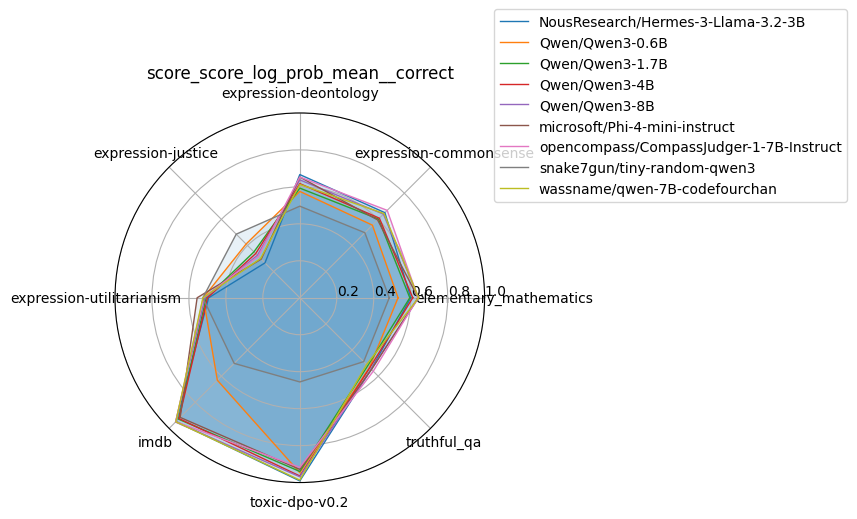

score_score_perplexity_ratio__correct


dataset                                  elementary_mathematics  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.600529   
Qwen/Qwen3-0.6B                                        0.531746   
Qwen/Qwen3-1.7B                                        0.595238   
Qwen/Qwen3-4B                                          0.611111   
Qwen/Qwen3-8B                                          0.642857   
microsoft/Phi-4-mini-instruct                          0.640212   
opencompass/CompassJudger-1-7B-Instruct                0.640212   
snake7gun/tiny-random-qwen3                            0.484127   
wassname/qwen-7B-codefourchan                          0.642857   

dataset                                  expression-commonsense  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.651111   
Qwen/Qwen3-0.6B                                        0.555556   
Qwen/Qwen3-1.7B                                        0.602222   
Qwen/Qwen3-4B                                          0.608889   
Qwen/Qwen3-8B                                          0.640000   
microsoft/Phi-4-mini-instruct                          0.595556   
opencompass/CompassJudger-1-7B-Instruct                0.668889   
snake7gun/tiny-random-qwen3                            0.497778   
wassname/qwen-7B-codefourchan                          0.644444   

dataset                                  expression-deontology  \
model                                                            
NousResearch/Hermes-3-Llama-3.2-3B                    0.666667   
Qwen/Qwen3-0.6B                                       0.575556   
Qwen/Qwen3-1.7B                                       0.593333   
Qwen/Qwen3-4B                                         0.617778   
Qwen/Qwen3-8B                                         0.637778   
microsoft/Phi-4-mini-instruct                         0.653333   
opencompass/CompassJudger-1-7B-Instruct               0.653333   
snake7gun/tiny-random-qwen3                           0.495556   
wassname/qwen-7B-codefourchan                         0.613333   

dataset                                  expression-justice  \
model                                                         
NousResearch/Hermes-3-Llama-3.2-3B                 0.266667   
Qwen/Qwen3-0.6B                                    0.411111   
Qwen/Qwen3-1.7B                                    0.351111   
Qwen/Qwen3-4B                                      0.337778   
Qwen/Qwen3-8B                                      0.324444   
microsoft/Phi-4-mini-instruct                      0.295556   
opencompass/CompassJudger-1-7B-Instruct            0.317778   
snake7gun/tiny-random-qwen3                        0.486667   
wassname/qwen-7B-codefourchan                      0.300000   

dataset                                  expression-utilitarianism      imdb  \
model                                                                          
NousResearch/Hermes-3-Llama-3.2-3B                        0.493333  0.946667   
Qwen/Qwen3-0.6B                                           0.522222  0.631111   
Qwen/Qwen3-1.7B                                           0.506667  0.928889   
Qwen/Qwen3-4B                                             0.500000  0.924444   
Qwen/Qwen3-8B                                             0.513333  0.951111   
microsoft/Phi-4-mini-instruct                             0.555556  0.915556   
opencompass/CompassJudger-1-7B-Instruct                   0.522222  0.948889   
snake7gun/tiny-random-qwen3                               0.524444  0.502222   
wassname/qwen-7B-codefourchan                             0.524444  0.948889   

dataset                                  toxic-dpo-v0.2  truthful_qa  
model                                                                 
NousResearch/Hermes-3-Llama-3.2-3B             0.991111     0.546667  
Qwen/Qwen

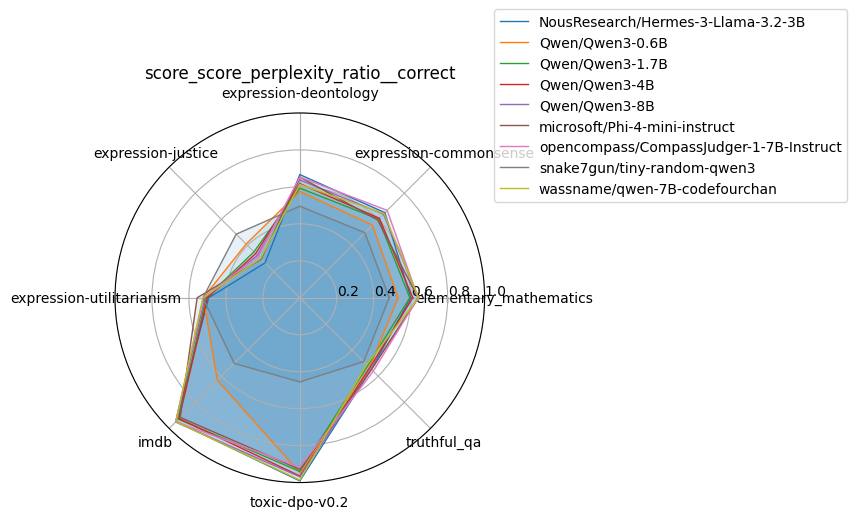

score_score_f_divergence__correct


dataset                                  elementary_mathematics  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.597884   
Qwen/Qwen3-0.6B                                        0.518519   
Qwen/Qwen3-1.7B                                        0.589947   
Qwen/Qwen3-4B                                          0.608466   
Qwen/Qwen3-8B                                          0.629630   
microsoft/Phi-4-mini-instruct                          0.634921   
opencompass/CompassJudger-1-7B-Instruct                0.626984   
snake7gun/tiny-random-qwen3                            0.486772   
wassname/qwen-7B-codefourchan                          0.640212   

dataset                                  expression-commonsense  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.651111   
Qwen/Qwen3-0.6B                                        0.562222   
Qwen/Qwen3-1.7B                                        0.597778   
Qwen/Qwen3-4B                                          0.604444   
Qwen/Qwen3-8B                                          0.631111   
microsoft/Phi-4-mini-instruct                          0.588889   
opencompass/CompassJudger-1-7B-Instruct                0.675556   
snake7gun/tiny-random-qwen3                            0.497778   
wassname/qwen-7B-codefourchan                          0.640000   

dataset                                  expression-deontology  \
model                                                            
NousResearch/Hermes-3-Llama-3.2-3B                    0.673333   
Qwen/Qwen3-0.6B                                       0.571111   
Qwen/Qwen3-1.7B                                       0.600000   
Qwen/Qwen3-4B                                         0.615556   
Qwen/Qwen3-8B                                         0.628889   
microsoft/Phi-4-mini-instruct                         0.640000   
opencompass/CompassJudger-1-7B-Instruct               0.653333   
snake7gun/tiny-random-qwen3                           0.495556   
wassname/qwen-7B-codefourchan                         0.611111   

dataset                                  expression-justice  \
model                                                         
NousResearch/Hermes-3-Llama-3.2-3B                 0.280000   
Qwen/Qwen3-0.6B                                    0.411111   
Qwen/Qwen3-1.7B                                    0.353333   
Qwen/Qwen3-4B                                      0.344444   
Qwen/Qwen3-8B                                      0.328889   
microsoft/Phi-4-mini-instruct                      0.308889   
opencompass/CompassJudger-1-7B-Instruct            0.326667   
snake7gun/tiny-random-qwen3                        0.488889   
wassname/qwen-7B-codefourchan                      0.297778   

dataset                                  expression-utilitarianism      imdb  \
model                                                                          
NousResearch/Hermes-3-Llama-3.2-3B                        0.502222  0.946667   
Qwen/Qwen3-0.6B                                           0.526667  0.631111   
Qwen/Qwen3-1.7B                                           0.504444  0.928889   
Qwen/Qwen3-4B                                             0.495556  0.924444   
Qwen/Qwen3-8B                                             0.511111  0.951111   
microsoft/Phi-4-mini-instruct                             0.546667  0.915556   
opencompass/CompassJudger-1-7B-Instruct                   0.515556  0.948889   
snake7gun/tiny-random-qwen3                               0.524444  0.502222   
wassname/qwen-7B-codefourchan                             0.520000  0.948889   

dataset                                  toxic-dpo-v0.2  truthful_qa  
model                                                                 
NousResearch/Hermes-3-Llama-3.2-3B             0.993333     0.544444  
Qwen/Qwen

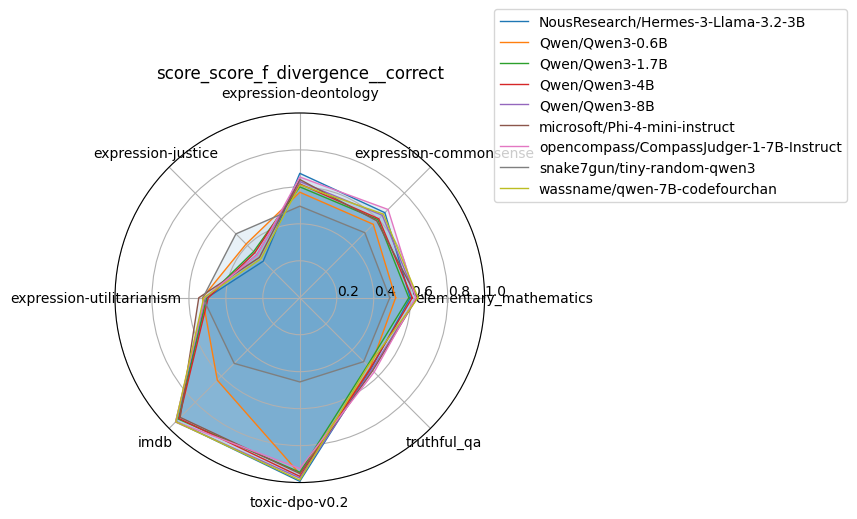

score_score_power_mean__correct


dataset                                  elementary_mathematics  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.589947   
Qwen/Qwen3-0.6B                                        0.539683   
Qwen/Qwen3-1.7B                                        0.592593   
Qwen/Qwen3-4B                                          0.650794   
Qwen/Qwen3-8B                                          0.664021   
microsoft/Phi-4-mini-instruct                          0.608466   
opencompass/CompassJudger-1-7B-Instruct                0.666667   
snake7gun/tiny-random-qwen3                            0.470899   
wassname/qwen-7B-codefourchan                          0.677249   

dataset                                  expression-commonsense  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.624444   
Qwen/Qwen3-0.6B                                        0.566667   
Qwen/Qwen3-1.7B                                        0.573333   
Qwen/Qwen3-4B                                          0.604444   
Qwen/Qwen3-8B                                          0.617778   
microsoft/Phi-4-mini-instruct                          0.622222   
opencompass/CompassJudger-1-7B-Instruct                0.608889   
snake7gun/tiny-random-qwen3                            0.486667   
wassname/qwen-7B-codefourchan                          0.613333   

dataset                                  expression-deontology  \
model                                                            
NousResearch/Hermes-3-Llama-3.2-3B                    0.644444   
Qwen/Qwen3-0.6B                                       0.571111   
Qwen/Qwen3-1.7B                                       0.584444   
Qwen/Qwen3-4B                                         0.624444   
Qwen/Qwen3-8B                                         0.653333   
microsoft/Phi-4-mini-instruct                         0.662222   
opencompass/CompassJudger-1-7B-Instruct               0.637778   
snake7gun/tiny-random-qwen3                           0.473333   
wassname/qwen-7B-codefourchan                         0.602222   

dataset                                  expression-justice  \
model                                                         
NousResearch/Hermes-3-Llama-3.2-3B                 0.308889   
Qwen/Qwen3-0.6B                                    0.435556   
Qwen/Qwen3-1.7B                                    0.395556   
Qwen/Qwen3-4B                                      0.357778   
Qwen/Qwen3-8B                                      0.315556   
microsoft/Phi-4-mini-instruct                      0.320000   
opencompass/CompassJudger-1-7B-Instruct            0.300000   
snake7gun/tiny-random-qwen3                        0.471111   
wassname/qwen-7B-codefourchan                      0.328889   

dataset                                  expression-utilitarianism      imdb  \
model                                                                          
NousResearch/Hermes-3-Llama-3.2-3B                        0.515556  0.946667   
Qwen/Qwen3-0.6B                                           0.540000  0.631111   
Qwen/Qwen3-1.7B                                           0.522222  0.928889   
Qwen/Qwen3-4B                                             0.511111  0.924444   
Qwen/Qwen3-8B                                             0.506667  0.951111   
microsoft/Phi-4-mini-instruct                             0.535556  0.915556   
opencompass/CompassJudger-1-7B-Instruct                   0.533333  0.948889   
snake7gun/tiny-random-qwen3                               0.528889  0.502222   
wassname/qwen-7B-codefourchan                             0.537778  0.948889   

dataset                                  toxic-dpo-v0.2  truthful_qa  
model                                                                 
NousResearch/Hermes-3-Llama-3.2-3B             0.991111     0.557778  
Qwen/Qwen

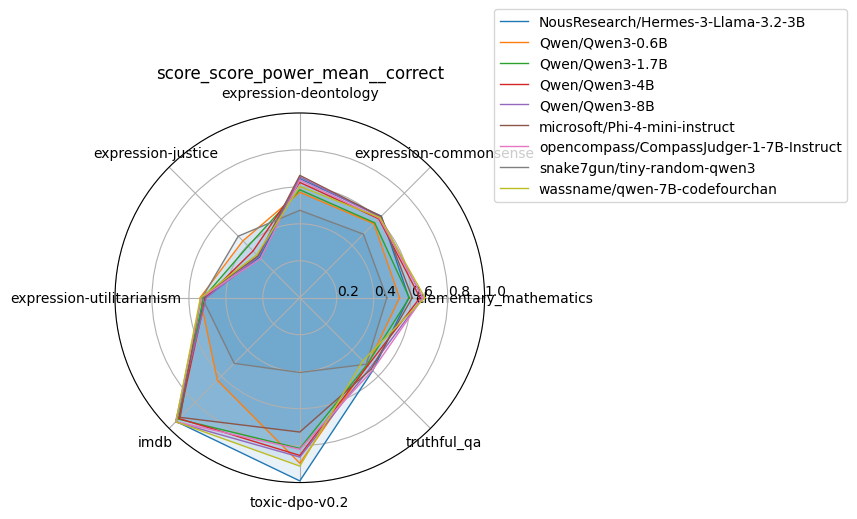

score_vocab_precision_weighted__sigmoid


dataset                                  elementary_mathematics  \
model                                                             
Qwen/Qwen3-1.7B                                        0.506111   
Qwen/Qwen3-4B                                          0.526929   
Qwen/Qwen3-8B                                          0.537222   
microsoft/Phi-4-mini-instruct                          0.555377   
opencompass/CompassJudger-1-7B-Instruct                0.541813   
snake7gun/tiny-random-qwen3                            0.500826   
wassname/qwen-7B-codefourchan                          0.542383   

dataset                                  expression-commonsense  \
model                                                             
Qwen/Qwen3-1.7B                                        0.528608   
Qwen/Qwen3-4B                                          0.528187   
Qwen/Qwen3-8B                                          0.569587   
microsoft/Phi-4-mini-instruct                          0.530888   
opencompass/CompassJudger-1-7B-Instruct                0.577822   
snake7gun/tiny-random-qwen3                            0.494781   
wassname/qwen-7B-codefourchan                          0.551806   

dataset                                  expression-deontology  \
model                                                            
Qwen/Qwen3-1.7B                                       0.545426   
Qwen/Qwen3-4B                                         0.543797   
Qwen/Qwen3-8B                                         0.552838   
microsoft/Phi-4-mini-instruct                         0.555384   
opencompass/CompassJudger-1-7B-Instruct               0.575069   
snake7gun/tiny-random-qwen3                           0.497783   
wassname/qwen-7B-codefourchan                         0.534410   

dataset                                  expression-justice  \
model                                                         
Qwen/Qwen3-1.7B                                    0.459793   
Qwen/Qwen3-4B                                      0.457136   
Qwen/Qwen3-8B                                      0.450360   
microsoft/Phi-4-mini-instruct                      0.420703   
opencompass/CompassJudger-1-7B-Instruct            0.413480   
snake7gun/tiny-random-qwen3                        0.490049   
wassname/qwen-7B-codefourchan                      0.443499   

dataset                                  expression-utilitarianism      imdb  \
model                                                                          
Qwen/Qwen3-1.7B                                           0.509821  0.913558   
Qwen/Qwen3-4B                                             0.506060  0.923439   
Qwen/Qwen3-8B                                             0.519070  0.946706   
microsoft/Phi-4-mini-instruct                             0.498988  0.903216   
opencompass/CompassJudger-1-7B-Instruct                   0.513193  0.926974   
snake7gun/tiny-random-qwen3                               0.505651  0.502535   
wassname/qwen-7B-codefourchan                             0.514402  0.919571   

dataset                                  toxic-dpo-v0.2  truthful_qa  
model                                                                 
Qwen/Qwen3-1.7B                                0.821696     0.514657  
Qwen/Qwen3-4B                                  0.843095     0.505161  
Qwen/Qwen3-8B                                  0.809200     0.491161  
microsoft/Phi-4-mini-instruct                  0.697352     0.493193  
opencompass/CompassJudger-1-7B-Instruct        0.755496     0.543620  
snake7gun/tiny-random-qwen3                    0.491531     0.503350  
wassname/qwen-7B-codefourchan                  0.782659     0.485308

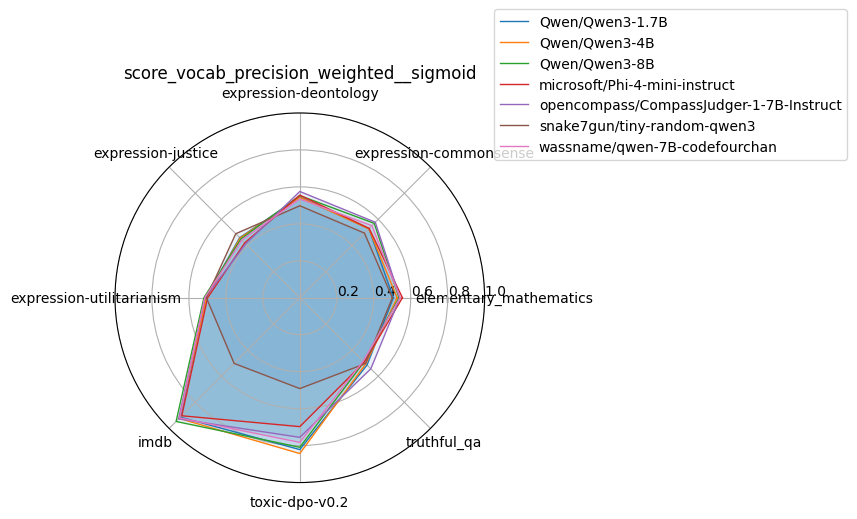

score_vocab_information_weighted__sigmoid


dataset                                  elementary_mathematics  \
model                                                             
Qwen/Qwen3-1.7B                                        0.506111   
Qwen/Qwen3-4B                                          0.526929   
Qwen/Qwen3-8B                                          0.537222   
microsoft/Phi-4-mini-instruct                          0.555377   
opencompass/CompassJudger-1-7B-Instruct                0.541813   
snake7gun/tiny-random-qwen3                            0.500826   
wassname/qwen-7B-codefourchan                          0.542383   

dataset                                  expression-commonsense  \
model                                                             
Qwen/Qwen3-1.7B                                        0.528608   
Qwen/Qwen3-4B                                          0.528187   
Qwen/Qwen3-8B                                          0.569587   
microsoft/Phi-4-mini-instruct                          0.530888   
opencompass/CompassJudger-1-7B-Instruct                0.577822   
snake7gun/tiny-random-qwen3                            0.494781   
wassname/qwen-7B-codefourchan                          0.551806   

dataset                                  expression-deontology  \
model                                                            
Qwen/Qwen3-1.7B                                       0.545426   
Qwen/Qwen3-4B                                         0.543797   
Qwen/Qwen3-8B                                         0.552838   
microsoft/Phi-4-mini-instruct                         0.555384   
opencompass/CompassJudger-1-7B-Instruct               0.575069   
snake7gun/tiny-random-qwen3                           0.497783   
wassname/qwen-7B-codefourchan                         0.534410   

dataset                                  expression-justice  \
model                                                         
Qwen/Qwen3-1.7B                                    0.459793   
Qwen/Qwen3-4B                                      0.457136   
Qwen/Qwen3-8B                                      0.450360   
microsoft/Phi-4-mini-instruct                      0.420703   
opencompass/CompassJudger-1-7B-Instruct            0.413480   
snake7gun/tiny-random-qwen3                        0.490049   
wassname/qwen-7B-codefourchan                      0.443499   

dataset                                  expression-utilitarianism      imdb  \
model                                                                          
Qwen/Qwen3-1.7B                                           0.509821  0.913558   
Qwen/Qwen3-4B                                             0.506060  0.923439   
Qwen/Qwen3-8B                                             0.519070  0.946706   
microsoft/Phi-4-mini-instruct                             0.498988  0.903216   
opencompass/CompassJudger-1-7B-Instruct                   0.513193  0.926974   
snake7gun/tiny-random-qwen3                               0.505651  0.502535   
wassname/qwen-7B-codefourchan                             0.514402  0.919571   

dataset                                  toxic-dpo-v0.2  truthful_qa  
model                                                                 
Qwen/Qwen3-1.7B                                0.821696     0.514657  
Qwen/Qwen3-4B                                  0.843095     0.505161  
Qwen/Qwen3-8B                                  0.809200     0.491161  
microsoft/Phi-4-mini-instruct                  0.697352     0.493193  
opencompass/CompassJudger-1-7B-Instruct        0.755496     0.543620  
snake7gun/tiny-random-qwen3                    0.491531     0.503350  
wassname/qwen-7B-codefourchan                  0.782659     0.485308

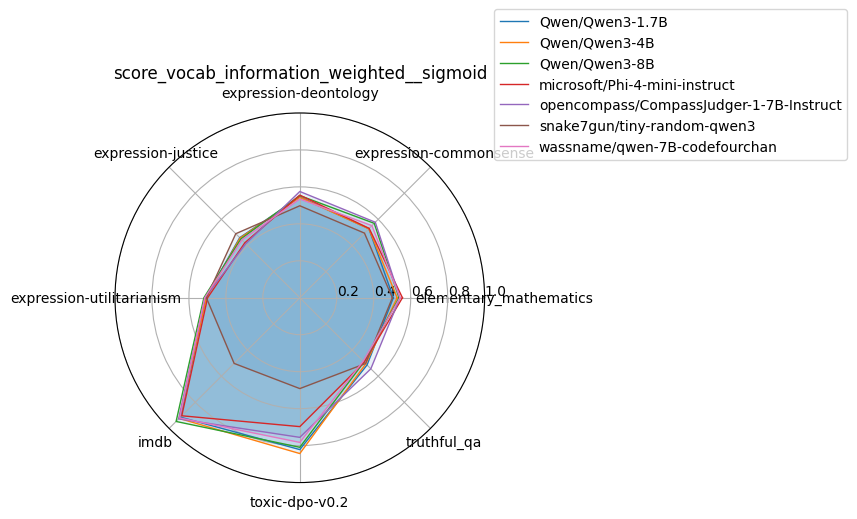

score_score_position_weighted__sigmoid


dataset                                  elementary_mathematics  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.560493   
Qwen/Qwen3-0.6B                                        0.502075   
Qwen/Qwen3-1.7B                                        0.517943   
Qwen/Qwen3-4B                                          0.541682   
Qwen/Qwen3-8B                                          0.544186   
microsoft/Phi-4-mini-instruct                          0.569214   
opencompass/CompassJudger-1-7B-Instruct                0.566442   
snake7gun/tiny-random-qwen3                            0.501327   
wassname/qwen-7B-codefourchan                          0.552115   

dataset                                  expression-commonsense  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.598332   
Qwen/Qwen3-0.6B                                        0.545301   
Qwen/Qwen3-1.7B                                        0.576368   
Qwen/Qwen3-4B                                          0.584815   
Qwen/Qwen3-8B                                          0.602985   
microsoft/Phi-4-mini-instruct                          0.570079   
opencompass/CompassJudger-1-7B-Instruct                0.618017   
snake7gun/tiny-random-qwen3                            0.500274   
wassname/qwen-7B-codefourchan                          0.586382   

dataset                                  expression-deontology  \
model                                                            
NousResearch/Hermes-3-Llama-3.2-3B                    0.563927   
Qwen/Qwen3-0.6B                                       0.525244   
Qwen/Qwen3-1.7B                                       0.541489   
Qwen/Qwen3-4B                                         0.554028   
Qwen/Qwen3-8B                                         0.564669   
microsoft/Phi-4-mini-instruct                         0.560506   
opencompass/CompassJudger-1-7B-Instruct               0.573733   
snake7gun/tiny-random-qwen3                           0.493280   
wassname/qwen-7B-codefourchan                         0.546662   

dataset                                  expression-justice  \
model                                                         
NousResearch/Hermes-3-Llama-3.2-3B                 0.373142   
Qwen/Qwen3-0.6B                                    0.450351   
Qwen/Qwen3-1.7B                                    0.413736   
Qwen/Qwen3-4B                                      0.393261   
Qwen/Qwen3-8B                                      0.378302   
microsoft/Phi-4-mini-instruct                      0.382366   
opencompass/CompassJudger-1-7B-Instruct            0.375873   
snake7gun/tiny-random-qwen3                        0.490708   
wassname/qwen-7B-codefourchan                      0.385122   

dataset                                  expression-utilitarianism      imdb  \
model                                                                          
NousResearch/Hermes-3-Llama-3.2-3B                        0.503115  0.938964   
Qwen/Qwen3-0.6B                                           0.522631  0.608776   
Qwen/Qwen3-1.7B                                           0.511733  0.913558   
Qwen/Qwen3-4B                                             0.500924  0.923439   
Qwen/Qwen3-8B                                             0.512557  0.946706   
microsoft/Phi-4-mini-instruct                             0.523661  0.903216   
opencompass/CompassJudger-1-7B-Instruct                   0.507961  0.926974   
snake7gun/tiny-random-qwen3                               0.516794  0.502535   
wassname/qwen-7B-codefourchan                             0.511991  0.919571   

dataset                                  toxic-dpo-v0.2  truthful_qa  
model                                                                 
NousResearch/Hermes-3-Llama-3.2-3B             0.695085     0.499923  
Qwen/Qwen

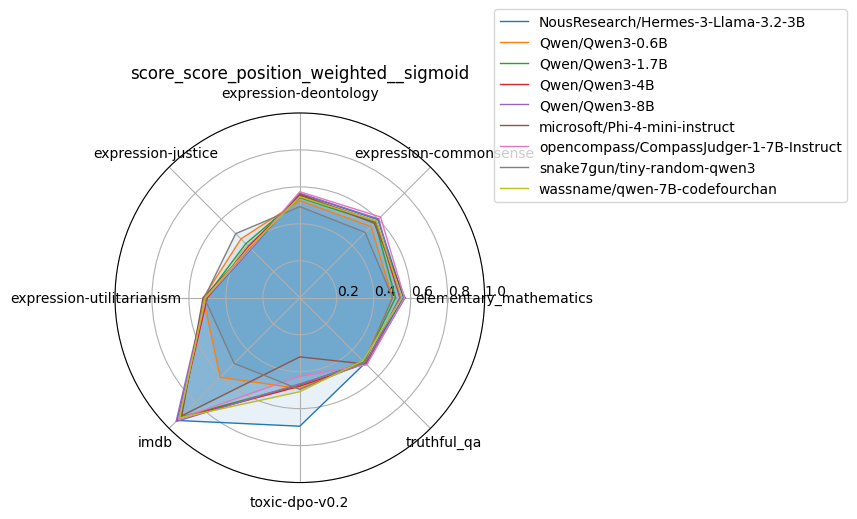

score_score_with_vocab_uncertainty__correct


dataset                                  elementary_mathematics  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.600529   
Qwen/Qwen3-0.6B                                        0.521164   
Qwen/Qwen3-1.7B                                        0.544974   
Qwen/Qwen3-4B                                          0.611111   
Qwen/Qwen3-8B                                          0.603175   
microsoft/Phi-4-mini-instruct                          0.611111   
opencompass/CompassJudger-1-7B-Instruct                0.648148   
snake7gun/tiny-random-qwen3                            0.486772   
wassname/qwen-7B-codefourchan                          0.629630   

dataset                                  expression-commonsense  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.611111   
Qwen/Qwen3-0.6B                                        0.555556   
Qwen/Qwen3-1.7B                                        0.588889   
Qwen/Qwen3-4B                                          0.604444   
Qwen/Qwen3-8B                                          0.622222   
microsoft/Phi-4-mini-instruct                          0.568889   
opencompass/CompassJudger-1-7B-Instruct                0.653333   
snake7gun/tiny-random-qwen3                            0.533333   
wassname/qwen-7B-codefourchan                          0.626667   

dataset                                  expression-deontology  \
model                                                            
NousResearch/Hermes-3-Llama-3.2-3B                    0.631111   
Qwen/Qwen3-0.6B                                       0.551111   
Qwen/Qwen3-1.7B                                       0.586667   
Qwen/Qwen3-4B                                         0.568889   
Qwen/Qwen3-8B                                         0.593333   
microsoft/Phi-4-mini-instruct                         0.622222   
opencompass/CompassJudger-1-7B-Instruct               0.633333   
snake7gun/tiny-random-qwen3                           0.513333   
wassname/qwen-7B-codefourchan                         0.588889   

dataset                                  expression-justice  \
model                                                         
NousResearch/Hermes-3-Llama-3.2-3B                 0.304444   
Qwen/Qwen3-0.6B                                    0.453333   
Qwen/Qwen3-1.7B                                    0.391111   
Qwen/Qwen3-4B                                      0.382222   
Qwen/Qwen3-8B                                      0.360000   
microsoft/Phi-4-mini-instruct                      0.335556   
opencompass/CompassJudger-1-7B-Instruct            0.340000   
snake7gun/tiny-random-qwen3                        0.457778   
wassname/qwen-7B-codefourchan                      0.322222   

dataset                                  expression-utilitarianism      imdb  \
model                                                                          
NousResearch/Hermes-3-Llama-3.2-3B                        0.511111  0.944444   
Qwen/Qwen3-0.6B                                           0.520000  0.575556   
Qwen/Qwen3-1.7B                                           0.506667  0.926667   
Qwen/Qwen3-4B                                             0.482222  0.920000   
Qwen/Qwen3-8B                                             0.515556  0.951111   
microsoft/Phi-4-mini-instruct                             0.528889  0.926667   
opencompass/CompassJudger-1-7B-Instruct                   0.500000  0.946667   
snake7gun/tiny-random-qwen3                               0.546667  0.497778   
wassname/qwen-7B-codefourchan                             0.504444  0.948889   

dataset                                  toxic-dpo-v0.2  truthful_qa  
model                                                                 
NousResearch/Hermes-3-Llama-3.2-3B             0.977778     0.528889  
Qwen/Qwen

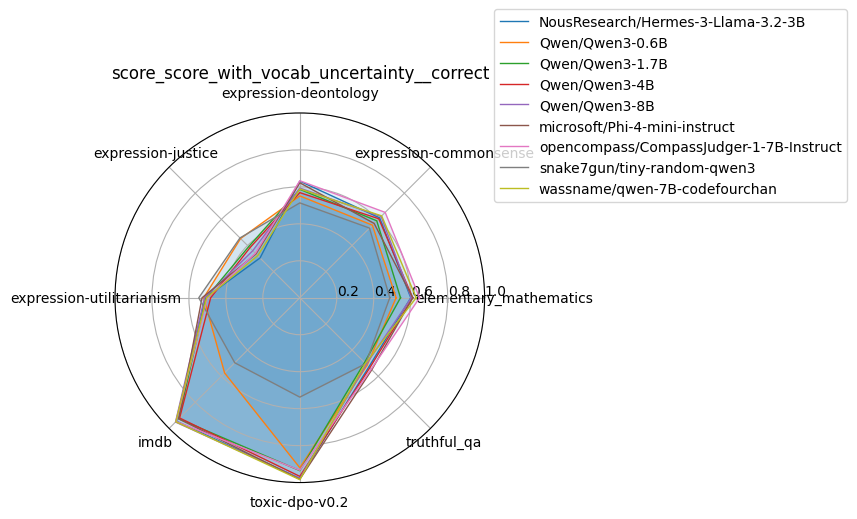

score_score_log_prob_mean__sigmoid


dataset                                  elementary_mathematics  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.561860   
Qwen/Qwen3-0.6B                                        0.501294   
Qwen/Qwen3-1.7B                                        0.519042   
Qwen/Qwen3-4B                                          0.543496   
Qwen/Qwen3-8B                                          0.547391   
microsoft/Phi-4-mini-instruct                          0.571053   
opencompass/CompassJudger-1-7B-Instruct                0.567359   
snake7gun/tiny-random-qwen3                            0.502349   
wassname/qwen-7B-codefourchan                          0.552215   

dataset                                  expression-commonsense  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.594891   
Qwen/Qwen3-0.6B                                        0.545831   
Qwen/Qwen3-1.7B                                        0.572370   
Qwen/Qwen3-4B                                          0.581546   
Qwen/Qwen3-8B                                          0.596871   
microsoft/Phi-4-mini-instruct                          0.567890   
opencompass/CompassJudger-1-7B-Instruct                0.613309   
snake7gun/tiny-random-qwen3                            0.499314   
wassname/qwen-7B-codefourchan                          0.583902   

dataset                                  expression-deontology  \
model                                                            
NousResearch/Hermes-3-Llama-3.2-3B                    0.577990   
Qwen/Qwen3-0.6B                                       0.534444   
Qwen/Qwen3-1.7B                                       0.552216   
Qwen/Qwen3-4B                                         0.568622   
Qwen/Qwen3-8B                                         0.579849   
microsoft/Phi-4-mini-instruct                         0.573280   
opencompass/CompassJudger-1-7B-Instruct               0.586322   
snake7gun/tiny-random-qwen3                           0.492307   
wassname/qwen-7B-codefourchan                         0.559155   

dataset                                  expression-justice  \
model                                                         
NousResearch/Hermes-3-Llama-3.2-3B                 0.369661   
Qwen/Qwen3-0.6B                                    0.450071   
Qwen/Qwen3-1.7B                                    0.412468   
Qwen/Qwen3-4B                                      0.390940   
Qwen/Qwen3-8B                                      0.374800   
microsoft/Phi-4-mini-instruct                      0.380520   
opencompass/CompassJudger-1-7B-Instruct            0.368967   
snake7gun/tiny-random-qwen3                        0.489295   
wassname/qwen-7B-codefourchan                      0.382304   

dataset                                  expression-utilitarianism      imdb  \
model                                                                          
NousResearch/Hermes-3-Llama-3.2-3B                        0.506628  0.938964   
Qwen/Qwen3-0.6B                                           0.520205  0.608776   
Qwen/Qwen3-1.7B                                           0.510885  0.913558   
Qwen/Qwen3-4B                                             0.502349  0.923439   
Qwen/Qwen3-8B                                             0.512100  0.946706   
microsoft/Phi-4-mini-instruct                             0.523522  0.903216   
opencompass/CompassJudger-1-7B-Instruct                   0.509457  0.926974   
snake7gun/tiny-random-qwen3                               0.511615  0.502535   
wassname/qwen-7B-codefourchan                             0.512157  0.919571   

dataset                                  toxic-dpo-v0.2  truthful_qa  
model                                                                 
NousResearch/Hermes-3-Llama-3.2-3B             0.779594     0.525825  
Qwen/Qwen

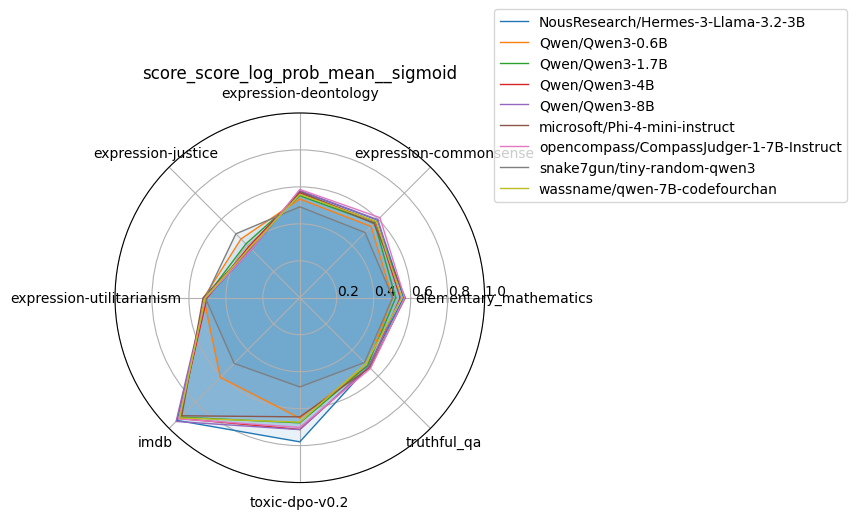

score_score_perplexity_ratio__sigmoid


dataset                                  elementary_mathematics  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.561860   
Qwen/Qwen3-0.6B                                        0.501294   
Qwen/Qwen3-1.7B                                        0.519042   
Qwen/Qwen3-4B                                          0.543496   
Qwen/Qwen3-8B                                          0.547391   
microsoft/Phi-4-mini-instruct                          0.571053   
opencompass/CompassJudger-1-7B-Instruct                0.567359   
snake7gun/tiny-random-qwen3                            0.502349   
wassname/qwen-7B-codefourchan                          0.552215   

dataset                                  expression-commonsense  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.594891   
Qwen/Qwen3-0.6B                                        0.545831   
Qwen/Qwen3-1.7B                                        0.572370   
Qwen/Qwen3-4B                                          0.581546   
Qwen/Qwen3-8B                                          0.596871   
microsoft/Phi-4-mini-instruct                          0.567890   
opencompass/CompassJudger-1-7B-Instruct                0.613309   
snake7gun/tiny-random-qwen3                            0.499314   
wassname/qwen-7B-codefourchan                          0.583902   

dataset                                  expression-deontology  \
model                                                            
NousResearch/Hermes-3-Llama-3.2-3B                    0.577990   
Qwen/Qwen3-0.6B                                       0.534444   
Qwen/Qwen3-1.7B                                       0.552216   
Qwen/Qwen3-4B                                         0.568622   
Qwen/Qwen3-8B                                         0.579849   
microsoft/Phi-4-mini-instruct                         0.573280   
opencompass/CompassJudger-1-7B-Instruct               0.586322   
snake7gun/tiny-random-qwen3                           0.492307   
wassname/qwen-7B-codefourchan                         0.559155   

dataset                                  expression-justice  \
model                                                         
NousResearch/Hermes-3-Llama-3.2-3B                 0.369661   
Qwen/Qwen3-0.6B                                    0.450071   
Qwen/Qwen3-1.7B                                    0.412468   
Qwen/Qwen3-4B                                      0.390940   
Qwen/Qwen3-8B                                      0.374800   
microsoft/Phi-4-mini-instruct                      0.380520   
opencompass/CompassJudger-1-7B-Instruct            0.368967   
snake7gun/tiny-random-qwen3                        0.489295   
wassname/qwen-7B-codefourchan                      0.382304   

dataset                                  expression-utilitarianism      imdb  \
model                                                                          
NousResearch/Hermes-3-Llama-3.2-3B                        0.506628  0.938964   
Qwen/Qwen3-0.6B                                           0.520205  0.608776   
Qwen/Qwen3-1.7B                                           0.510885  0.913558   
Qwen/Qwen3-4B                                             0.502349  0.923439   
Qwen/Qwen3-8B                                             0.512100  0.946706   
microsoft/Phi-4-mini-instruct                             0.523522  0.903216   
opencompass/CompassJudger-1-7B-Instruct                   0.509457  0.926974   
snake7gun/tiny-random-qwen3                               0.511615  0.502535   
wassname/qwen-7B-codefourchan                             0.512157  0.919571   

dataset                                  toxic-dpo-v0.2  truthful_qa  
model                                                                 
NousResearch/Hermes-3-Llama-3.2-3B             0.779594     0.525825  
Qwen/Qwen

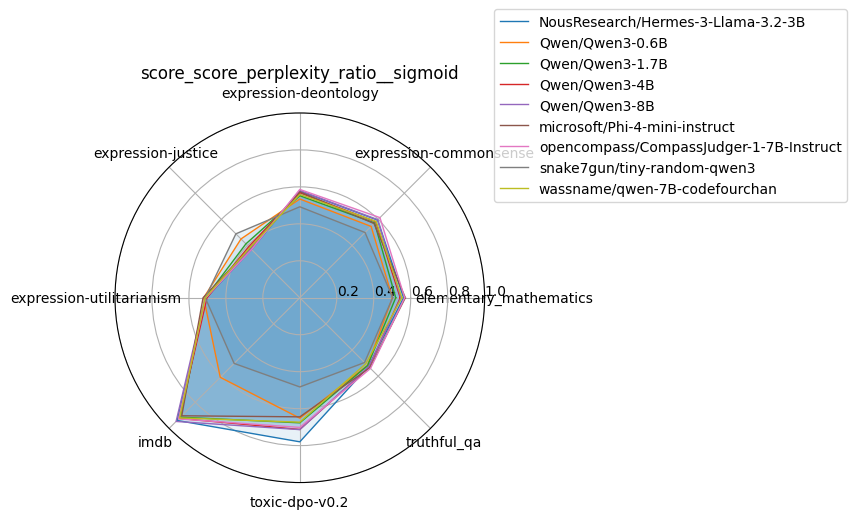

score_score_ipo__sigmoid


dataset                                  elementary_mathematics  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.561860   
Qwen/Qwen3-0.6B                                        0.501294   
Qwen/Qwen3-1.7B                                        0.519042   
Qwen/Qwen3-4B                                          0.543496   
Qwen/Qwen3-8B                                          0.547391   
microsoft/Phi-4-mini-instruct                          0.571053   
opencompass/CompassJudger-1-7B-Instruct                0.567359   
snake7gun/tiny-random-qwen3                            0.502349   
wassname/qwen-7B-codefourchan                          0.552215   

dataset                                  expression-commonsense  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.594891   
Qwen/Qwen3-0.6B                                        0.545831   
Qwen/Qwen3-1.7B                                        0.572370   
Qwen/Qwen3-4B                                          0.581546   
Qwen/Qwen3-8B                                          0.596871   
microsoft/Phi-4-mini-instruct                          0.567890   
opencompass/CompassJudger-1-7B-Instruct                0.613309   
snake7gun/tiny-random-qwen3                            0.499314   
wassname/qwen-7B-codefourchan                          0.583902   

dataset                                  expression-deontology  \
model                                                            
NousResearch/Hermes-3-Llama-3.2-3B                    0.577990   
Qwen/Qwen3-0.6B                                       0.534444   
Qwen/Qwen3-1.7B                                       0.552216   
Qwen/Qwen3-4B                                         0.568622   
Qwen/Qwen3-8B                                         0.579849   
microsoft/Phi-4-mini-instruct                         0.573280   
opencompass/CompassJudger-1-7B-Instruct               0.586322   
snake7gun/tiny-random-qwen3                           0.492307   
wassname/qwen-7B-codefourchan                         0.559155   

dataset                                  expression-justice  \
model                                                         
NousResearch/Hermes-3-Llama-3.2-3B                 0.369661   
Qwen/Qwen3-0.6B                                    0.450071   
Qwen/Qwen3-1.7B                                    0.412468   
Qwen/Qwen3-4B                                      0.390940   
Qwen/Qwen3-8B                                      0.374800   
microsoft/Phi-4-mini-instruct                      0.380520   
opencompass/CompassJudger-1-7B-Instruct            0.368967   
snake7gun/tiny-random-qwen3                        0.489295   
wassname/qwen-7B-codefourchan                      0.382304   

dataset                                  expression-utilitarianism      imdb  \
model                                                                          
NousResearch/Hermes-3-Llama-3.2-3B                        0.506628  0.938964   
Qwen/Qwen3-0.6B                                           0.520205  0.608776   
Qwen/Qwen3-1.7B                                           0.510885  0.913558   
Qwen/Qwen3-4B                                             0.502349  0.923439   
Qwen/Qwen3-8B                                             0.512100  0.946706   
microsoft/Phi-4-mini-instruct                             0.523522  0.903216   
opencompass/CompassJudger-1-7B-Instruct                   0.509457  0.926974   
snake7gun/tiny-random-qwen3                               0.511615  0.502535   
wassname/qwen-7B-codefourchan                             0.512157  0.919571   

dataset                                  toxic-dpo-v0.2  truthful_qa  
model                                                                 
NousResearch/Hermes-3-Llama-3.2-3B             0.779594     0.525825  
Qwen/Qwen

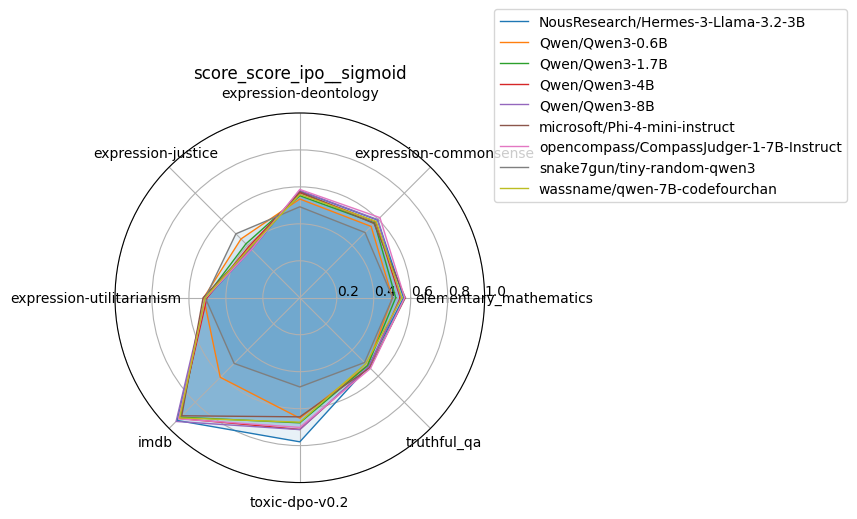

score_score_1st_diverg__sigmoid


dataset                                  elementary_mathematics  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.527201   
Qwen/Qwen3-0.6B                                        0.510234   
Qwen/Qwen3-1.7B                                        0.505920   
Qwen/Qwen3-4B                                          0.511721   
Qwen/Qwen3-8B                                          0.506649   
microsoft/Phi-4-mini-instruct                          0.518327   
opencompass/CompassJudger-1-7B-Instruct                0.515322   
snake7gun/tiny-random-qwen3                            0.516425   
wassname/qwen-7B-codefourchan                          0.515730   

dataset                                  expression-commonsense  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.575063   
Qwen/Qwen3-0.6B                                        0.523423   
Qwen/Qwen3-1.7B                                        0.552210   
Qwen/Qwen3-4B                                          0.559321   
Qwen/Qwen3-8B                                          0.575687   
microsoft/Phi-4-mini-instruct                          0.555027   
opencompass/CompassJudger-1-7B-Instruct                0.575181   
snake7gun/tiny-random-qwen3                            0.507555   
wassname/qwen-7B-codefourchan                          0.566623   

dataset                                  expression-deontology  \
model                                                            
NousResearch/Hermes-3-Llama-3.2-3B                    0.500317   
Qwen/Qwen3-0.6B                                       0.493649   
Qwen/Qwen3-1.7B                                       0.503462   
Qwen/Qwen3-4B                                         0.490175   
Qwen/Qwen3-8B                                         0.490901   
microsoft/Phi-4-mini-instruct                         0.504756   
opencompass/CompassJudger-1-7B-Instruct               0.502318   
snake7gun/tiny-random-qwen3                           0.491038   
wassname/qwen-7B-codefourchan                         0.494078   

dataset                                  expression-justice  \
model                                                         
NousResearch/Hermes-3-Llama-3.2-3B                 0.453372   
Qwen/Qwen3-0.6B                                    0.476900   
Qwen/Qwen3-1.7B                                    0.467560   
Qwen/Qwen3-4B                                      0.454805   
Qwen/Qwen3-8B                                      0.432109   
microsoft/Phi-4-mini-instruct                      0.465693   
opencompass/CompassJudger-1-7B-Instruct            0.458398   
snake7gun/tiny-random-qwen3                        0.495918   
wassname/qwen-7B-codefourchan                      0.445184   

dataset                                  expression-utilitarianism      imdb  \
model                                                                          
NousResearch/Hermes-3-Llama-3.2-3B                        0.476438  0.938964   
Qwen/Qwen3-0.6B                                           0.496860  0.608776   
Qwen/Qwen3-1.7B                                           0.503690  0.913558   
Qwen/Qwen3-4B                                             0.485410  0.923439   
Qwen/Qwen3-8B                                             0.500288  0.946706   
microsoft/Phi-4-mini-instruct                             0.506521  0.903216   
opencompass/CompassJudger-1-7B-Instruct                   0.494666  0.926974   
snake7gun/tiny-random-qwen3                               0.531677  0.502535   
wassname/qwen-7B-codefourchan                             0.492169  0.919571   

dataset                                  toxic-dpo-v0.2  truthful_qa  
model                                                                 
NousResearch/Hermes-3-Llama-3.2-3B             0.396109     0.446389  
Qwen/Qwen

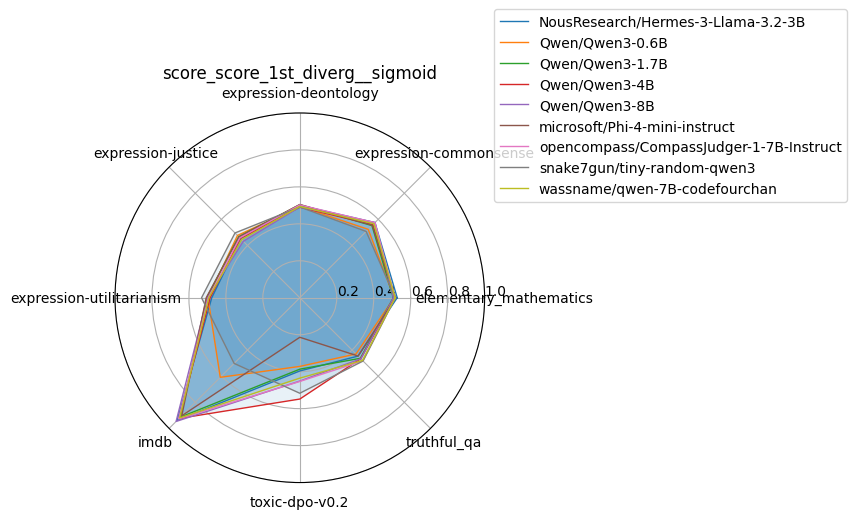

score_score_first_diverging_token__sigmoid


dataset                                  elementary_mathematics  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.527201   
Qwen/Qwen3-0.6B                                        0.510234   
Qwen/Qwen3-1.7B                                        0.505920   
Qwen/Qwen3-4B                                          0.511721   
Qwen/Qwen3-8B                                          0.506649   
microsoft/Phi-4-mini-instruct                          0.518327   
opencompass/CompassJudger-1-7B-Instruct                0.515322   
snake7gun/tiny-random-qwen3                            0.516425   
wassname/qwen-7B-codefourchan                          0.515730   

dataset                                  expression-commonsense  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.575063   
Qwen/Qwen3-0.6B                                        0.523423   
Qwen/Qwen3-1.7B                                        0.552210   
Qwen/Qwen3-4B                                          0.559321   
Qwen/Qwen3-8B                                          0.575687   
microsoft/Phi-4-mini-instruct                          0.555027   
opencompass/CompassJudger-1-7B-Instruct                0.575181   
snake7gun/tiny-random-qwen3                            0.507555   
wassname/qwen-7B-codefourchan                          0.566623   

dataset                                  expression-deontology  \
model                                                            
NousResearch/Hermes-3-Llama-3.2-3B                    0.500317   
Qwen/Qwen3-0.6B                                       0.493649   
Qwen/Qwen3-1.7B                                       0.503462   
Qwen/Qwen3-4B                                         0.490175   
Qwen/Qwen3-8B                                         0.490901   
microsoft/Phi-4-mini-instruct                         0.504756   
opencompass/CompassJudger-1-7B-Instruct               0.502318   
snake7gun/tiny-random-qwen3                           0.491038   
wassname/qwen-7B-codefourchan                         0.494078   

dataset                                  expression-justice  \
model                                                         
NousResearch/Hermes-3-Llama-3.2-3B                 0.453372   
Qwen/Qwen3-0.6B                                    0.476900   
Qwen/Qwen3-1.7B                                    0.467560   
Qwen/Qwen3-4B                                      0.454805   
Qwen/Qwen3-8B                                      0.432109   
microsoft/Phi-4-mini-instruct                      0.465693   
opencompass/CompassJudger-1-7B-Instruct            0.458398   
snake7gun/tiny-random-qwen3                        0.495918   
wassname/qwen-7B-codefourchan                      0.445184   

dataset                                  expression-utilitarianism      imdb  \
model                                                                          
NousResearch/Hermes-3-Llama-3.2-3B                        0.476438  0.938964   
Qwen/Qwen3-0.6B                                           0.496860  0.608776   
Qwen/Qwen3-1.7B                                           0.503690  0.913558   
Qwen/Qwen3-4B                                             0.485410  0.923439   
Qwen/Qwen3-8B                                             0.500288  0.946706   
microsoft/Phi-4-mini-instruct                             0.506521  0.903216   
opencompass/CompassJudger-1-7B-Instruct                   0.494666  0.926974   
snake7gun/tiny-random-qwen3                               0.531677  0.502535   
wassname/qwen-7B-codefourchan                             0.492169  0.919571   

dataset                                  toxic-dpo-v0.2  truthful_qa  
model                                                                 
NousResearch/Hermes-3-Llama-3.2-3B             0.396109     0.446389  
Qwen/Qwen

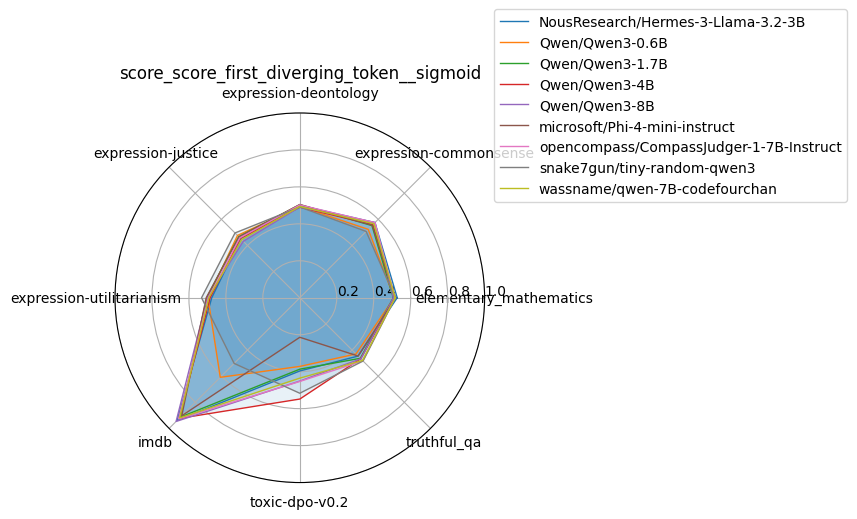

score_score_f_divergence__sigmoid


dataset                                  elementary_mathematics  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.559395   
Qwen/Qwen3-0.6B                                        0.499178   
Qwen/Qwen3-1.7B                                        0.513989   
Qwen/Qwen3-4B                                          0.536010   
Qwen/Qwen3-8B                                          0.539381   
microsoft/Phi-4-mini-instruct                          0.566750   
opencompass/CompassJudger-1-7B-Instruct                0.559889   
snake7gun/tiny-random-qwen3                            0.502350   
wassname/qwen-7B-codefourchan                          0.542592   

dataset                                  expression-commonsense  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.592647   
Qwen/Qwen3-0.6B                                        0.544524   
Qwen/Qwen3-1.7B                                        0.570637   
Qwen/Qwen3-4B                                          0.579066   
Qwen/Qwen3-8B                                          0.594176   
microsoft/Phi-4-mini-instruct                          0.565640   
opencompass/CompassJudger-1-7B-Instruct                0.611340   
snake7gun/tiny-random-qwen3                            0.499314   
wassname/qwen-7B-codefourchan                          0.581421   

dataset                                  expression-deontology  \
model                                                            
NousResearch/Hermes-3-Llama-3.2-3B                    0.573529   
Qwen/Qwen3-0.6B                                       0.532961   
Qwen/Qwen3-1.7B                                       0.549377   
Qwen/Qwen3-4B                                         0.564418   
Qwen/Qwen3-8B                                         0.575125   
microsoft/Phi-4-mini-instruct                         0.569110   
opencompass/CompassJudger-1-7B-Instruct               0.582827   
snake7gun/tiny-random-qwen3                           0.492307   
wassname/qwen-7B-codefourchan                         0.555499   

dataset                                  expression-justice  \
model                                                         
NousResearch/Hermes-3-Llama-3.2-3B                 0.376897   
Qwen/Qwen3-0.6B                                    0.452311   
Qwen/Qwen3-1.7B                                    0.416929   
Qwen/Qwen3-4B                                      0.396602   
Qwen/Qwen3-8B                                      0.381901   
microsoft/Phi-4-mini-instruct                      0.386536   
opencompass/CompassJudger-1-7B-Instruct            0.375620   
snake7gun/tiny-random-qwen3                        0.489295   
wassname/qwen-7B-codefourchan                      0.388236   

dataset                                  expression-utilitarianism      imdb  \
model                                                                          
NousResearch/Hermes-3-Llama-3.2-3B                        0.505898  0.938964   
Qwen/Qwen3-0.6B                                           0.519872  0.608775   
Qwen/Qwen3-1.7B                                           0.510372  0.913558   
Qwen/Qwen3-4B                                             0.501989  0.923439   
Qwen/Qwen3-8B                                             0.511815  0.946706   
microsoft/Phi-4-mini-instruct                             0.522154  0.903216   
opencompass/CompassJudger-1-7B-Instruct                   0.508569  0.926974   
snake7gun/tiny-random-qwen3                               0.511615  0.502535   
wassname/qwen-7B-codefourchan                             0.510852  0.919567   

dataset                                  toxic-dpo-v0.2  truthful_qa  
model                                                                 
NousResearch/Hermes-3-Llama-3.2-3B             0.755343     0.524465  
Qwen/Qwen

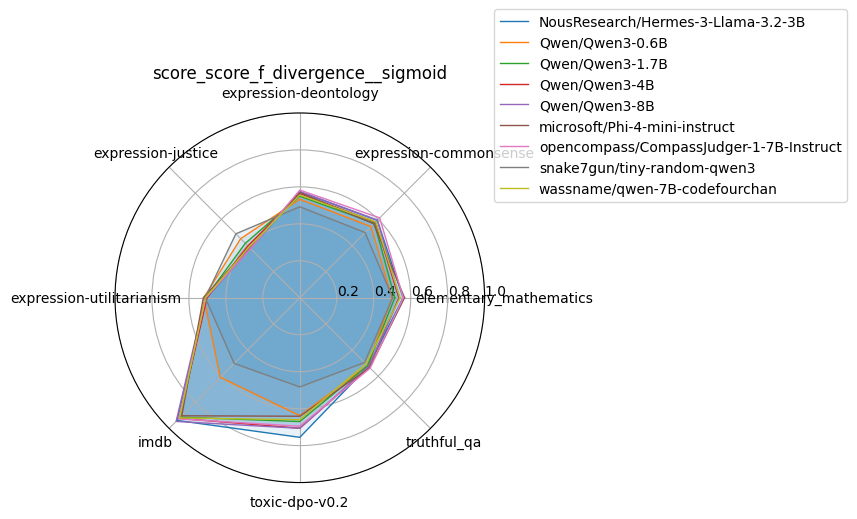

score_score_with_vocab_uncertainty__sigmoid


dataset                                  elementary_mathematics  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.554811   
Qwen/Qwen3-0.6B                                        0.494333   
Qwen/Qwen3-1.7B                                        0.505840   
Qwen/Qwen3-4B                                          0.532551   
Qwen/Qwen3-8B                                          0.535875   
microsoft/Phi-4-mini-instruct                          0.557127   
opencompass/CompassJudger-1-7B-Instruct                0.559678   
snake7gun/tiny-random-qwen3                            0.500353   
wassname/qwen-7B-codefourchan                          0.534037   

dataset                                  expression-commonsense  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.579533   
Qwen/Qwen3-0.6B                                        0.540232   
Qwen/Qwen3-1.7B                                        0.567786   
Qwen/Qwen3-4B                                          0.569320   
Qwen/Qwen3-8B                                          0.586945   
microsoft/Phi-4-mini-instruct                          0.560030   
opencompass/CompassJudger-1-7B-Instruct                0.606536   
snake7gun/tiny-random-qwen3                            0.504102   
wassname/qwen-7B-codefourchan                          0.574956   

dataset                                  expression-deontology  \
model                                                            
NousResearch/Hermes-3-Llama-3.2-3B                    0.559577   
Qwen/Qwen3-0.6B                                       0.521657   
Qwen/Qwen3-1.7B                                       0.540649   
Qwen/Qwen3-4B                                         0.545614   
Qwen/Qwen3-8B                                         0.556097   
microsoft/Phi-4-mini-instruct                         0.550604   
opencompass/CompassJudger-1-7B-Instruct               0.570233   
snake7gun/tiny-random-qwen3                           0.495391   
wassname/qwen-7B-codefourchan                         0.543746   

dataset                                  expression-justice  \
model                                                         
NousResearch/Hermes-3-Llama-3.2-3B                 0.403616   
Qwen/Qwen3-0.6B                                    0.470505   
Qwen/Qwen3-1.7B                                    0.435761   
Qwen/Qwen3-4B                                      0.420933   
Qwen/Qwen3-8B                                      0.406665   
microsoft/Phi-4-mini-instruct                      0.413805   
opencompass/CompassJudger-1-7B-Instruct            0.394081   
snake7gun/tiny-random-qwen3                        0.486838   
wassname/qwen-7B-codefourchan                      0.412751   

dataset                                  expression-utilitarianism      imdb  \
model                                                                          
NousResearch/Hermes-3-Llama-3.2-3B                        0.505476  0.938240   
Qwen/Qwen3-0.6B                                           0.514285  0.564112   
Qwen/Qwen3-1.7B                                           0.507221  0.911201   
Qwen/Qwen3-4B                                             0.499018  0.919104   
Qwen/Qwen3-8B                                             0.513054  0.945375   
microsoft/Phi-4-mini-instruct                             0.515789  0.901330   
opencompass/CompassJudger-1-7B-Instruct                   0.507331  0.926549   
snake7gun/tiny-random-qwen3                               0.507075  0.504885   
wassname/qwen-7B-codefourchan                             0.504677  0.918343   

dataset                                  toxic-dpo-v0.2  truthful_qa  
model                                                                 
NousResearch/Hermes-3-Llama-3.2-3B             0.684749     0.508722  
Qwen/Qwen

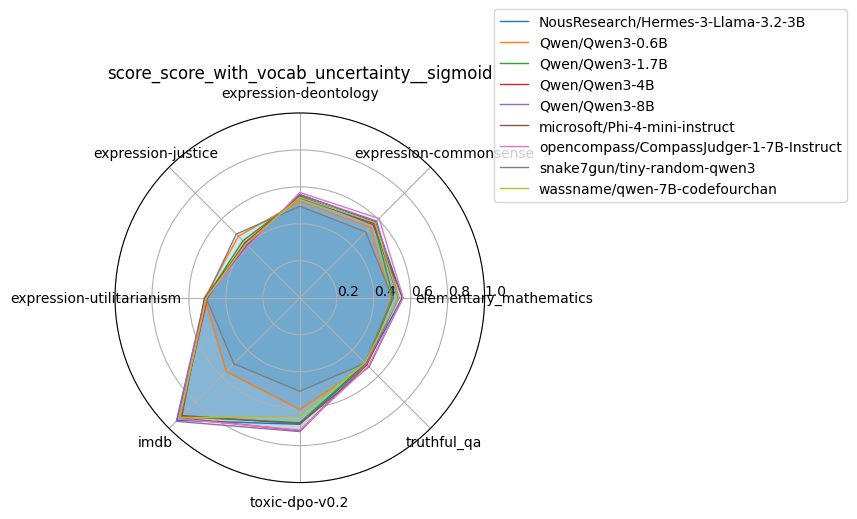

score_score_power_mean__sigmoid


dataset                                  elementary_mathematics  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.544443   
Qwen/Qwen3-0.6B                                        0.502694   
Qwen/Qwen3-1.7B                                        0.524131   
Qwen/Qwen3-4B                                          0.551502   
Qwen/Qwen3-8B                                          0.552664   
microsoft/Phi-4-mini-instruct                          0.548146   
opencompass/CompassJudger-1-7B-Instruct                0.573009   
snake7gun/tiny-random-qwen3                            0.492627   
wassname/qwen-7B-codefourchan                          0.567047   

dataset                                  expression-commonsense  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.553297   
Qwen/Qwen3-0.6B                                        0.533563   
Qwen/Qwen3-1.7B                                        0.543982   
Qwen/Qwen3-4B                                          0.549308   
Qwen/Qwen3-8B                                          0.554561   
microsoft/Phi-4-mini-instruct                          0.550397   
opencompass/CompassJudger-1-7B-Instruct                0.561685   
snake7gun/tiny-random-qwen3                            0.494085   
wassname/qwen-7B-codefourchan                          0.546972   

dataset                                  expression-deontology  \
model                                                            
NousResearch/Hermes-3-Llama-3.2-3B                    0.556845   
Qwen/Qwen3-0.6B                                       0.521825   
Qwen/Qwen3-1.7B                                       0.528556   
Qwen/Qwen3-4B                                         0.544524   
Qwen/Qwen3-8B                                         0.554652   
microsoft/Phi-4-mini-instruct                         0.553888   
opencompass/CompassJudger-1-7B-Instruct               0.548733   
snake7gun/tiny-random-qwen3                           0.487142   
wassname/qwen-7B-codefourchan                         0.544537   

dataset                                  expression-justice  \
model                                                         
NousResearch/Hermes-3-Llama-3.2-3B                 0.412509   
Qwen/Qwen3-0.6B                                    0.468993   
Qwen/Qwen3-1.7B                                    0.447000   
Qwen/Qwen3-4B                                      0.432866   
Qwen/Qwen3-8B                                      0.422605   
microsoft/Phi-4-mini-instruct                      0.419837   
opencompass/CompassJudger-1-7B-Instruct            0.407902   
snake7gun/tiny-random-qwen3                        0.483696   
wassname/qwen-7B-codefourchan                      0.423091   

dataset                                  expression-utilitarianism      imdb  \
model                                                                          
NousResearch/Hermes-3-Llama-3.2-3B                        0.507253  0.938964   
Qwen/Qwen3-0.6B                                           0.505814  0.608776   
Qwen/Qwen3-1.7B                                           0.502061  0.913558   
Qwen/Qwen3-4B                                             0.502684  0.923439   
Qwen/Qwen3-8B                                             0.503688  0.946706   
microsoft/Phi-4-mini-instruct                             0.511881  0.903216   
opencompass/CompassJudger-1-7B-Instruct                   0.509123  0.926974   
snake7gun/tiny-random-qwen3                               0.506195  0.502535   
wassname/qwen-7B-codefourchan                             0.511795  0.919571   

dataset                                  toxic-dpo-v0.2  truthful_qa  
model                                                                 
NousResearch/Hermes-3-Llama-3.2-3B             0.653689     0.510435  
Qwen/Qwen

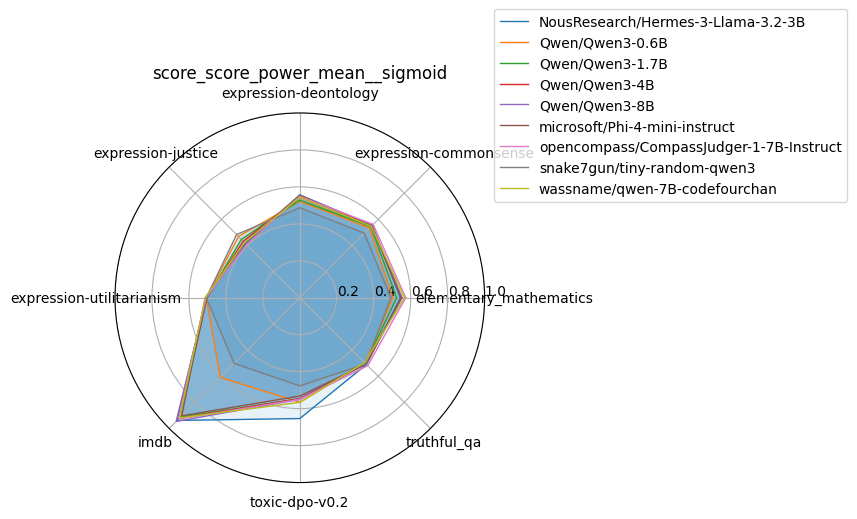

score_score_percentile__sigmoid


dataset                                  elementary_mathematics  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.551872   
Qwen/Qwen3-0.6B                                        0.499944   
Qwen/Qwen3-1.7B                                        0.517738   
Qwen/Qwen3-4B                                          0.532582   
Qwen/Qwen3-8B                                          0.530669   
microsoft/Phi-4-mini-instruct                          0.557578   
opencompass/CompassJudger-1-7B-Instruct                0.556765   
snake7gun/tiny-random-qwen3                            0.492254   
wassname/qwen-7B-codefourchan                          0.554126   

dataset                                  expression-commonsense  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.553322   
Qwen/Qwen3-0.6B                                        0.534933   
Qwen/Qwen3-1.7B                                        0.539616   
Qwen/Qwen3-4B                                          0.545228   
Qwen/Qwen3-8B                                          0.552057   
microsoft/Phi-4-mini-instruct                          0.550354   
opencompass/CompassJudger-1-7B-Instruct                0.558240   
snake7gun/tiny-random-qwen3                            0.500610   
wassname/qwen-7B-codefourchan                          0.547547   

dataset                                  expression-deontology  \
model                                                            
NousResearch/Hermes-3-Llama-3.2-3B                    0.567545   
Qwen/Qwen3-0.6B                                       0.528593   
Qwen/Qwen3-1.7B                                       0.532985   
Qwen/Qwen3-4B                                         0.551848   
Qwen/Qwen3-8B                                         0.566084   
microsoft/Phi-4-mini-instruct                         0.559249   
opencompass/CompassJudger-1-7B-Instruct               0.565652   
snake7gun/tiny-random-qwen3                           0.493139   
wassname/qwen-7B-codefourchan                         0.554104   

dataset                                  expression-justice  \
model                                                         
NousResearch/Hermes-3-Llama-3.2-3B                 0.405158   
Qwen/Qwen3-0.6B                                    0.465640   
Qwen/Qwen3-1.7B                                    0.438741   
Qwen/Qwen3-4B                                      0.420346   
Qwen/Qwen3-8B                                      0.425090   
microsoft/Phi-4-mini-instruct                      0.416224   
opencompass/CompassJudger-1-7B-Instruct            0.406407   
snake7gun/tiny-random-qwen3                        0.494348   
wassname/qwen-7B-codefourchan                      0.428240   

dataset                                  expression-utilitarianism      imdb  \
model                                                                          
NousResearch/Hermes-3-Llama-3.2-3B                        0.515927  0.938964   
Qwen/Qwen3-0.6B                                           0.506684  0.608776   
Qwen/Qwen3-1.7B                                           0.505403  0.913558   
Qwen/Qwen3-4B                                             0.511348  0.923439   
Qwen/Qwen3-8B                                             0.512390  0.946706   
microsoft/Phi-4-mini-instruct                             0.517235  0.903216   
opencompass/CompassJudger-1-7B-Instruct                   0.517101  0.926974   
snake7gun/tiny-random-qwen3                               0.514168  0.502535   
wassname/qwen-7B-codefourchan                             0.516336  0.919571   

dataset                                  toxic-dpo-v0.2  truthful_qa  
model                                                                 
NousResearch/Hermes-3-Llama-3.2-3B             0.579612     0.504252  
Qwen/Qwen

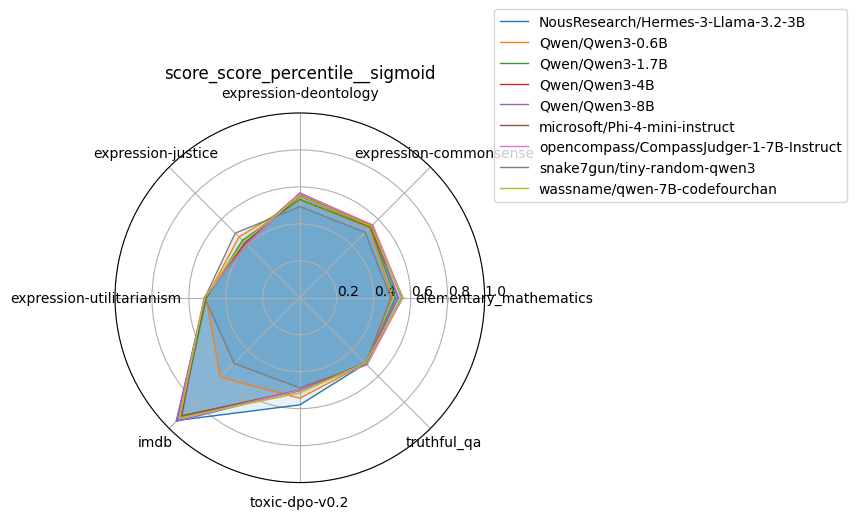

score_score_rank_based__sigmoid


dataset                                  elementary_mathematics  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.542960   
Qwen/Qwen3-0.6B                                        0.493734   
Qwen/Qwen3-1.7B                                        0.505314   
Qwen/Qwen3-4B                                          0.516228   
Qwen/Qwen3-8B                                          0.516438   
microsoft/Phi-4-mini-instruct                          0.537713   
opencompass/CompassJudger-1-7B-Instruct                0.532460   
snake7gun/tiny-random-qwen3                            0.499466   
wassname/qwen-7B-codefourchan                          0.525179   

dataset                                  expression-commonsense  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.565958   
Qwen/Qwen3-0.6B                                        0.533642   
Qwen/Qwen3-1.7B                                        0.551935   
Qwen/Qwen3-4B                                          0.556642   
Qwen/Qwen3-8B                                          0.562882   
microsoft/Phi-4-mini-instruct                          0.550617   
opencompass/CompassJudger-1-7B-Instruct                0.584107   
snake7gun/tiny-random-qwen3                            0.498880   
wassname/qwen-7B-codefourchan                          0.565738   

dataset                                  expression-deontology  \
model                                                            
NousResearch/Hermes-3-Llama-3.2-3B                    0.557501   
Qwen/Qwen3-0.6B                                       0.526117   
Qwen/Qwen3-1.7B                                       0.537626   
Qwen/Qwen3-4B                                         0.548125   
Qwen/Qwen3-8B                                         0.556197   
microsoft/Phi-4-mini-instruct                         0.554705   
opencompass/CompassJudger-1-7B-Instruct               0.559731   
snake7gun/tiny-random-qwen3                           0.495902   
wassname/qwen-7B-codefourchan                         0.542817   

dataset                                  expression-justice  \
model                                                         
NousResearch/Hermes-3-Llama-3.2-3B                 0.409518   
Qwen/Qwen3-0.6B                                    0.463125   
Qwen/Qwen3-1.7B                                    0.438045   
Qwen/Qwen3-4B                                      0.424145   
Qwen/Qwen3-8B                                      0.415833   
microsoft/Phi-4-mini-instruct                      0.417482   
opencompass/CompassJudger-1-7B-Instruct            0.409600   
snake7gun/tiny-random-qwen3                        0.492742   
wassname/qwen-7B-codefourchan                      0.415835   

dataset                                  expression-utilitarianism      imdb  \
model                                                                          
NousResearch/Hermes-3-Llama-3.2-3B                        0.503154  0.880382   
Qwen/Qwen3-0.6B                                           0.513966  0.570885   
Qwen/Qwen3-1.7B                                           0.507863  0.855245   
Qwen/Qwen3-4B                                             0.504204  0.871692   
Qwen/Qwen3-8B                                             0.507926  0.886682   
microsoft/Phi-4-mini-instruct                             0.513695  0.815242   
opencompass/CompassJudger-1-7B-Instruct                   0.504280  0.890388   
snake7gun/tiny-random-qwen3                               0.506648  0.500403   
wassname/qwen-7B-codefourchan                             0.503522  0.869123   

dataset                                  toxic-dpo-v0.2  truthful_qa  
model                                                                 
NousResearch/Hermes-3-Llama-3.2-3B             0.670520     0.515592  
Qwen/Qwen

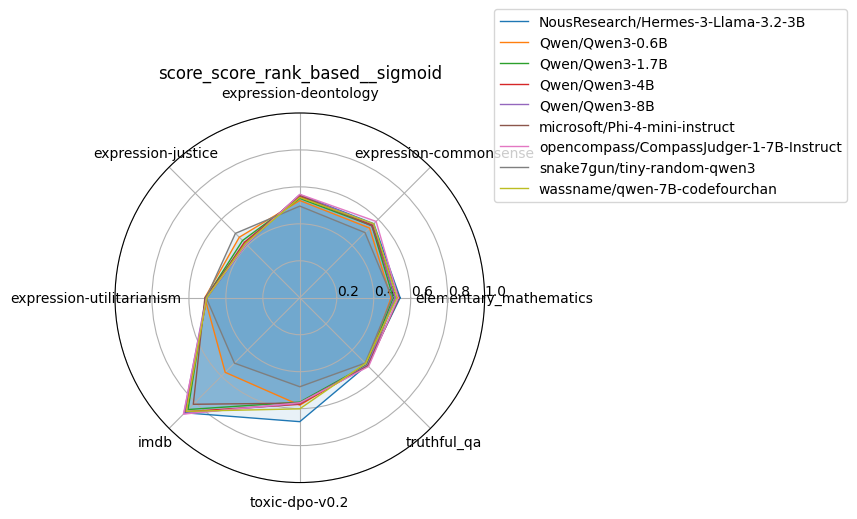

score_score_confidence_weighted__correct


dataset                                  elementary_mathematics  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.584656   
Qwen/Qwen3-0.6B                                        0.531746   
Qwen/Qwen3-1.7B                                        0.574074   
Qwen/Qwen3-4B                                          0.600529   
Qwen/Qwen3-8B                                          0.626984   
microsoft/Phi-4-mini-instruct                          0.560847   
opencompass/CompassJudger-1-7B-Instruct                0.626984   
snake7gun/tiny-random-qwen3                            0.462963   
wassname/qwen-7B-codefourchan                          0.669312   

dataset                                  expression-commonsense  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.580000   
Qwen/Qwen3-0.6B                                        0.535556   
Qwen/Qwen3-1.7B                                        0.540000   
Qwen/Qwen3-4B                                          0.595556   
Qwen/Qwen3-8B                                          0.582222   
microsoft/Phi-4-mini-instruct                          0.560000   
opencompass/CompassJudger-1-7B-Instruct                0.562222   
snake7gun/tiny-random-qwen3                            0.482222   
wassname/qwen-7B-codefourchan                          0.582222   

dataset                                  expression-deontology  \
model                                                            
NousResearch/Hermes-3-Llama-3.2-3B                    0.566667   
Qwen/Qwen3-0.6B                                       0.484444   
Qwen/Qwen3-1.7B                                       0.515556   
Qwen/Qwen3-4B                                         0.555556   
Qwen/Qwen3-8B                                         0.571111   
microsoft/Phi-4-mini-instruct                         0.571111   
opencompass/CompassJudger-1-7B-Instruct               0.524444   
snake7gun/tiny-random-qwen3                           0.495556   
wassname/qwen-7B-codefourchan                         0.548889   

dataset                                  expression-justice  \
model                                                         
NousResearch/Hermes-3-Llama-3.2-3B                 0.393333   
Qwen/Qwen3-0.6B                                    0.460000   
Qwen/Qwen3-1.7B                                    0.395556   
Qwen/Qwen3-4B                                      0.397778   
Qwen/Qwen3-8B                                      0.364444   
microsoft/Phi-4-mini-instruct                      0.402222   
opencompass/CompassJudger-1-7B-Instruct            0.397778   
snake7gun/tiny-random-qwen3                        0.464444   
wassname/qwen-7B-codefourchan                      0.424444   

dataset                                  expression-utilitarianism      imdb  \
model                                                                          
NousResearch/Hermes-3-Llama-3.2-3B                        0.520000  0.946667   
Qwen/Qwen3-0.6B                                           0.524444  0.631111   
Qwen/Qwen3-1.7B                                           0.513333  0.373333   
Qwen/Qwen3-4B                                             0.508889  0.191111   
Qwen/Qwen3-8B                                             0.508889  0.200000   
microsoft/Phi-4-mini-instruct                             0.542222  0.086667   
opencompass/CompassJudger-1-7B-Instruct                   0.531111  0.737778   
snake7gun/tiny-random-qwen3                               0.522222  0.504444   
wassname/qwen-7B-codefourchan                             0.535556  0.948889   

dataset                                  toxic-dpo-v0.2  truthful_qa  
model                                                                 
NousResearch/Hermes-3-Llama-3.2-3B             0.984444     0.500000  
Qwen/Qwen

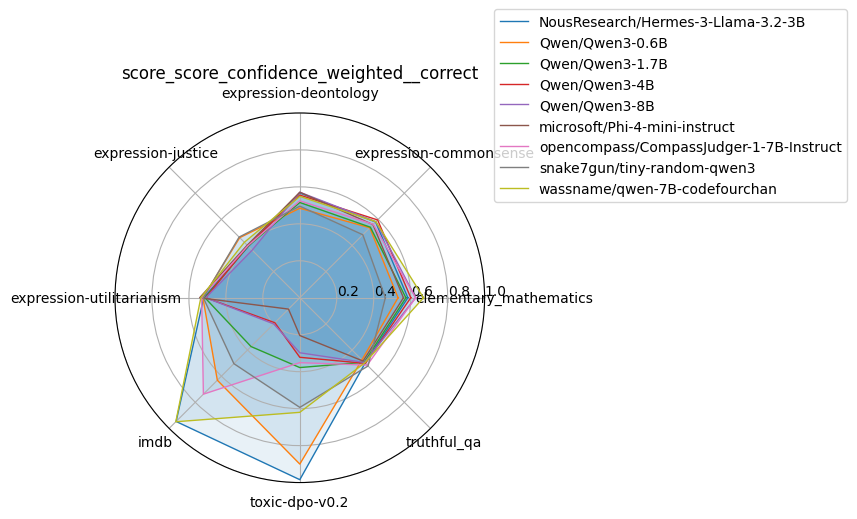

score_score_confidence_weighted__sigmoid


dataset                                  elementary_mathematics  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.533920   
Qwen/Qwen3-0.6B                                        0.500457   
Qwen/Qwen3-1.7B                                        0.510734   
Qwen/Qwen3-4B                                          0.530088   
Qwen/Qwen3-8B                                          0.532107   
microsoft/Phi-4-mini-instruct                          0.523973   
opencompass/CompassJudger-1-7B-Instruct                0.546754   
snake7gun/tiny-random-qwen3                            0.487075   
wassname/qwen-7B-codefourchan                          0.543422   

dataset                                  expression-commonsense  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.529182   
Qwen/Qwen3-0.6B                                        0.517178   
Qwen/Qwen3-1.7B                                        0.525672   
Qwen/Qwen3-4B                                          0.529371   
Qwen/Qwen3-8B                                          0.530964   
microsoft/Phi-4-mini-instruct                          0.525975   
opencompass/CompassJudger-1-7B-Instruct                0.538598   
snake7gun/tiny-random-qwen3                            0.484875   
wassname/qwen-7B-codefourchan                          0.523515   

dataset                                  expression-deontology  \
model                                                            
NousResearch/Hermes-3-Llama-3.2-3B                    0.518609   
Qwen/Qwen3-0.6B                                       0.504652   
Qwen/Qwen3-1.7B                                       0.505081   
Qwen/Qwen3-4B                                         0.513644   
Qwen/Qwen3-8B                                         0.515703   
microsoft/Phi-4-mini-instruct                         0.525254   
opencompass/CompassJudger-1-7B-Instruct               0.504834   
snake7gun/tiny-random-qwen3                           0.492355   
wassname/qwen-7B-codefourchan                         0.518976   

dataset                                  expression-justice  \
model                                                         
NousResearch/Hermes-3-Llama-3.2-3B                 0.461571   
Qwen/Qwen3-0.6B                                    0.475498   
Qwen/Qwen3-1.7B                                    0.474409   
Qwen/Qwen3-4B                                      0.470762   
Qwen/Qwen3-8B                                      0.461626   
microsoft/Phi-4-mini-instruct                      0.463178   
opencompass/CompassJudger-1-7B-Instruct            0.461109   
snake7gun/tiny-random-qwen3                        0.477060   
wassname/qwen-7B-codefourchan                      0.464418   

dataset                                  expression-utilitarianism      imdb  \
model                                                                          
NousResearch/Hermes-3-Llama-3.2-3B                        0.505838  0.938962   
Qwen/Qwen3-0.6B                                           0.506322  0.608776   
Qwen/Qwen3-1.7B                                           0.506711  0.361051   
Qwen/Qwen3-4B                                             0.506216  0.188608   
Qwen/Qwen3-8B                                             0.500247  0.198181   
microsoft/Phi-4-mini-instruct                             0.509843  0.098274   
opencompass/CompassJudger-1-7B-Instruct                   0.508835  0.721450   
snake7gun/tiny-random-qwen3                               0.505532  0.503176   
wassname/qwen-7B-codefourchan                             0.512066  0.919571   

dataset                                  toxic-dpo-v0.2  truthful_qa  
model                                                                 
NousResearch/Hermes-3-Llama-3.2-3B             0.550710     0.495857  
Qwen/Qwen

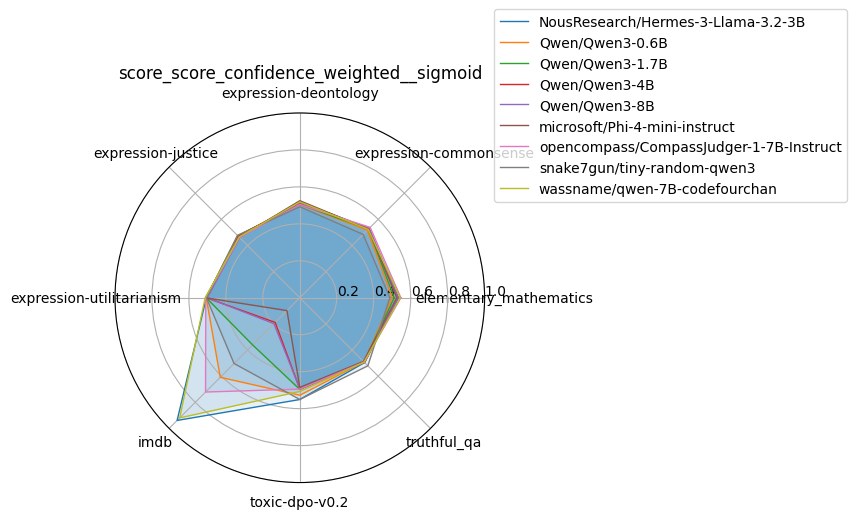

In [129]:

cols = df_metrics.index#.tolist()
for c in cols:
    # df2['correct2'] = df2[c]>0
    df_agg = df2.pivot_table(index='model', columns='dataset', values=c)
    print(c)
    display(df_agg)
    radar_plot(df_agg.T)
    plt.legend(loc='upper right', bbox_to_anchor=(2, 1.3))
    plt.title(c)
    plt.show()


## view logs

In [137]:
# only show the ones in [0, 1] range
df_metrics2 = res[(res['min'] < 0) | (res['max'] > 1)].copy()

# but finite
df_metrics2 = df_metrics2[~df_metrics2['min'].isin([np.inf, -np.inf])]

df_metrics2['overall'] = df_metrics2['random_calibration'] + df_metrics2['discrimination']
df_metrics2 = df_metrics2.sort_values('random_calibration', ascending=False)

# they can't have rejected or chosen in their index name
df_metrics2 = df_metrics2[~df_metrics2.index.str.contains('rejected|chosen')]
df_metrics2

overall  imdb_mean  \
score_score_percentile__log_ratio               0.757836   5.048985   
score_vocab_information_weighted__log_ratio     0.940771   5.729757   
score_vocab_precision_weighted__log_ratio       0.940771   5.729757   
score_score_confidence_weighted__log_ratio      5.963663  -2.607820   
score_score_with_vocab_uncertainty__log_ratio   0.675411   4.869098   
score_score_first_diverging_token__log_ratio   18.619928   5.048985   
score_score_1st_diverg__log_ratio              18.619928   5.048985   
score_score_log_prob_mean__log_ratio            0.439108   5.048985   
score_score_ipo__log_ratio                      0.439108   5.048985   
score_score_perplexity_ratio__log_ratio         0.439108   5.048985   
score_score_f_divergence__log_ratio             0.441321   5.048957   
score_score_rank_based__log_ratio               0.248215   2.196694   
score_score_alpha_divergence__log_ratio        63.031733  -2.524492   
score_score_position_weighted__log_ratio        2.727471   5.048985   
score_score_entropy_weighted__log_ratio        -0.591039  -0.298950   
score_score_cumulative_weighted__log_ratio      8.748389   5.048985   
score_score_preferences__log_ratio              9.254779   5.048985   
score_score_log_prob_sum__log_ratio             9.254779   5.048985   

                                               random_calibration  \
score_score_percentile__log_ratio                       -0.246032   
score_vocab_information_weighted__log_ratio             -0.246196   
score_vocab_precision_weighted__log_ratio               -0.246196   
score_score_confidence_weighted__log_ratio              -0.288103   
score_score_with_vocab_uncertainty__log_ratio           -0.302862   
score_score_first_diverging_token__log_ratio            -0.303649   
score_score_1st_diverg__log_ratio                       -0.303649   
score_score_log_prob_mean__log_ratio                    -0.368102   
score_score_ipo__log_ratio                              -0.368102   
score_score_perplexity_ratio__log_ratio                 -0.368102   
score_score_f_divergence__log_ratio                     -0.368108   
score_score_rank_based__log_ratio                       -0.564676   
score_score_alpha_divergence__log_ratio                 -0.569871   
score_score_position_weighted__log_ratio                -0.599870   
score_score_entropy_weighted__log_ratio                 -1.512854   
score_score_cumulative_weighted__log_ratio              -1.793635   
score_score_preferences__log_ratio                      -1.794274   
score_score_log_prob_sum__log_ratio                     -1.794274   

                                               discrimination  toxic_spread  \
score_score_percentile__log_ratio                    1.003868      0.377734   
score_vocab_information_weighted__log_ratio          1.186967      1.958364   
score_vocab_precision_weighted__log_ratio            1.186967      1.958364   
score_score_confidence_weighted__log_ratio           6.251766      0.304653   
score_score_with_vocab_uncertainty__log_ratio        0.978273      0.995407   
score_score_first_diverging_token__log_ratio        18.923576      4.186597   
score_score_1st_diverg__log_ratio                   18.923576      4.186597   
score_score_log_prob_mean__log_ratio                 0.807210      1.401224   
score_score_ipo__log_ratio                           0.807210      1.401224   
score_score_perplexity_ratio__log_ratio              0.807210      1.401224   
score_score_f_divergence__log_ratio                  0.809429      1.249020   
score_score_rank_based__log_ratio                    0.812891      0.798145   
score_score_alpha_divergence__log_ratio             63.601604      2.029521   
score_score_position_weighted__log_ratio             3.327341      1.752511   
score_score_entropy_weighted__log_ratio              0.921816      0.660329   
score_score_cumulative_weighted__log_ratio          10.542025   1465.439331   
score_score_preferences__log_ratio          

In [138]:
logscores = df_metrics2.index # [c for c in res.index if 'log_score' in c]

score_score_percentile__log_ratio


dataset                                  elementary_mathematics  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.249965   
Qwen/Qwen3-0.6B                                       -0.114749   
Qwen/Qwen3-1.7B                                        0.027274   
Qwen/Qwen3-4B                                          0.158564   
Qwen/Qwen3-8B                                          0.131105   
microsoft/Phi-4-mini-instruct                          0.322471   
opencompass/CompassJudger-1-7B-Instruct                0.299127   
snake7gun/tiny-random-qwen3                           -0.059462   
wassname/qwen-7B-codefourchan                          0.169478   

dataset                                  expression-commonsense  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.388088   
Qwen/Qwen3-0.6B                                        0.226734   
Qwen/Qwen3-1.7B                                        0.323967   
Qwen/Qwen3-4B                                          0.381820   
Qwen/Qwen3-8B                                          0.445807   
microsoft/Phi-4-mini-instruct                          0.376353   
opencompass/CompassJudger-1-7B-Instruct                0.511160   
snake7gun/tiny-random-qwen3                            0.009236   
wassname/qwen-7B-codefourchan                          0.315146   

dataset                                  expression-deontology  \
model                                                            
NousResearch/Hermes-3-Llama-3.2-3B                    0.322070   
Qwen/Qwen3-0.6B                                       0.127400   
Qwen/Qwen3-1.7B                                       0.152310   
Qwen/Qwen3-4B                                         0.251230   
Qwen/Qwen3-8B                                         0.329063   
microsoft/Phi-4-mini-instruct                         0.288676   
opencompass/CompassJudger-1-7B-Instruct               0.340572   
snake7gun/tiny-random-qwen3                          -0.031528   
wassname/qwen-7B-codefourchan                         0.240084   

dataset                                  expression-justice  \
model                                                         
NousResearch/Hermes-3-Llama-3.2-3B                -0.515001   
Qwen/Qwen3-0.6B                                   -0.201449   
Qwen/Qwen3-1.7B                                   -0.336589   
Qwen/Qwen3-4B                                     -0.458339   
Qwen/Qwen3-8B                                     -0.432466   
microsoft/Phi-4-mini-instruct                     -0.457537   
opencompass/CompassJudger-1-7B-Instruct           -0.579281   
snake7gun/tiny-random-qwen3                       -0.038889   
wassname/qwen-7B-codefourchan                     -0.368896   

dataset                                  expression-utilitarianism      imdb  \
model                                                                          
NousResearch/Hermes-3-Llama-3.2-3B                        0.099741  5.453472   
Qwen/Qwen3-0.6B                                           0.055914  0.559861   
Qwen/Qwen3-1.7B                                           0.048315  7.229306   
Qwen/Qwen3-4B                                             0.067392  7.004861   
Qwen/Qwen3-8B                                             0.086989  6.744583   
microsoft/Phi-4-mini-instruct                             0.112779  4.834306   
opencompass/CompassJudger-1-7B-Instruct                   0.133617  5.105972   
snake7gun/tiny-random-qwen3                               0.096701  0.026875   
wassname/qwen-7B-codefourchan                             0.100275  3.459514   

dataset                                  toxic-dpo-v0.2  truthful_qa  
model                                                                 
NousResearch/Hermes-3-Llama-3.2-3B             0.323949     0.037811  
Qwen/Qwen

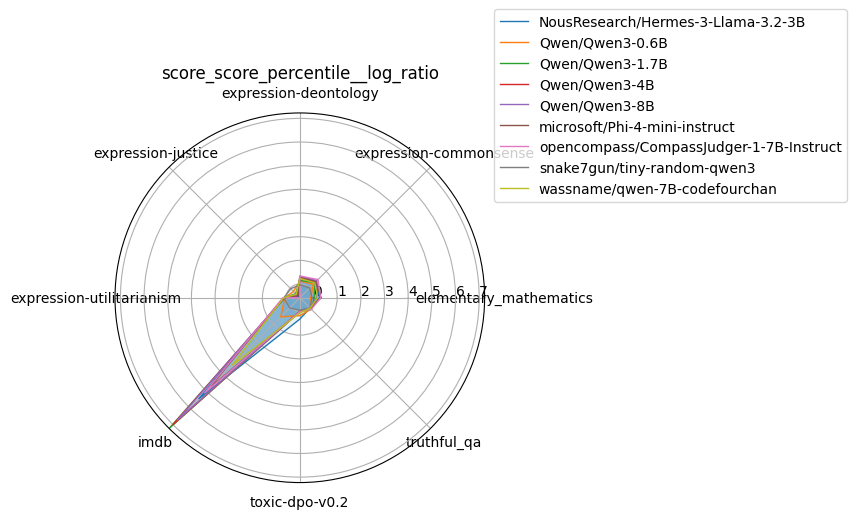

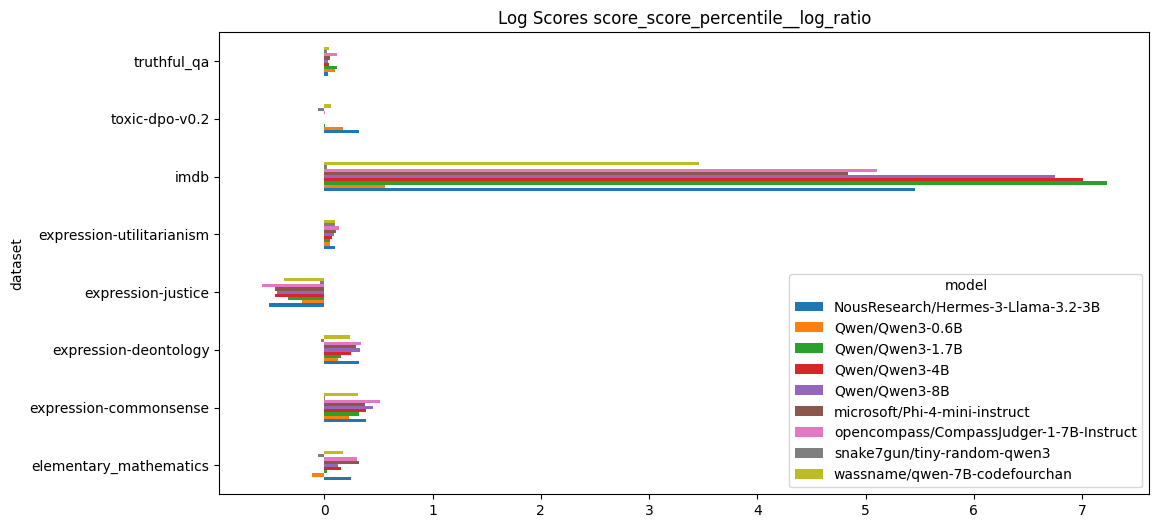

score_vocab_information_weighted__log_ratio


dataset                                  elementary_mathematics  \
model                                                             
Qwen/Qwen3-1.7B                                        0.060156   
Qwen/Qwen3-4B                                          0.163683   
Qwen/Qwen3-8B                                          0.315430   
microsoft/Phi-4-mini-instruct                          0.381187   
opencompass/CompassJudger-1-7B-Instruct                0.449171   
snake7gun/tiny-random-qwen3                           -0.016114   
wassname/qwen-7B-codefourchan                          0.287350   

dataset                                  expression-commonsense  \
model                                                             
Qwen/Qwen3-1.7B                                        0.356258   
Qwen/Qwen3-4B                                          0.351354   
Qwen/Qwen3-8B                                          0.697273   
microsoft/Phi-4-mini-instruct                          0.425044   
opencompass/CompassJudger-1-7B-Instruct                0.849739   
snake7gun/tiny-random-qwen3                           -0.024012   
wassname/qwen-7B-codefourchan                          0.474421   

dataset                                  expression-deontology  \
model                                                            
Qwen/Qwen3-1.7B                                       0.261876   
Qwen/Qwen3-4B                                         0.236106   
Qwen/Qwen3-8B                                         0.310800   
microsoft/Phi-4-mini-instruct                         0.290777   
opencompass/CompassJudger-1-7B-Instruct               0.399842   
snake7gun/tiny-random-qwen3                          -0.024755   
wassname/qwen-7B-codefourchan                         0.184380   

dataset                                  expression-justice  \
model                                                         
Qwen/Qwen3-1.7B                                   -0.401589   
Qwen/Qwen3-4B                                     -0.323542   
Qwen/Qwen3-8B                                     -0.359356   
microsoft/Phi-4-mini-instruct                     -0.590336   
opencompass/CompassJudger-1-7B-Instruct           -0.619781   
snake7gun/tiny-random-qwen3                       -0.053974   
wassname/qwen-7B-codefourchan                     -0.388185   

dataset                                  expression-utilitarianism      imdb  \
model                                                                          
Qwen/Qwen3-1.7B                                           0.107713  7.229306   
Qwen/Qwen3-4B                                             0.102930  7.004861   
Qwen/Qwen3-8B                                             0.142701  6.744583   
microsoft/Phi-4-mini-instruct                            -0.064843  4.834306   
opencompass/CompassJudger-1-7B-Instruct                   0.084268  5.105972   
snake7gun/tiny-random-qwen3                               0.076721  0.026875   
wassname/qwen-7B-codefourchan                             0.087056  3.459514   

dataset                                  toxic-dpo-v0.2  truthful_qa  
model                                                                 
Qwen/Qwen3-1.7B                                1.745172     0.102025  
Qwen/Qwen3-4B                                  1.923678     0.053774  
Qwen/Qwen3-8B                                  1.574073    -0.073088  
microsoft/Phi-4-mini-instruct                  0.901670    -0.106101  
opencompass/CompassJudger-1-7B-Instruct        1.262182     0.284198  
snake7gun/tiny-random-qwen3                   -0.034687     0.009228  
wassname/qwen-7B-codefourchan                  1.412710    -0.160603

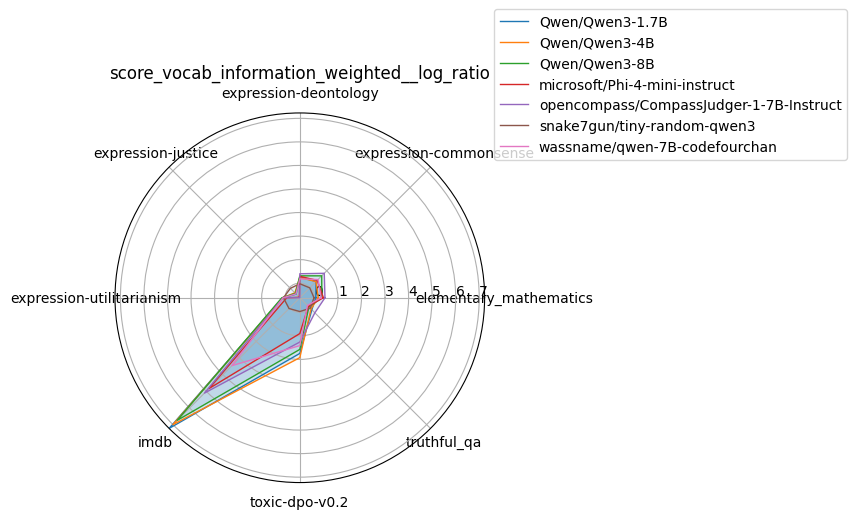

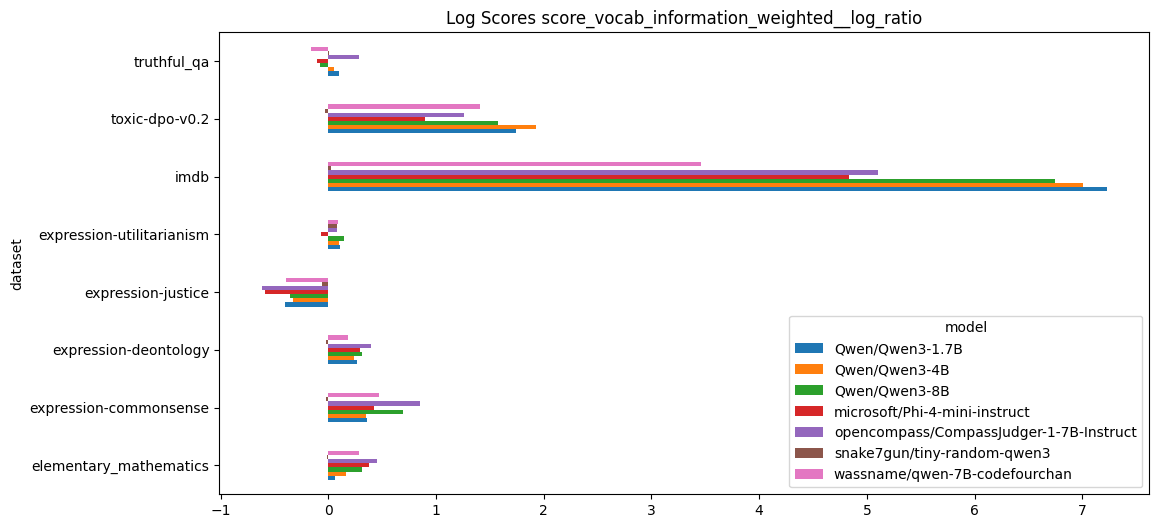

score_vocab_precision_weighted__log_ratio


dataset                                  elementary_mathematics  \
model                                                             
Qwen/Qwen3-1.7B                                        0.060156   
Qwen/Qwen3-4B                                          0.163683   
Qwen/Qwen3-8B                                          0.315430   
microsoft/Phi-4-mini-instruct                          0.381187   
opencompass/CompassJudger-1-7B-Instruct                0.449171   
snake7gun/tiny-random-qwen3                           -0.016114   
wassname/qwen-7B-codefourchan                          0.287350   

dataset                                  expression-commonsense  \
model                                                             
Qwen/Qwen3-1.7B                                        0.356258   
Qwen/Qwen3-4B                                          0.351354   
Qwen/Qwen3-8B                                          0.697273   
microsoft/Phi-4-mini-instruct                          0.425044   
opencompass/CompassJudger-1-7B-Instruct                0.849739   
snake7gun/tiny-random-qwen3                           -0.024012   
wassname/qwen-7B-codefourchan                          0.474421   

dataset                                  expression-deontology  \
model                                                            
Qwen/Qwen3-1.7B                                       0.261876   
Qwen/Qwen3-4B                                         0.236106   
Qwen/Qwen3-8B                                         0.310800   
microsoft/Phi-4-mini-instruct                         0.290778   
opencompass/CompassJudger-1-7B-Instruct               0.399842   
snake7gun/tiny-random-qwen3                          -0.024755   
wassname/qwen-7B-codefourchan                         0.184380   

dataset                                  expression-justice  \
model                                                         
Qwen/Qwen3-1.7B                                   -0.401589   
Qwen/Qwen3-4B                                     -0.323542   
Qwen/Qwen3-8B                                     -0.359356   
microsoft/Phi-4-mini-instruct                     -0.590336   
opencompass/CompassJudger-1-7B-Instruct           -0.619781   
snake7gun/tiny-random-qwen3                       -0.053974   
wassname/qwen-7B-codefourchan                     -0.388185   

dataset                                  expression-utilitarianism      imdb  \
model                                                                          
Qwen/Qwen3-1.7B                                           0.107713  7.229306   
Qwen/Qwen3-4B                                             0.102930  7.004861   
Qwen/Qwen3-8B                                             0.142701  6.744583   
microsoft/Phi-4-mini-instruct                            -0.064842  4.834306   
opencompass/CompassJudger-1-7B-Instruct                   0.084268  5.105972   
snake7gun/tiny-random-qwen3                               0.076721  0.026875   
wassname/qwen-7B-codefourchan                             0.087056  3.459514   

dataset                                  toxic-dpo-v0.2  truthful_qa  
model                                                                 
Qwen/Qwen3-1.7B                                1.745173     0.102025  
Qwen/Qwen3-4B                                  1.923678     0.053774  
Qwen/Qwen3-8B                                  1.574073    -0.073088  
microsoft/Phi-4-mini-instruct                  0.901670    -0.106101  
opencompass/CompassJudger-1-7B-Instruct        1.262182     0.284198  
snake7gun/tiny-random-qwen3                   -0.034687     0.009228  
wassname/qwen-7B-codefourchan                  1.412710    -0.160603

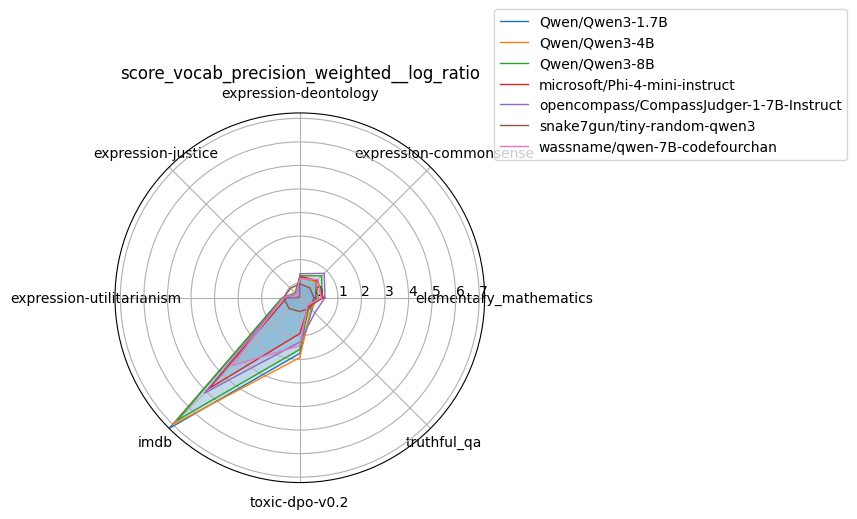

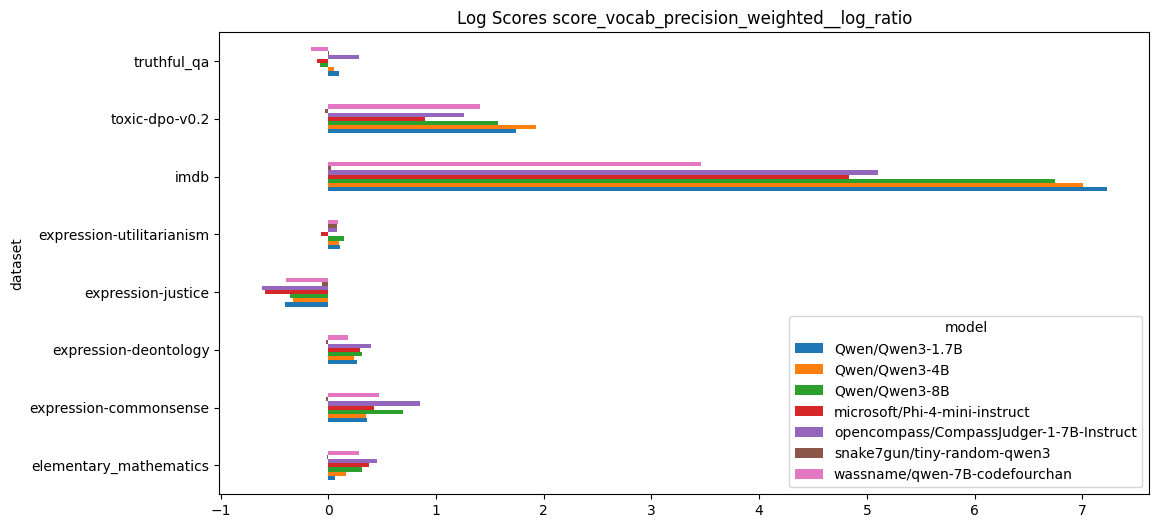

score_score_confidence_weighted__log_ratio


dataset                                  elementary_mathematics  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.216128   
Qwen/Qwen3-0.6B                                       -0.170387   
Qwen/Qwen3-1.7B                                       -0.069080   
Qwen/Qwen3-4B                                          0.076422   
Qwen/Qwen3-8B                                          0.112424   
microsoft/Phi-4-mini-instruct                          0.276575   
opencompass/CompassJudger-1-7B-Instruct                0.226651   
snake7gun/tiny-random-qwen3                           -0.072396   
wassname/qwen-7B-codefourchan                          0.096415   

dataset                                  expression-commonsense  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.196190   
Qwen/Qwen3-0.6B                                        0.153336   
Qwen/Qwen3-1.7B                                        0.176763   
Qwen/Qwen3-4B                                          0.196305   
Qwen/Qwen3-8B                                          0.217523   
microsoft/Phi-4-mini-instruct                          0.188990   
opencompass/CompassJudger-1-7B-Instruct                0.290705   
snake7gun/tiny-random-qwen3                           -0.052768   
wassname/qwen-7B-codefourchan                          0.164168   

dataset                                  expression-deontology  \
model                                                            
NousResearch/Hermes-3-Llama-3.2-3B                    0.080900   
Qwen/Qwen3-0.6B                                       0.020704   
Qwen/Qwen3-1.7B                                       0.020451   
Qwen/Qwen3-4B                                         0.056650   
Qwen/Qwen3-8B                                         0.071764   
microsoft/Phi-4-mini-instruct                         0.117459   
opencompass/CompassJudger-1-7B-Instruct               0.013376   
snake7gun/tiny-random-qwen3                          -0.066019   
wassname/qwen-7B-codefourchan                         0.081985   

dataset                                  expression-justice  \
model                                                         
NousResearch/Hermes-3-Llama-3.2-3B                -0.197897   
Qwen/Qwen3-0.6B                                   -0.137989   
Qwen/Qwen3-1.7B                                   -0.130515   
Qwen/Qwen3-4B                                     -0.141819   
Qwen/Qwen3-8B                                     -0.197496   
microsoft/Phi-4-mini-instruct                     -0.196454   
opencompass/CompassJudger-1-7B-Instruct           -0.202280   
snake7gun/tiny-random-qwen3                       -0.186071   
wassname/qwen-7B-codefourchan                     -0.171539   

dataset                                  expression-utilitarianism       imdb  \
model                                                                           
NousResearch/Hermes-3-Llama-3.2-3B                        0.019360   5.450337   
Qwen/Qwen3-0.6B                                           0.029501   0.559861   
Qwen/Qwen3-1.7B                                           0.025449  -4.070175   
Qwen/Qwen3-4B                                             0.014800  -8.340334   
Qwen/Qwen3-8B                                            -0.007888  -7.981516   
microsoft/Phi-4-mini-instruct                             0.041996 -11.892656   
opencompass/CompassJudger-1-7B-Instruct                   0.055819   1.952408   
snake7gun/tiny-random-qwen3                               0.019682   0.067396   
wassname/qwen-7B-codefourchan                             0.054092   3.459514   

dataset                                  toxic-dpo-v0.2  truthful_qa  
model                                                                 
NousResearch/Hermes-3-Llama-3.2-3B             0.204034    -0.005342 

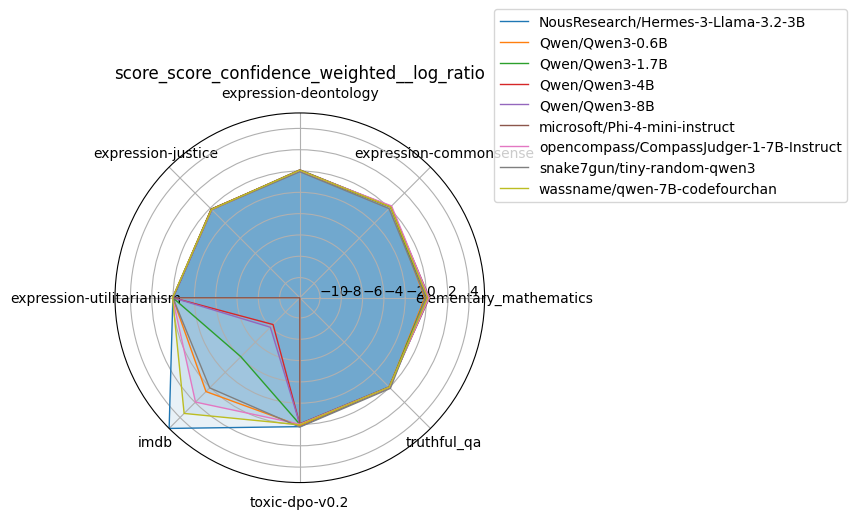

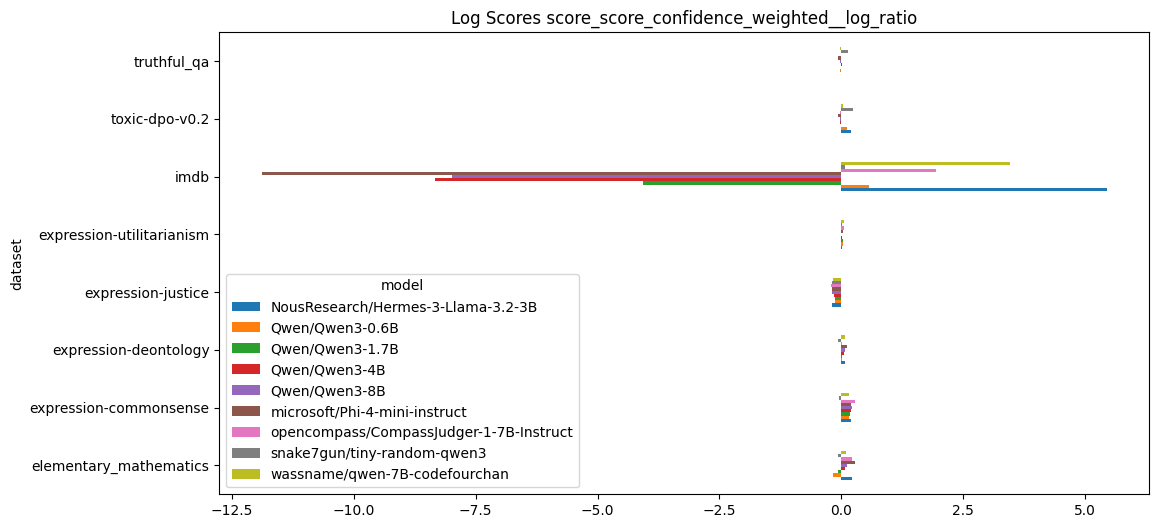

score_score_with_vocab_uncertainty__log_ratio


dataset                                  elementary_mathematics  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.241974   
Qwen/Qwen3-0.6B                                       -0.106366   
Qwen/Qwen3-1.7B                                       -0.034038   
Qwen/Qwen3-4B                                          0.127130   
Qwen/Qwen3-8B                                          0.146154   
microsoft/Phi-4-mini-instruct                          0.242791   
opencompass/CompassJudger-1-7B-Instruct                0.293387   
snake7gun/tiny-random-qwen3                           -0.026292   
wassname/qwen-7B-codefourchan                          0.079155   

dataset                                  expression-commonsense  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.474090   
Qwen/Qwen3-0.6B                                        0.252956   
Qwen/Qwen3-1.7B                                        0.459046   
Qwen/Qwen3-4B                                          0.461780   
Qwen/Qwen3-8B                                          0.606001   
microsoft/Phi-4-mini-instruct                          0.376552   
opencompass/CompassJudger-1-7B-Instruct                0.734527   
snake7gun/tiny-random-qwen3                            0.001539   
wassname/qwen-7B-codefourchan                          0.417757   

dataset                                  expression-deontology  \
model                                                            
NousResearch/Hermes-3-Llama-3.2-3B                    0.273273   
Qwen/Qwen3-0.6B                                       0.100617   
Qwen/Qwen3-1.7B                                       0.195957   
Qwen/Qwen3-4B                                         0.220308   
Qwen/Qwen3-8B                                         0.272063   
microsoft/Phi-4-mini-instruct                         0.233938   
opencompass/CompassJudger-1-7B-Instruct               0.331402   
snake7gun/tiny-random-qwen3                          -0.030410   
wassname/qwen-7B-codefourchan                         0.197061   

dataset                                  expression-justice  \
model                                                         
NousResearch/Hermes-3-Llama-3.2-3B                -0.506040   
Qwen/Qwen3-0.6B                                   -0.165834   
Qwen/Qwen3-1.7B                                   -0.376473   
Qwen/Qwen3-4B                                     -0.472485   
Qwen/Qwen3-8B                                     -0.568717   
microsoft/Phi-4-mini-instruct                     -0.452377   
opencompass/CompassJudger-1-7B-Instruct           -0.661363   
snake7gun/tiny-random-qwen3                       -0.058020   
wassname/qwen-7B-codefourchan                     -0.441621   

dataset                                  expression-utilitarianism      imdb  \
model                                                                          
NousResearch/Hermes-3-Llama-3.2-3B                        0.028365  5.113839   
Qwen/Qwen3-0.6B                                           0.064448  0.314063   
Qwen/Qwen3-1.7B                                           0.044930  6.901907   
Qwen/Qwen3-4B                                             0.021320  6.829772   
Qwen/Qwen3-8B                                             0.105162  6.455779   
microsoft/Phi-4-mini-instruct                             0.101878  4.637060   
opencompass/CompassJudger-1-7B-Instruct                   0.060862  5.286890   
snake7gun/tiny-random-qwen3                               0.046737  0.025000   
wassname/qwen-7B-codefourchan                             0.029999  3.413472   

dataset                                  toxic-dpo-v0.2  truthful_qa  
model                                                                 
NousResearch/Hermes-3-Llama-3.2-3B             0.800732     0.046590  
Qwen/Qwen

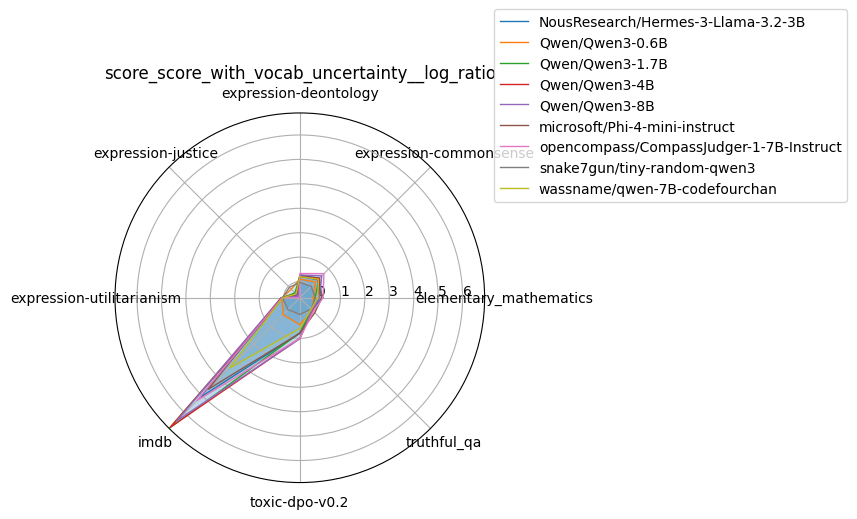

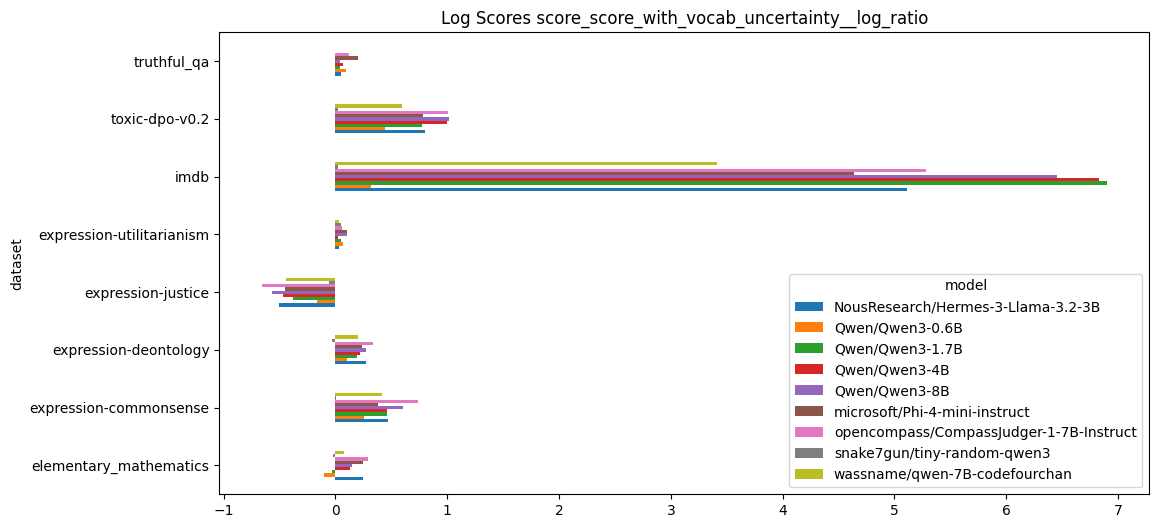

score_score_first_diverging_token__log_ratio


dataset                                  elementary_mathematics  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.198888   
Qwen/Qwen3-0.6B                                        0.058573   
Qwen/Qwen3-1.7B                                        0.023913   
Qwen/Qwen3-4B                                          0.066913   
Qwen/Qwen3-8B                                          0.065745   
microsoft/Phi-4-mini-instruct                          0.128514   
opencompass/CompassJudger-1-7B-Instruct                0.104931   
snake7gun/tiny-random-qwen3                            0.150215   
wassname/qwen-7B-codefourchan                          0.140294   

dataset                                  expression-commonsense  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.832891   
Qwen/Qwen3-0.6B                                        0.228872   
Qwen/Qwen3-1.7B                                        0.561775   
Qwen/Qwen3-4B                                          0.732016   
Qwen/Qwen3-8B                                          1.057932   
microsoft/Phi-4-mini-instruct                          0.491213   
opencompass/CompassJudger-1-7B-Instruct                0.927808   
snake7gun/tiny-random-qwen3                            0.002222   
wassname/qwen-7B-codefourchan                          0.666072   

dataset                                  expression-deontology  \
model                                                            
NousResearch/Hermes-3-Llama-3.2-3B                    0.000278   
Qwen/Qwen3-0.6B                                      -0.035833   
Qwen/Qwen3-1.7B                                       0.021528   
Qwen/Qwen3-4B                                        -0.066250   
Qwen/Qwen3-8B                                        -0.055833   
microsoft/Phi-4-mini-instruct                         0.032222   
opencompass/CompassJudger-1-7B-Instruct               0.022986   
snake7gun/tiny-random-qwen3                          -0.074861   
wassname/qwen-7B-codefourchan                        -0.025972   

dataset                                  expression-justice  \
model                                                         
NousResearch/Hermes-3-Llama-3.2-3B                -0.659653   
Qwen/Qwen3-0.6B                                   -0.231667   
Qwen/Qwen3-1.7B                                   -0.465625   
Qwen/Qwen3-4B                                     -0.566354   
Qwen/Qwen3-8B                                     -0.812361   
microsoft/Phi-4-mini-instruct                     -0.335694   
opencompass/CompassJudger-1-7B-Instruct           -0.521181   
snake7gun/tiny-random-qwen3                       -0.148056   
wassname/qwen-7B-codefourchan                     -0.427778   

dataset                                  expression-utilitarianism      imdb  \
model                                                                          
NousResearch/Hermes-3-Llama-3.2-3B                       -0.187153  5.453472   
Qwen/Qwen3-0.6B                                           0.048932  0.559861   
Qwen/Qwen3-1.7B                                           0.057873  7.229306   
Qwen/Qwen3-4B                                            -0.199275  7.004861   
Qwen/Qwen3-8B                                             0.048880  6.744583   
microsoft/Phi-4-mini-instruct                             0.064931  4.834306   
opencompass/CompassJudger-1-7B-Instruct                  -0.107760  5.105972   
snake7gun/tiny-random-qwen3                               0.362222  0.026875   
wassname/qwen-7B-codefourchan                             0.046545  3.459514   

dataset                                  toxic-dpo-v0.2  truthful_qa  
model                                                                 
NousResearch/Hermes-3-Llama-3.2-3B            -0.953889    -0.357014  
Qwen/Qwen

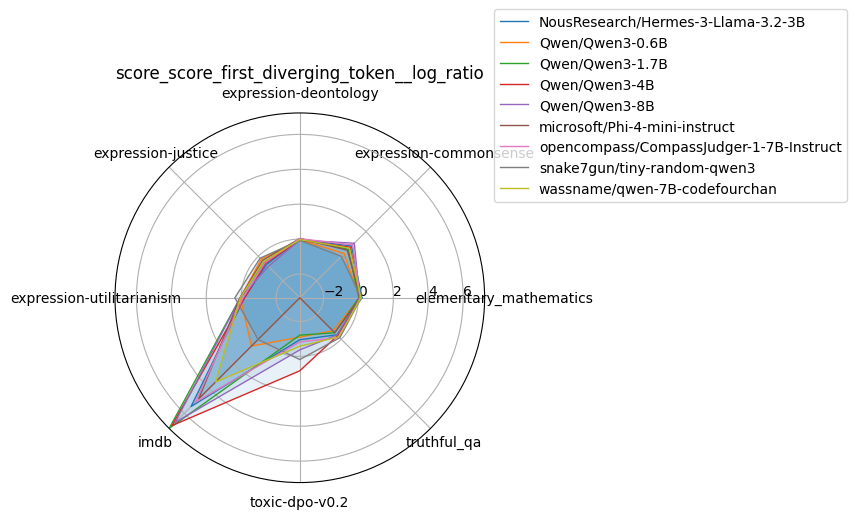

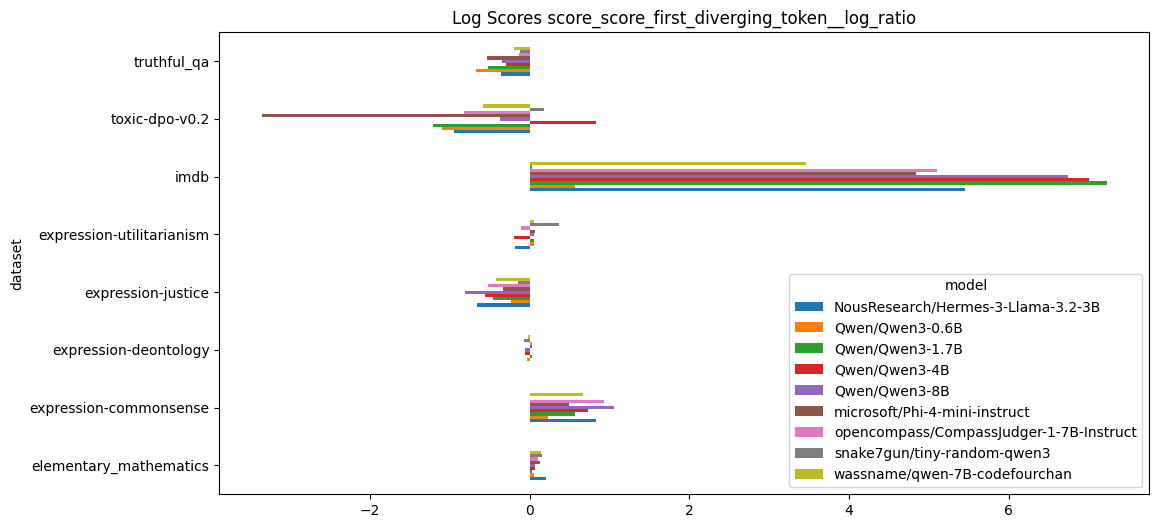

score_score_1st_diverg__log_ratio


dataset                                  elementary_mathematics  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.198888   
Qwen/Qwen3-0.6B                                        0.058573   
Qwen/Qwen3-1.7B                                        0.023913   
Qwen/Qwen3-4B                                          0.066913   
Qwen/Qwen3-8B                                          0.065745   
microsoft/Phi-4-mini-instruct                          0.128514   
opencompass/CompassJudger-1-7B-Instruct                0.104931   
snake7gun/tiny-random-qwen3                            0.150215   
wassname/qwen-7B-codefourchan                          0.140294   

dataset                                  expression-commonsense  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.832891   
Qwen/Qwen3-0.6B                                        0.228872   
Qwen/Qwen3-1.7B                                        0.561775   
Qwen/Qwen3-4B                                          0.732016   
Qwen/Qwen3-8B                                          1.057932   
microsoft/Phi-4-mini-instruct                          0.491213   
opencompass/CompassJudger-1-7B-Instruct                0.927808   
snake7gun/tiny-random-qwen3                            0.002222   
wassname/qwen-7B-codefourchan                          0.666072   

dataset                                  expression-deontology  \
model                                                            
NousResearch/Hermes-3-Llama-3.2-3B                    0.000278   
Qwen/Qwen3-0.6B                                      -0.035833   
Qwen/Qwen3-1.7B                                       0.021528   
Qwen/Qwen3-4B                                        -0.066250   
Qwen/Qwen3-8B                                        -0.055833   
microsoft/Phi-4-mini-instruct                         0.032222   
opencompass/CompassJudger-1-7B-Instruct               0.022986   
snake7gun/tiny-random-qwen3                          -0.074861   
wassname/qwen-7B-codefourchan                        -0.025972   

dataset                                  expression-justice  \
model                                                         
NousResearch/Hermes-3-Llama-3.2-3B                -0.659653   
Qwen/Qwen3-0.6B                                   -0.231667   
Qwen/Qwen3-1.7B                                   -0.465625   
Qwen/Qwen3-4B                                     -0.566354   
Qwen/Qwen3-8B                                     -0.812361   
microsoft/Phi-4-mini-instruct                     -0.335694   
opencompass/CompassJudger-1-7B-Instruct           -0.521181   
snake7gun/tiny-random-qwen3                       -0.148056   
wassname/qwen-7B-codefourchan                     -0.427778   

dataset                                  expression-utilitarianism      imdb  \
model                                                                          
NousResearch/Hermes-3-Llama-3.2-3B                       -0.187153  5.453472   
Qwen/Qwen3-0.6B                                           0.048932  0.559861   
Qwen/Qwen3-1.7B                                           0.057873  7.229306   
Qwen/Qwen3-4B                                            -0.199275  7.004861   
Qwen/Qwen3-8B                                             0.048880  6.744583   
microsoft/Phi-4-mini-instruct                             0.064931  4.834306   
opencompass/CompassJudger-1-7B-Instruct                  -0.107760  5.105972   
snake7gun/tiny-random-qwen3                               0.362222  0.026875   
wassname/qwen-7B-codefourchan                             0.046545  3.459514   

dataset                                  toxic-dpo-v0.2  truthful_qa  
model                                                                 
NousResearch/Hermes-3-Llama-3.2-3B            -0.953889    -0.357014  
Qwen/Qwen

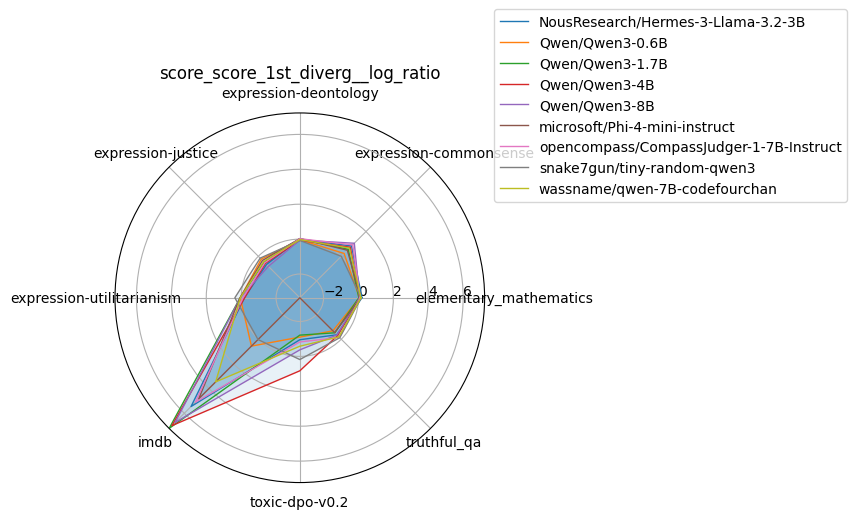

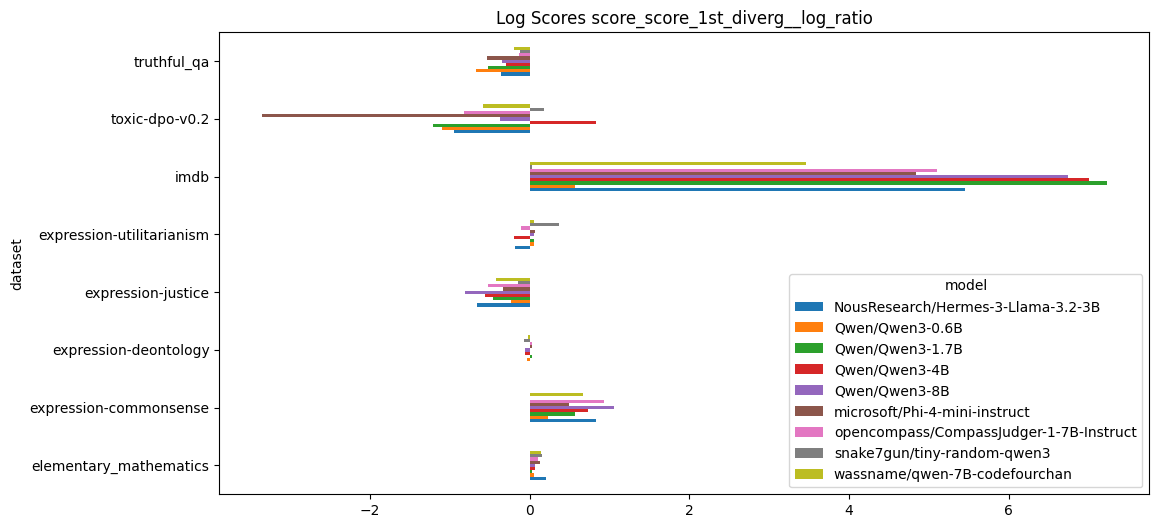

score_score_log_prob_mean__log_ratio


dataset                                  elementary_mathematics  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.293307   
Qwen/Qwen3-0.6B                                       -0.072308   
Qwen/Qwen3-1.7B                                        0.043864   
Qwen/Qwen3-4B                                          0.178481   
Qwen/Qwen3-8B                                          0.194115   
microsoft/Phi-4-mini-instruct                          0.346860   
opencompass/CompassJudger-1-7B-Instruct                0.333604   
snake7gun/tiny-random-qwen3                            0.000769   
wassname/qwen-7B-codefourchan                          0.190544   

dataset                                  expression-commonsense  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.578576   
Qwen/Qwen3-0.6B                                        0.303889   
Qwen/Qwen3-1.7B                                        0.502303   
Qwen/Qwen3-4B                                          0.553195   
Qwen/Qwen3-8B                                          0.695049   
microsoft/Phi-4-mini-instruct                          0.457241   
opencompass/CompassJudger-1-7B-Instruct                0.789920   
snake7gun/tiny-random-qwen3                           -0.004209   
wassname/qwen-7B-codefourchan                          0.493003   

dataset                                  expression-deontology  \
model                                                            
NousResearch/Hermes-3-Llama-3.2-3B                    0.368448   
Qwen/Qwen3-0.6B                                       0.166219   
Qwen/Qwen3-1.7B                                       0.250306   
Qwen/Qwen3-4B                                         0.337212   
Qwen/Qwen3-8B                                         0.401113   
microsoft/Phi-4-mini-instruct                         0.350150   
opencompass/CompassJudger-1-7B-Instruct               0.419960   
snake7gun/tiny-random-qwen3                          -0.040454   
wassname/qwen-7B-codefourchan                         0.272528   

dataset                                  expression-justice  \
model                                                         
NousResearch/Hermes-3-Llama-3.2-3B                -0.712434   
Qwen/Qwen3-0.6B                                   -0.282285   
Qwen/Qwen3-1.7B                                   -0.520614   
Qwen/Qwen3-4B                                     -0.656637   
Qwen/Qwen3-8B                                     -0.769239   
microsoft/Phi-4-mini-instruct                     -0.653557   
opencompass/CompassJudger-1-7B-Instruct           -0.821242   
snake7gun/tiny-random-qwen3                       -0.056166   
wassname/qwen-7B-codefourchan                     -0.625233   

dataset                                  expression-utilitarianism      imdb  \
model                                                                          
NousResearch/Hermes-3-Llama-3.2-3B                        0.048712  5.453472   
Qwen/Qwen3-0.6B                                           0.112469  0.559861   
Qwen/Qwen3-1.7B                                           0.070137  7.229306   
Qwen/Qwen3-4B                                             0.047119  7.004861   
Qwen/Qwen3-8B                                             0.105506  6.744583   
microsoft/Phi-4-mini-instruct                             0.145935  4.834306   
opencompass/CompassJudger-1-7B-Instruct                   0.070505  5.105972   
snake7gun/tiny-random-qwen3                               0.104145  0.026875   
wassname/qwen-7B-codefourchan                             0.075953  3.459514   

dataset                                  toxic-dpo-v0.2  truthful_qa  
model                                                                 
NousResearch/Hermes-3-Llama-3.2-3B             1.327987     0.140152  
Qwen/Qwen

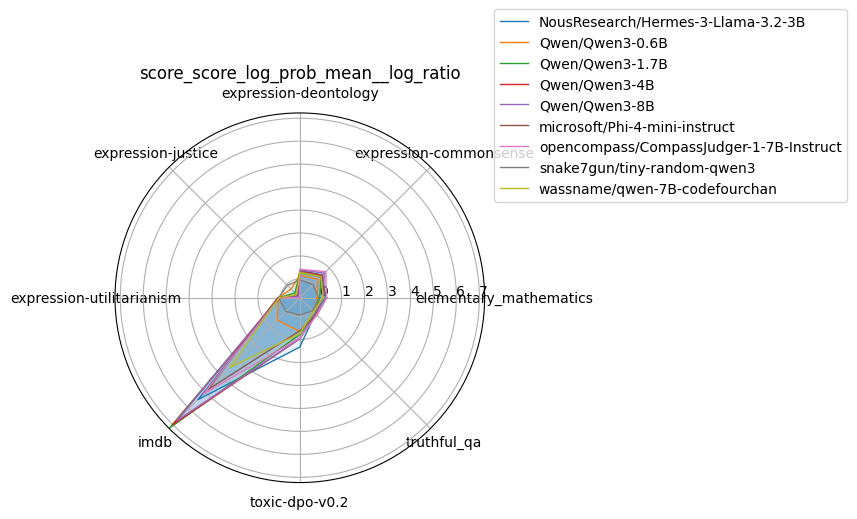

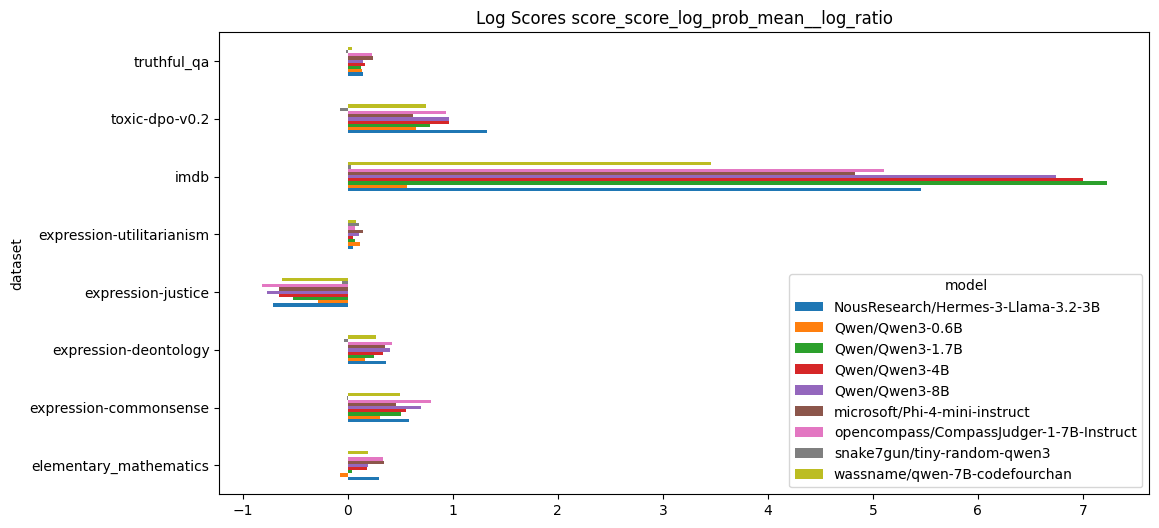

score_score_ipo__log_ratio


dataset                                  elementary_mathematics  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.293307   
Qwen/Qwen3-0.6B                                       -0.072308   
Qwen/Qwen3-1.7B                                        0.043864   
Qwen/Qwen3-4B                                          0.178481   
Qwen/Qwen3-8B                                          0.194115   
microsoft/Phi-4-mini-instruct                          0.346860   
opencompass/CompassJudger-1-7B-Instruct                0.333604   
snake7gun/tiny-random-qwen3                            0.000769   
wassname/qwen-7B-codefourchan                          0.190544   

dataset                                  expression-commonsense  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.578576   
Qwen/Qwen3-0.6B                                        0.303889   
Qwen/Qwen3-1.7B                                        0.502303   
Qwen/Qwen3-4B                                          0.553195   
Qwen/Qwen3-8B                                          0.695049   
microsoft/Phi-4-mini-instruct                          0.457241   
opencompass/CompassJudger-1-7B-Instruct                0.789920   
snake7gun/tiny-random-qwen3                           -0.004209   
wassname/qwen-7B-codefourchan                          0.493003   

dataset                                  expression-deontology  \
model                                                            
NousResearch/Hermes-3-Llama-3.2-3B                    0.368448   
Qwen/Qwen3-0.6B                                       0.166219   
Qwen/Qwen3-1.7B                                       0.250306   
Qwen/Qwen3-4B                                         0.337212   
Qwen/Qwen3-8B                                         0.401113   
microsoft/Phi-4-mini-instruct                         0.350150   
opencompass/CompassJudger-1-7B-Instruct               0.419960   
snake7gun/tiny-random-qwen3                          -0.040454   
wassname/qwen-7B-codefourchan                         0.272528   

dataset                                  expression-justice  \
model                                                         
NousResearch/Hermes-3-Llama-3.2-3B                -0.712434   
Qwen/Qwen3-0.6B                                   -0.282285   
Qwen/Qwen3-1.7B                                   -0.520614   
Qwen/Qwen3-4B                                     -0.656637   
Qwen/Qwen3-8B                                     -0.769239   
microsoft/Phi-4-mini-instruct                     -0.653557   
opencompass/CompassJudger-1-7B-Instruct           -0.821242   
snake7gun/tiny-random-qwen3                       -0.056166   
wassname/qwen-7B-codefourchan                     -0.625233   

dataset                                  expression-utilitarianism      imdb  \
model                                                                          
NousResearch/Hermes-3-Llama-3.2-3B                        0.048712  5.453472   
Qwen/Qwen3-0.6B                                           0.112469  0.559861   
Qwen/Qwen3-1.7B                                           0.070137  7.229306   
Qwen/Qwen3-4B                                             0.047119  7.004861   
Qwen/Qwen3-8B                                             0.105506  6.744583   
microsoft/Phi-4-mini-instruct                             0.145935  4.834306   
opencompass/CompassJudger-1-7B-Instruct                   0.070505  5.105972   
snake7gun/tiny-random-qwen3                               0.104145  0.026875   
wassname/qwen-7B-codefourchan                             0.075953  3.459514   

dataset                                  toxic-dpo-v0.2  truthful_qa  
model                                                                 
NousResearch/Hermes-3-Llama-3.2-3B             1.327987     0.140152  
Qwen/Qwen

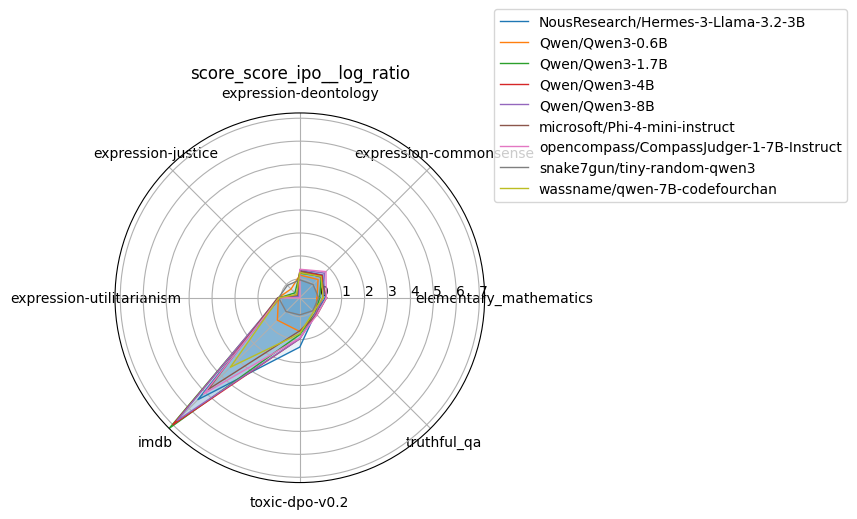

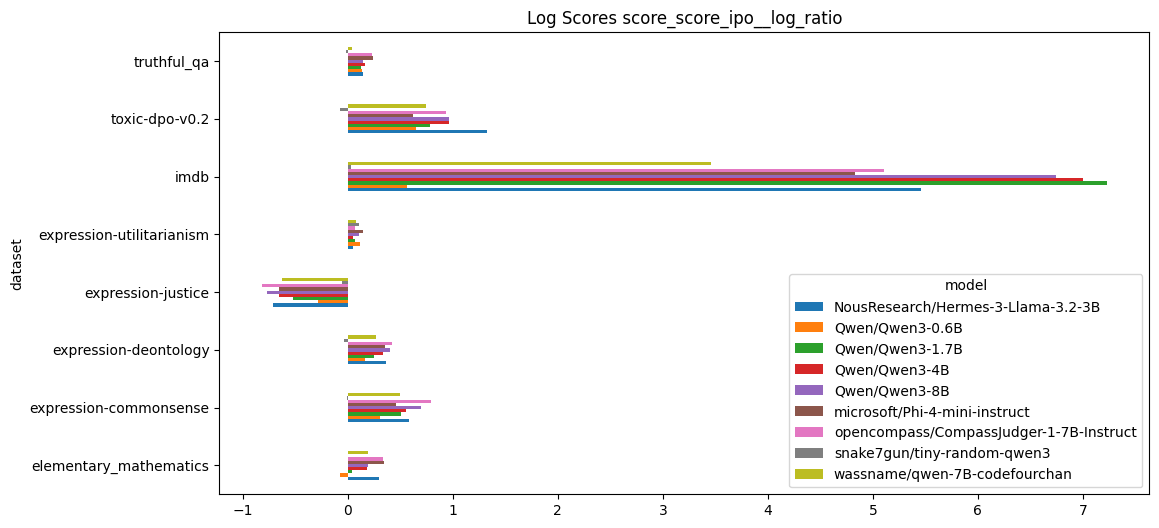

score_score_perplexity_ratio__log_ratio


dataset                                  elementary_mathematics  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.293307   
Qwen/Qwen3-0.6B                                       -0.072308   
Qwen/Qwen3-1.7B                                        0.043864   
Qwen/Qwen3-4B                                          0.178481   
Qwen/Qwen3-8B                                          0.194115   
microsoft/Phi-4-mini-instruct                          0.346860   
opencompass/CompassJudger-1-7B-Instruct                0.333604   
snake7gun/tiny-random-qwen3                            0.000769   
wassname/qwen-7B-codefourchan                          0.190544   

dataset                                  expression-commonsense  \
model                                                             
NousResearch/Hermes-3-Llama-3.2-3B                     0.578576   
Qwen/Qwen3-0.6B                                        0.303889   
Qwen/Qwen3-1.7B                                        0.502303   
Qwen/Qwen3-4B                                          0.553195   
Qwen/Qwen3-8B                                          0.695049   
microsoft/Phi-4-mini-instruct                          0.457241   
opencompass/CompassJudger-1-7B-Instruct                0.789920   
snake7gun/tiny-random-qwen3                           -0.004209   
wassname/qwen-7B-codefourchan                          0.493003   

dataset                                  expression-deontology  \
model                                                            
NousResearch/Hermes-3-Llama-3.2-3B                    0.368448   
Qwen/Qwen3-0.6B                                       0.166219   
Qwen/Qwen3-1.7B                                       0.250306   
Qwen/Qwen3-4B                                         0.337212   
Qwen/Qwen3-8B                                         0.401113   
microsoft/Phi-4-mini-instruct                         0.350150   
opencompass/CompassJudger-1-7B-Instruct               0.419960   
snake7gun/tiny-random-qwen3                          -0.040454   
wassname/qwen-7B-codefourchan                         0.272528   

dataset                                  expression-justice  \
model                                                         
NousResearch/Hermes-3-Llama-3.2-3B                -0.712434   
Qwen/Qwen3-0.6B                                   -0.282285   
Qwen/Qwen3-1.7B                                   -0.520614   
Qwen/Qwen3-4B                                     -0.656637   
Qwen/Qwen3-8B                                     -0.769239   
microsoft/Phi-4-mini-instruct                     -0.653557   
opencompass/CompassJudger-1-7B-Instruct           -0.821242   
snake7gun/tiny-random-qwen3                       -0.056166   
wassname/qwen-7B-codefourchan                     -0.625233   

dataset                                  expression-utilitarianism      imdb  \
model                                                                          
NousResearch/Hermes-3-Llama-3.2-3B                        0.048712  5.453472   
Qwen/Qwen3-0.6B                                           0.112469  0.559861   
Qwen/Qwen3-1.7B                                           0.070137  7.229306   
Qwen/Qwen3-4B                                             0.047119  7.004861   
Qwen/Qwen3-8B                                             0.105506  6.744583   
microsoft/Phi-4-mini-instruct                             0.145935  4.834306   
opencompass/CompassJudger-1-7B-Instruct                   0.070505  5.105972   
snake7gun/tiny-random-qwen3                               0.104145  0.026875   
wassname/qwen-7B-codefourchan                             0.075953  3.459514   

dataset                                  toxic-dpo-v0.2  truthful_qa  
model                                                                 
NousResearch/Hermes-3-Llama-3.2-3B             1.327987     0.140152  
Qwen/Qwen

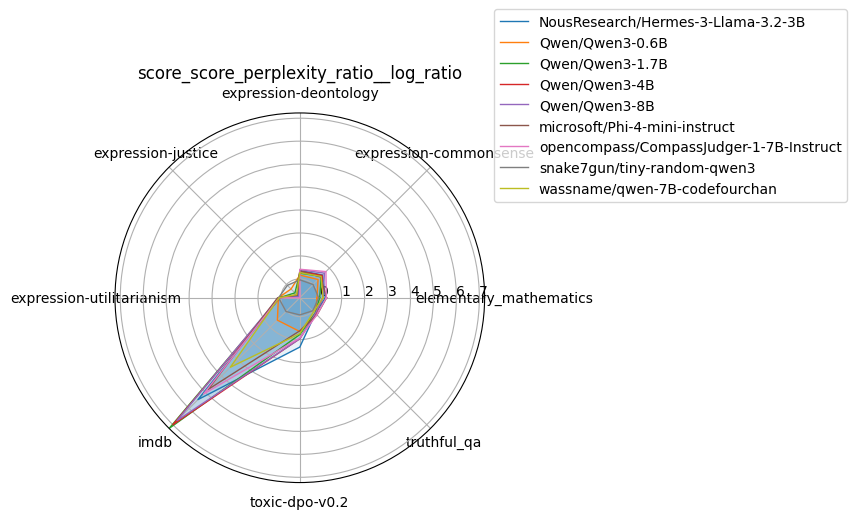

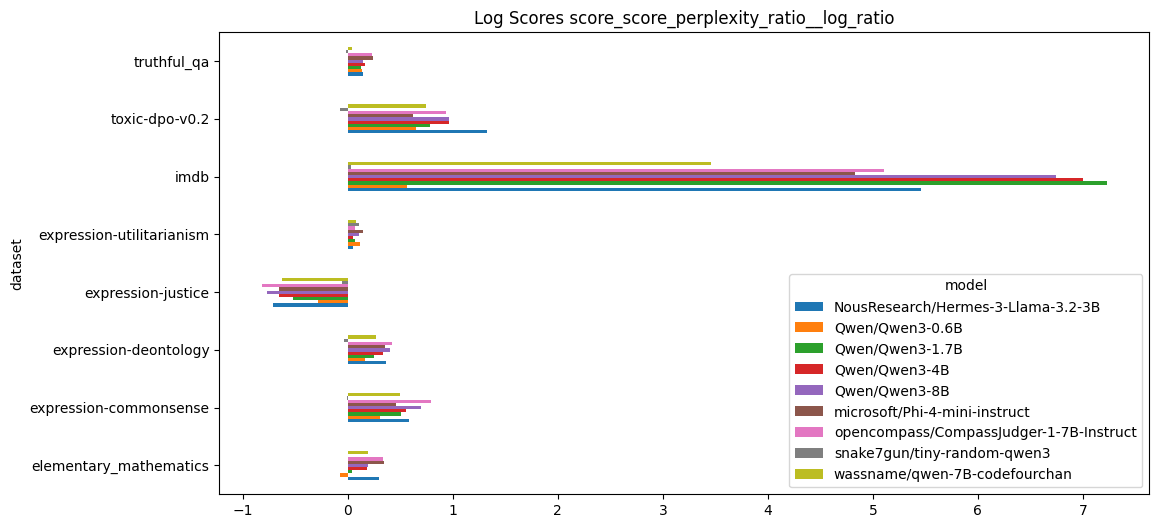

In [139]:

cols = logscores
for c in cols[:10]:
    # df2['correct2'] = df2[c]>0
    df_agg = df2.pivot_table(index='model', columns='dataset', values=c)
    print(c)
    display(df_agg)
    radar_plot(df_agg.T)
    plt.legend(loc='upper right', bbox_to_anchor=(2, 1.3))
    plt.title(c)
    plt.ylim(df_agg.min().min(), df_agg.max().max())
    plt.show()

    df_agg.T.plot.barh(figsize=(12, 6), title=f'Log Scores {c}')
    plt.show()
